In [15]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sk
import pickle
import mne
import tqdm
from tqdm import trange
import os

DEVICE='cuda'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

from torch import nn

In [16]:
def extract_data(sub_range,verbose=False,feature_func=None,**kwargs):
    first=sub_range[0]
    last=sub_range[-1]

    for sub in trange(first,last+1): 
        #read data
        if sub <=9:
            path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
        else:
            path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-vid_task-emotion_reorder.npy'
        datatemp=np.load(path,allow_pickle=True)
        datatemp=np.permute_dims(datatemp,[1,0,2])

        #if we want to convert features
        if not feature_func==None:
            datatemp=feature_func(datatemp,info=info)

        #cat data along new dimension
        datatemp=torch.tensor(datatemp).unsqueeze(0)
        if sub==first:
            data=datatemp
        else:
            data=torch.cat([data,datatemp],axis=0)

        if verbose:
            print(f'subject {sub} data extracted, vector size: {data.shape}')
    return data

def shuffle_and_split_data(X,y):
    """
    Helper function to shuffle and split data

    Args:
        X: torch.tensor
        Input data
        y: torch.tensor
        Corresponding target variables
        seed: int
        Set seed for reproducibility

    Returns:
        X_test: torch.tensor
        Test data [20% of X]
        y_test: torch.tensor
        Labels corresponding to above mentioned test data
        X_train: torch.tensor
        Train data [80% of X]
        y_train: torch.tensor
        Labels corresponding to above mentioned train data
    """
    
    N=X.size(0)
    shuffled_indices=torch.randperm(N) #get shuffled indices
    X=X[shuffled_indices]
    y=y[shuffled_indices]

    # split by 20% into train-test set
    test_size=int(0.2*N)
    X_train=X[test_size:]
    y_train=y[test_size:]
    X_test=X[:test_size]
    y_test=y[:test_size]

    return X_test,y_test,X_train,y_train

#create labels
#sad-dis-fear-neu-joy-ten-ins correspond to 0-6 respectively, each sample has 21 trials, for (7 emotions x 3 trials)
labels=np.array([])
for i in range(0,7):
    for n in range(0,3):
        labels=np.concatenate([labels,np.array([i])],axis=0)
labels=torch.tensor(labels)

<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\d'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\s'
C:\Users\malco\AppData\Local\Temp\ipykernel_38044\2464512495.py:8: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_38044\2464512495.py:8: SyntaxWarning: invalid escape sequence '\s'
  path=f'ds005540\derivatives\sub-0{sub}\ses-vid\eeg\sub-0{sub}_ses-vid_task-emotion_reorder.npy'
C:\Users\malco\AppData\Local\Temp\ipykernel_38044\2464512495.py:10: SyntaxWarning: invalid escape sequence '\d'
  path=f'ds005540\derivatives\sub-{sub}\ses-vid\eeg\sub-{sub}_ses-

In [17]:
data=extract_data([1,20])

100%|██████████| 20/20 [00:02<00:00,  7.36it/s]


In [18]:
def process_data(data):
    '''further process into trials (1 second trials, 200 points)'''
    for trial in tqdm.tqdm(range(int(data.size(3)/200))):
        datatrial=data[:,:,:,trial*200:(trial+1)*200]
        datatrial=torch.unsqueeze(datatrial,2)
        if trial==0:
            newdata=datatrial
        else:
            newdata=torch.concatenate((newdata,datatrial),2)
    return newdata

In [19]:
data=process_data(data)
data.shape #subject,label,trials,electrodes,timepoints

100%|██████████| 30/30 [00:03<00:00,  9.57it/s]


torch.Size([20, 21, 30, 64, 200])

In [20]:
for label in tqdm.tqdm(range(21)): #combine labels and trials
    temp=data[:,label,:,:,:]
    if label==0:
        X=temp
        y=labels[label]*torch.ones(30,1)
    else:
        X=torch.concatenate((X,temp),dim=1)
        y=torch.concatenate((y,labels[label]*torch.ones(30,1)),dim=0)

#combine subjects
for subject in tqdm.tqdm(range(X.size(0))):
    temp=X[subject,:,:,:]
    if subject==0:
        X_full=temp
        y_full=y
    else:
        X_full=torch.concatenate((X_full,temp),dim=0)
        y_full=torch.concatenate((y_full,y),dim=0)
        
#split data
X_test,y_test,X_train,y_train=shuffle_and_split_data(X_full,y_full.squeeze())

print(X_test.shape,y_test.shape,X_train.shape,y_train.shape)

100%|██████████| 20/20 [00:02<00:00,  8.80it/s]

torch.Size([2520, 64, 200]) torch.Size([2520]) torch.Size([10080, 64, 200]) torch.Size([10080])


In [41]:
#now the model
class Net(nn.Module):
    def __init__(self,dropout):
        super(Net,self).__init__()
        self.conv1=nn.Conv1d(64,128,kernel_size=7,padding=3)
        self.conv2=nn.Conv1d(128,96,kernel_size=9,padding=4)
        self.conv3=nn.Conv1d(96,64,kernel_size=5,padding=2)
        self.conv4=nn.Conv1d(64,9,kernel_size=3,padding=1)
        self.pool=nn.MaxPool1d(2)
        self.fc1=nn.Linear(900,900)
        self.fc2=nn.Linear(900,900)
        self.fc3=nn.Linear(900,7)
        self.dropoutlayer=nn.Dropout1d(0.4)
        self.batchnorm1=nn.BatchNorm1d(128)
        self.batchnorm2=nn.BatchNorm1d(96)
        self.batchnorm3=nn.BatchNorm1d(64)
        self.batchnorm4=nn.BatchNorm1d(9)

    def forward(self,x):
        x=self.conv1(x)
        x=self.batchnorm1(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.conv2(x)
        x=self.batchnorm2(x)
        x=self.dropoutlayer(x) 
        x=nn.functional.relu(x)       

        x=self.conv3(x)
        x=self.batchnorm3(x)
        x=self.dropoutlayer(x) 
        x=nn.functional.relu(x)       

        x=self.conv4(x)
        x=self.batchnorm4(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)
        x=self.pool(x)
        
        x=torch.flatten(x,1)

        x=self.fc1(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.fc2(x)
        x=self.dropoutlayer(x)
        x=nn.functional.relu(x)

        x=self.fc3(x)

        return x
    


def train_test(net,epochs,train_loader,test_loader,device):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(net.parameters(),lr=1e-3,weight_decay=1e-4)
    train_acc=[]
    train_loss=[]
    test_acc=[]
    test_loss=[]
    net.to(device)
    for epoch in tqdm.tqdm(range(epochs)):
        net.train()
        running_loss=0.0
        correct,total=0,0
        for i,data in enumerate(train_loader,start=0):
            inputs,labels=data
            inputs=inputs.to(device).float()
            labels=labels.to(device).long()
            
            #train
            optimizer.zero_grad()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss+=loss.item()
            #training accuracy
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        train_loss.append(running_loss/len(train_loader))
        train_acc.append(correct/total)
        print(f"epoch {epoch} --> TRAIN loss: {running_loss/len(train_loader):.5f}, TRAIN accuracy: {correct/total:.2f}")

        #eval on test
        net.eval()
        running_loss=0.0
        correct,total=0,0
        for inputs,labels in test_loader:
            inputs,labels=inputs.to(device).float(),labels.to(device).long()
            outputs=net.forward(inputs)
            loss=criterion(outputs,labels)
            running_loss+=loss.item()

            #test acc
            _,predicted=torch.max(outputs,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum()
        test_loss.append(running_loss/len(test_loader))
        test_acc.append(correct/total)
        print(f"epoch {epoch} --> TEST loss: {running_loss/len(train_loader):.2f}, TEST accuracy: {correct/total:.2f}")

    return train_loss,train_acc,test_loss,test_acc


batch_size=300
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, batch_size=batch_size,
                         shuffle=False,num_workers=0
                         )

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=False,
                          shuffle=True,num_workers=0
                          )

In [42]:
net=Net(dropout=0.3)
train_loss,train_acc,test_loss,test_acc=train_test(net,1000,train_loader=train_loader,test_loader=test_loader,device=DEVICE)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<23:32,  1.41s/it]

epoch 0 --> TRAIN loss: 1.96804, TRAIN accuracy: 0.14
epoch 0 --> TEST loss: 0.52, TEST accuracy: 0.14


  0%|          | 2/1000 [00:02<20:14,  1.22s/it]

epoch 1 --> TRAIN loss: 1.94786, TRAIN accuracy: 0.15
epoch 1 --> TEST loss: 0.51, TEST accuracy: 0.15


  0%|          | 3/1000 [00:03<19:20,  1.16s/it]

epoch 2 --> TRAIN loss: 1.94630, TRAIN accuracy: 0.14
epoch 2 --> TEST loss: 0.51, TEST accuracy: 0.13


  0%|          | 4/1000 [00:04<18:45,  1.13s/it]

epoch 3 --> TRAIN loss: 1.94656, TRAIN accuracy: 0.15
epoch 3 --> TEST loss: 0.51, TEST accuracy: 0.14


  0%|          | 5/1000 [00:05<18:25,  1.11s/it]

epoch 4 --> TRAIN loss: 1.94692, TRAIN accuracy: 0.14
epoch 4 --> TEST loss: 0.52, TEST accuracy: 0.14


  1%|          | 6/1000 [00:06<18:18,  1.10s/it]

epoch 5 --> TRAIN loss: 1.94636, TRAIN accuracy: 0.14
epoch 5 --> TEST loss: 0.51, TEST accuracy: 0.14


  1%|          | 7/1000 [00:07<18:25,  1.11s/it]

epoch 6 --> TRAIN loss: 1.94681, TRAIN accuracy: 0.14
epoch 6 --> TEST loss: 0.52, TEST accuracy: 0.15


  1%|          | 8/1000 [00:09<18:12,  1.10s/it]

epoch 7 --> TRAIN loss: 1.94610, TRAIN accuracy: 0.14
epoch 7 --> TEST loss: 0.52, TEST accuracy: 0.14


  1%|          | 9/1000 [00:10<18:16,  1.11s/it]

epoch 8 --> TRAIN loss: 1.94724, TRAIN accuracy: 0.15
epoch 8 --> TEST loss: 0.52, TEST accuracy: 0.14


  1%|          | 10/1000 [00:11<18:09,  1.10s/it]

epoch 9 --> TRAIN loss: 1.94584, TRAIN accuracy: 0.15
epoch 9 --> TEST loss: 0.52, TEST accuracy: 0.15


  1%|          | 11/1000 [00:12<18:08,  1.10s/it]

epoch 10 --> TRAIN loss: 1.94618, TRAIN accuracy: 0.14
epoch 10 --> TEST loss: 0.51, TEST accuracy: 0.15


  1%|          | 12/1000 [00:13<19:11,  1.17s/it]

epoch 11 --> TRAIN loss: 1.94637, TRAIN accuracy: 0.15
epoch 11 --> TEST loss: 0.52, TEST accuracy: 0.13


  1%|▏         | 13/1000 [00:14<19:42,  1.20s/it]

epoch 12 --> TRAIN loss: 1.94628, TRAIN accuracy: 0.15
epoch 12 --> TEST loss: 0.51, TEST accuracy: 0.15


  1%|▏         | 14/1000 [00:16<20:12,  1.23s/it]

epoch 13 --> TRAIN loss: 1.94621, TRAIN accuracy: 0.15
epoch 13 --> TEST loss: 0.52, TEST accuracy: 0.15


  2%|▏         | 15/1000 [00:17<20:51,  1.27s/it]

epoch 14 --> TRAIN loss: 1.94636, TRAIN accuracy: 0.14
epoch 14 --> TEST loss: 0.52, TEST accuracy: 0.15


  2%|▏         | 16/1000 [00:18<21:01,  1.28s/it]

epoch 15 --> TRAIN loss: 1.94527, TRAIN accuracy: 0.15
epoch 15 --> TEST loss: 0.51, TEST accuracy: 0.14


  2%|▏         | 17/1000 [00:20<21:27,  1.31s/it]

epoch 16 --> TRAIN loss: 1.94520, TRAIN accuracy: 0.15
epoch 16 --> TEST loss: 0.51, TEST accuracy: 0.15


  2%|▏         | 18/1000 [00:21<21:26,  1.31s/it]

epoch 17 --> TRAIN loss: 1.94621, TRAIN accuracy: 0.15
epoch 17 --> TEST loss: 0.51, TEST accuracy: 0.14


  2%|▏         | 19/1000 [00:22<21:00,  1.28s/it]

epoch 18 --> TRAIN loss: 1.94595, TRAIN accuracy: 0.14
epoch 18 --> TEST loss: 0.52, TEST accuracy: 0.14


  2%|▏         | 20/1000 [00:23<19:58,  1.22s/it]

epoch 19 --> TRAIN loss: 1.94586, TRAIN accuracy: 0.15
epoch 19 --> TEST loss: 0.52, TEST accuracy: 0.14


  2%|▏         | 21/1000 [00:25<19:28,  1.19s/it]

epoch 20 --> TRAIN loss: 1.94588, TRAIN accuracy: 0.15
epoch 20 --> TEST loss: 0.52, TEST accuracy: 0.14


  2%|▏         | 22/1000 [00:26<18:50,  1.16s/it]

epoch 21 --> TRAIN loss: 1.94536, TRAIN accuracy: 0.14
epoch 21 --> TEST loss: 0.51, TEST accuracy: 0.14


  2%|▏         | 23/1000 [00:27<18:38,  1.15s/it]

epoch 22 --> TRAIN loss: 1.94504, TRAIN accuracy: 0.15
epoch 22 --> TEST loss: 0.51, TEST accuracy: 0.15


  2%|▏         | 24/1000 [00:28<18:29,  1.14s/it]

epoch 23 --> TRAIN loss: 1.94486, TRAIN accuracy: 0.14
epoch 23 --> TEST loss: 0.51, TEST accuracy: 0.14


  2%|▎         | 25/1000 [00:29<18:13,  1.12s/it]

epoch 24 --> TRAIN loss: 1.94565, TRAIN accuracy: 0.14
epoch 24 --> TEST loss: 0.52, TEST accuracy: 0.14


  3%|▎         | 26/1000 [00:30<17:54,  1.10s/it]

epoch 25 --> TRAIN loss: 1.94588, TRAIN accuracy: 0.14
epoch 25 --> TEST loss: 0.52, TEST accuracy: 0.15


  3%|▎         | 27/1000 [00:31<17:44,  1.09s/it]

epoch 26 --> TRAIN loss: 1.94562, TRAIN accuracy: 0.15
epoch 26 --> TEST loss: 0.52, TEST accuracy: 0.15


  3%|▎         | 28/1000 [00:32<17:40,  1.09s/it]

epoch 27 --> TRAIN loss: 1.94433, TRAIN accuracy: 0.15
epoch 27 --> TEST loss: 0.51, TEST accuracy: 0.14


  3%|▎         | 29/1000 [00:33<17:34,  1.09s/it]

epoch 28 --> TRAIN loss: 1.94527, TRAIN accuracy: 0.15
epoch 28 --> TEST loss: 0.51, TEST accuracy: 0.15


  3%|▎         | 30/1000 [00:34<17:29,  1.08s/it]

epoch 29 --> TRAIN loss: 1.94562, TRAIN accuracy: 0.15
epoch 29 --> TEST loss: 0.52, TEST accuracy: 0.15


  3%|▎         | 31/1000 [00:35<17:24,  1.08s/it]

epoch 30 --> TRAIN loss: 1.94462, TRAIN accuracy: 0.15
epoch 30 --> TEST loss: 0.51, TEST accuracy: 0.15


  3%|▎         | 32/1000 [00:36<17:19,  1.07s/it]

epoch 31 --> TRAIN loss: 1.94509, TRAIN accuracy: 0.15
epoch 31 --> TEST loss: 0.51, TEST accuracy: 0.15


  3%|▎         | 33/1000 [00:37<17:11,  1.07s/it]

epoch 32 --> TRAIN loss: 1.94416, TRAIN accuracy: 0.15
epoch 32 --> TEST loss: 0.52, TEST accuracy: 0.14


  3%|▎         | 34/1000 [00:39<17:06,  1.06s/it]

epoch 33 --> TRAIN loss: 1.94469, TRAIN accuracy: 0.15
epoch 33 --> TEST loss: 0.51, TEST accuracy: 0.15


  4%|▎         | 35/1000 [00:40<17:10,  1.07s/it]

epoch 34 --> TRAIN loss: 1.94490, TRAIN accuracy: 0.15
epoch 34 --> TEST loss: 0.51, TEST accuracy: 0.16


  4%|▎         | 36/1000 [00:41<17:13,  1.07s/it]

epoch 35 --> TRAIN loss: 1.94475, TRAIN accuracy: 0.15
epoch 35 --> TEST loss: 0.51, TEST accuracy: 0.15


  4%|▎         | 37/1000 [00:42<17:19,  1.08s/it]

epoch 36 --> TRAIN loss: 1.94400, TRAIN accuracy: 0.15
epoch 36 --> TEST loss: 0.51, TEST accuracy: 0.16


  4%|▍         | 38/1000 [00:43<17:14,  1.08s/it]

epoch 37 --> TRAIN loss: 1.94468, TRAIN accuracy: 0.15
epoch 37 --> TEST loss: 0.51, TEST accuracy: 0.14


  4%|▍         | 39/1000 [00:44<17:17,  1.08s/it]

epoch 38 --> TRAIN loss: 1.94455, TRAIN accuracy: 0.14
epoch 38 --> TEST loss: 0.51, TEST accuracy: 0.14


  4%|▍         | 40/1000 [00:45<17:09,  1.07s/it]

epoch 39 --> TRAIN loss: 1.94407, TRAIN accuracy: 0.15
epoch 39 --> TEST loss: 0.51, TEST accuracy: 0.15


  4%|▍         | 41/1000 [00:46<17:10,  1.07s/it]

epoch 40 --> TRAIN loss: 1.94470, TRAIN accuracy: 0.15
epoch 40 --> TEST loss: 0.51, TEST accuracy: 0.16


  4%|▍         | 42/1000 [00:47<17:11,  1.08s/it]

epoch 41 --> TRAIN loss: 1.94411, TRAIN accuracy: 0.15
epoch 41 --> TEST loss: 0.51, TEST accuracy: 0.15


  4%|▍         | 43/1000 [00:48<17:03,  1.07s/it]

epoch 42 --> TRAIN loss: 1.94315, TRAIN accuracy: 0.15
epoch 42 --> TEST loss: 0.51, TEST accuracy: 0.15


  4%|▍         | 44/1000 [00:49<17:10,  1.08s/it]

epoch 43 --> TRAIN loss: 1.94468, TRAIN accuracy: 0.15
epoch 43 --> TEST loss: 0.51, TEST accuracy: 0.16


  4%|▍         | 45/1000 [00:50<17:11,  1.08s/it]

epoch 44 --> TRAIN loss: 1.94290, TRAIN accuracy: 0.15
epoch 44 --> TEST loss: 0.51, TEST accuracy: 0.16


  5%|▍         | 46/1000 [00:51<17:11,  1.08s/it]

epoch 45 --> TRAIN loss: 1.94336, TRAIN accuracy: 0.15
epoch 45 --> TEST loss: 0.52, TEST accuracy: 0.15


  5%|▍         | 47/1000 [00:53<17:16,  1.09s/it]

epoch 46 --> TRAIN loss: 1.94280, TRAIN accuracy: 0.15
epoch 46 --> TEST loss: 0.51, TEST accuracy: 0.16


  5%|▍         | 48/1000 [00:54<17:16,  1.09s/it]

epoch 47 --> TRAIN loss: 1.94371, TRAIN accuracy: 0.15
epoch 47 --> TEST loss: 0.51, TEST accuracy: 0.15


  5%|▍         | 49/1000 [00:55<17:13,  1.09s/it]

epoch 48 --> TRAIN loss: 1.94410, TRAIN accuracy: 0.15
epoch 48 --> TEST loss: 0.51, TEST accuracy: 0.16


  5%|▌         | 50/1000 [00:56<17:14,  1.09s/it]

epoch 49 --> TRAIN loss: 1.94226, TRAIN accuracy: 0.16
epoch 49 --> TEST loss: 0.51, TEST accuracy: 0.15


  5%|▌         | 51/1000 [00:57<17:17,  1.09s/it]

epoch 50 --> TRAIN loss: 1.94328, TRAIN accuracy: 0.15
epoch 50 --> TEST loss: 0.51, TEST accuracy: 0.15


  5%|▌         | 52/1000 [00:58<17:08,  1.08s/it]

epoch 51 --> TRAIN loss: 1.94306, TRAIN accuracy: 0.15
epoch 51 --> TEST loss: 0.51, TEST accuracy: 0.14


  5%|▌         | 53/1000 [00:59<17:03,  1.08s/it]

epoch 52 --> TRAIN loss: 1.94395, TRAIN accuracy: 0.15
epoch 52 --> TEST loss: 0.51, TEST accuracy: 0.15


  5%|▌         | 54/1000 [01:00<17:00,  1.08s/it]

epoch 53 --> TRAIN loss: 1.94106, TRAIN accuracy: 0.15
epoch 53 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▌         | 55/1000 [01:01<16:59,  1.08s/it]

epoch 54 --> TRAIN loss: 1.94287, TRAIN accuracy: 0.15
epoch 54 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▌         | 56/1000 [01:02<17:03,  1.08s/it]

epoch 55 --> TRAIN loss: 1.94203, TRAIN accuracy: 0.16
epoch 55 --> TEST loss: 0.51, TEST accuracy: 0.14


  6%|▌         | 57/1000 [01:03<17:04,  1.09s/it]

epoch 56 --> TRAIN loss: 1.94048, TRAIN accuracy: 0.16
epoch 56 --> TEST loss: 0.51, TEST accuracy: 0.14


  6%|▌         | 58/1000 [01:05<17:00,  1.08s/it]

epoch 57 --> TRAIN loss: 1.94168, TRAIN accuracy: 0.15
epoch 57 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▌         | 59/1000 [01:06<16:59,  1.08s/it]

epoch 58 --> TRAIN loss: 1.94155, TRAIN accuracy: 0.15
epoch 58 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▌         | 60/1000 [01:07<17:10,  1.10s/it]

epoch 59 --> TRAIN loss: 1.94083, TRAIN accuracy: 0.16
epoch 59 --> TEST loss: 0.51, TEST accuracy: 0.16


  6%|▌         | 61/1000 [01:08<17:02,  1.09s/it]

epoch 60 --> TRAIN loss: 1.94036, TRAIN accuracy: 0.16
epoch 60 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▌         | 62/1000 [01:09<17:01,  1.09s/it]

epoch 61 --> TRAIN loss: 1.93777, TRAIN accuracy: 0.16
epoch 61 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▋         | 63/1000 [01:10<16:58,  1.09s/it]

epoch 62 --> TRAIN loss: 1.94040, TRAIN accuracy: 0.16
epoch 62 --> TEST loss: 0.51, TEST accuracy: 0.15


  6%|▋         | 64/1000 [01:11<17:04,  1.09s/it]

epoch 63 --> TRAIN loss: 1.93889, TRAIN accuracy: 0.16
epoch 63 --> TEST loss: 0.52, TEST accuracy: 0.15


  6%|▋         | 65/1000 [01:12<17:01,  1.09s/it]

epoch 64 --> TRAIN loss: 1.93800, TRAIN accuracy: 0.16
epoch 64 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 66/1000 [01:13<16:52,  1.08s/it]

epoch 65 --> TRAIN loss: 1.93852, TRAIN accuracy: 0.16
epoch 65 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 67/1000 [01:14<16:54,  1.09s/it]

epoch 66 --> TRAIN loss: 1.93763, TRAIN accuracy: 0.16
epoch 66 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 68/1000 [01:15<16:56,  1.09s/it]

epoch 67 --> TRAIN loss: 1.93358, TRAIN accuracy: 0.16
epoch 67 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 69/1000 [01:17<16:57,  1.09s/it]

epoch 68 --> TRAIN loss: 1.93709, TRAIN accuracy: 0.16
epoch 68 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 70/1000 [01:18<16:56,  1.09s/it]

epoch 69 --> TRAIN loss: 1.93839, TRAIN accuracy: 0.16
epoch 69 --> TEST loss: 0.51, TEST accuracy: 0.16


  7%|▋         | 71/1000 [01:19<17:09,  1.11s/it]

epoch 70 --> TRAIN loss: 1.93633, TRAIN accuracy: 0.16
epoch 70 --> TEST loss: 0.51, TEST accuracy: 0.15


  7%|▋         | 72/1000 [01:20<17:13,  1.11s/it]

epoch 71 --> TRAIN loss: 1.93343, TRAIN accuracy: 0.16
epoch 71 --> TEST loss: 0.51, TEST accuracy: 0.14


  7%|▋         | 73/1000 [01:21<17:19,  1.12s/it]

epoch 72 --> TRAIN loss: 1.93475, TRAIN accuracy: 0.16
epoch 72 --> TEST loss: 0.51, TEST accuracy: 0.15


  7%|▋         | 74/1000 [01:22<17:16,  1.12s/it]

epoch 73 --> TRAIN loss: 1.92966, TRAIN accuracy: 0.16
epoch 73 --> TEST loss: 0.51, TEST accuracy: 0.16


  8%|▊         | 75/1000 [01:23<17:14,  1.12s/it]

epoch 74 --> TRAIN loss: 1.93108, TRAIN accuracy: 0.16
epoch 74 --> TEST loss: 0.51, TEST accuracy: 0.16


  8%|▊         | 76/1000 [01:24<17:19,  1.13s/it]

epoch 75 --> TRAIN loss: 1.93077, TRAIN accuracy: 0.16
epoch 75 --> TEST loss: 0.51, TEST accuracy: 0.15


  8%|▊         | 77/1000 [01:26<17:19,  1.13s/it]

epoch 76 --> TRAIN loss: 1.92935, TRAIN accuracy: 0.16
epoch 76 --> TEST loss: 0.51, TEST accuracy: 0.15


  8%|▊         | 78/1000 [01:27<17:14,  1.12s/it]

epoch 77 --> TRAIN loss: 1.92844, TRAIN accuracy: 0.17
epoch 77 --> TEST loss: 0.51, TEST accuracy: 0.16


  8%|▊         | 79/1000 [01:28<17:05,  1.11s/it]

epoch 78 --> TRAIN loss: 1.92823, TRAIN accuracy: 0.17
epoch 78 --> TEST loss: 0.51, TEST accuracy: 0.16


  8%|▊         | 80/1000 [01:29<17:00,  1.11s/it]

epoch 79 --> TRAIN loss: 1.92673, TRAIN accuracy: 0.17
epoch 79 --> TEST loss: 0.51, TEST accuracy: 0.15


  8%|▊         | 81/1000 [01:30<17:03,  1.11s/it]

epoch 80 --> TRAIN loss: 1.92408, TRAIN accuracy: 0.18
epoch 80 --> TEST loss: 0.51, TEST accuracy: 0.15


  8%|▊         | 82/1000 [01:31<17:00,  1.11s/it]

epoch 81 --> TRAIN loss: 1.92148, TRAIN accuracy: 0.17
epoch 81 --> TEST loss: 0.51, TEST accuracy: 0.15


  8%|▊         | 83/1000 [01:32<17:01,  1.11s/it]

epoch 82 --> TRAIN loss: 1.92072, TRAIN accuracy: 0.17
epoch 82 --> TEST loss: 0.51, TEST accuracy: 0.16


  8%|▊         | 84/1000 [01:33<16:56,  1.11s/it]

epoch 83 --> TRAIN loss: 1.92147, TRAIN accuracy: 0.17
epoch 83 --> TEST loss: 0.52, TEST accuracy: 0.16


  8%|▊         | 85/1000 [01:34<16:57,  1.11s/it]

epoch 84 --> TRAIN loss: 1.91910, TRAIN accuracy: 0.18
epoch 84 --> TEST loss: 0.51, TEST accuracy: 0.15


  9%|▊         | 86/1000 [01:35<16:46,  1.10s/it]

epoch 85 --> TRAIN loss: 1.91588, TRAIN accuracy: 0.17
epoch 85 --> TEST loss: 0.51, TEST accuracy: 0.16


  9%|▊         | 87/1000 [01:37<16:43,  1.10s/it]

epoch 86 --> TRAIN loss: 1.91002, TRAIN accuracy: 0.18
epoch 86 --> TEST loss: 0.52, TEST accuracy: 0.14


  9%|▉         | 88/1000 [01:38<16:36,  1.09s/it]

epoch 87 --> TRAIN loss: 1.91123, TRAIN accuracy: 0.18
epoch 87 --> TEST loss: 0.51, TEST accuracy: 0.15


  9%|▉         | 89/1000 [01:39<16:38,  1.10s/it]

epoch 88 --> TRAIN loss: 1.90870, TRAIN accuracy: 0.18
epoch 88 --> TEST loss: 0.51, TEST accuracy: 0.16


  9%|▉         | 90/1000 [01:40<16:36,  1.09s/it]

epoch 89 --> TRAIN loss: 1.90010, TRAIN accuracy: 0.20
epoch 89 --> TEST loss: 0.52, TEST accuracy: 0.16


  9%|▉         | 91/1000 [01:41<16:31,  1.09s/it]

epoch 90 --> TRAIN loss: 1.89786, TRAIN accuracy: 0.19
epoch 90 --> TEST loss: 0.52, TEST accuracy: 0.16


  9%|▉         | 92/1000 [01:42<16:25,  1.09s/it]

epoch 91 --> TRAIN loss: 1.89597, TRAIN accuracy: 0.19
epoch 91 --> TEST loss: 0.52, TEST accuracy: 0.15


  9%|▉         | 93/1000 [01:43<16:23,  1.08s/it]

epoch 92 --> TRAIN loss: 1.88906, TRAIN accuracy: 0.20
epoch 92 --> TEST loss: 0.52, TEST accuracy: 0.15


  9%|▉         | 94/1000 [01:44<16:21,  1.08s/it]

epoch 93 --> TRAIN loss: 1.88761, TRAIN accuracy: 0.20
epoch 93 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|▉         | 95/1000 [01:45<16:18,  1.08s/it]

epoch 94 --> TRAIN loss: 1.88475, TRAIN accuracy: 0.20
epoch 94 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|▉         | 96/1000 [01:46<16:17,  1.08s/it]

epoch 95 --> TRAIN loss: 1.87502, TRAIN accuracy: 0.20
epoch 95 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|▉         | 97/1000 [01:47<16:11,  1.08s/it]

epoch 96 --> TRAIN loss: 1.87540, TRAIN accuracy: 0.20
epoch 96 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|▉         | 98/1000 [01:48<16:12,  1.08s/it]

epoch 97 --> TRAIN loss: 1.86420, TRAIN accuracy: 0.21
epoch 97 --> TEST loss: 0.52, TEST accuracy: 0.16


 10%|▉         | 99/1000 [01:50<16:12,  1.08s/it]

epoch 98 --> TRAIN loss: 1.85398, TRAIN accuracy: 0.22
epoch 98 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|█         | 100/1000 [01:51<16:09,  1.08s/it]

epoch 99 --> TRAIN loss: 1.84921, TRAIN accuracy: 0.22
epoch 99 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|█         | 101/1000 [01:52<16:22,  1.09s/it]

epoch 100 --> TRAIN loss: 1.84444, TRAIN accuracy: 0.22
epoch 100 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|█         | 102/1000 [01:53<16:32,  1.10s/it]

epoch 101 --> TRAIN loss: 1.84456, TRAIN accuracy: 0.22
epoch 101 --> TEST loss: 0.52, TEST accuracy: 0.15


 10%|█         | 103/1000 [01:54<16:35,  1.11s/it]

epoch 102 --> TRAIN loss: 1.82742, TRAIN accuracy: 0.23
epoch 102 --> TEST loss: 0.52, TEST accuracy: 0.14


 10%|█         | 104/1000 [01:55<17:02,  1.14s/it]

epoch 103 --> TRAIN loss: 1.82385, TRAIN accuracy: 0.23
epoch 103 --> TEST loss: 0.52, TEST accuracy: 0.14


 10%|█         | 105/1000 [01:56<16:52,  1.13s/it]

epoch 104 --> TRAIN loss: 1.82355, TRAIN accuracy: 0.23
epoch 104 --> TEST loss: 0.52, TEST accuracy: 0.15


 11%|█         | 106/1000 [01:57<16:35,  1.11s/it]

epoch 105 --> TRAIN loss: 1.81480, TRAIN accuracy: 0.24
epoch 105 --> TEST loss: 0.52, TEST accuracy: 0.15


 11%|█         | 107/1000 [01:58<16:32,  1.11s/it]

epoch 106 --> TRAIN loss: 1.80358, TRAIN accuracy: 0.24
epoch 106 --> TEST loss: 0.53, TEST accuracy: 0.15


 11%|█         | 108/1000 [02:00<16:29,  1.11s/it]

epoch 107 --> TRAIN loss: 1.79218, TRAIN accuracy: 0.25
epoch 107 --> TEST loss: 0.53, TEST accuracy: 0.14


 11%|█         | 109/1000 [02:01<16:30,  1.11s/it]

epoch 108 --> TRAIN loss: 1.78637, TRAIN accuracy: 0.24
epoch 108 --> TEST loss: 0.53, TEST accuracy: 0.15


 11%|█         | 110/1000 [02:02<16:27,  1.11s/it]

epoch 109 --> TRAIN loss: 1.76748, TRAIN accuracy: 0.26
epoch 109 --> TEST loss: 0.53, TEST accuracy: 0.15


 11%|█         | 111/1000 [02:03<16:28,  1.11s/it]

epoch 110 --> TRAIN loss: 1.76409, TRAIN accuracy: 0.26
epoch 110 --> TEST loss: 0.53, TEST accuracy: 0.14


 11%|█         | 112/1000 [02:04<16:22,  1.11s/it]

epoch 111 --> TRAIN loss: 1.75213, TRAIN accuracy: 0.26
epoch 111 --> TEST loss: 0.53, TEST accuracy: 0.15


 11%|█▏        | 113/1000 [02:05<16:16,  1.10s/it]

epoch 112 --> TRAIN loss: 1.74260, TRAIN accuracy: 0.27
epoch 112 --> TEST loss: 0.53, TEST accuracy: 0.14


 11%|█▏        | 114/1000 [02:06<16:10,  1.09s/it]

epoch 113 --> TRAIN loss: 1.72445, TRAIN accuracy: 0.28
epoch 113 --> TEST loss: 0.53, TEST accuracy: 0.15


 12%|█▏        | 115/1000 [02:07<16:11,  1.10s/it]

epoch 114 --> TRAIN loss: 1.71620, TRAIN accuracy: 0.28
epoch 114 --> TEST loss: 0.54, TEST accuracy: 0.14


 12%|█▏        | 116/1000 [02:08<16:12,  1.10s/it]

epoch 115 --> TRAIN loss: 1.72748, TRAIN accuracy: 0.27
epoch 115 --> TEST loss: 0.54, TEST accuracy: 0.14


 12%|█▏        | 117/1000 [02:10<16:13,  1.10s/it]

epoch 116 --> TRAIN loss: 1.71102, TRAIN accuracy: 0.28
epoch 116 --> TEST loss: 0.54, TEST accuracy: 0.15


 12%|█▏        | 118/1000 [02:11<16:15,  1.11s/it]

epoch 117 --> TRAIN loss: 1.67849, TRAIN accuracy: 0.30
epoch 117 --> TEST loss: 0.54, TEST accuracy: 0.14


 12%|█▏        | 119/1000 [02:12<16:14,  1.11s/it]

epoch 118 --> TRAIN loss: 1.67917, TRAIN accuracy: 0.30
epoch 118 --> TEST loss: 0.55, TEST accuracy: 0.14


 12%|█▏        | 120/1000 [02:13<16:13,  1.11s/it]

epoch 119 --> TRAIN loss: 1.66568, TRAIN accuracy: 0.30
epoch 119 --> TEST loss: 0.54, TEST accuracy: 0.14


 12%|█▏        | 121/1000 [02:14<16:23,  1.12s/it]

epoch 120 --> TRAIN loss: 1.66763, TRAIN accuracy: 0.30
epoch 120 --> TEST loss: 0.54, TEST accuracy: 0.14


 12%|█▏        | 122/1000 [02:15<16:33,  1.13s/it]

epoch 121 --> TRAIN loss: 1.64908, TRAIN accuracy: 0.31
epoch 121 --> TEST loss: 0.55, TEST accuracy: 0.14


 12%|█▏        | 123/1000 [02:16<16:27,  1.13s/it]

epoch 122 --> TRAIN loss: 1.64575, TRAIN accuracy: 0.31
epoch 122 --> TEST loss: 0.55, TEST accuracy: 0.14


 12%|█▏        | 124/1000 [02:17<16:26,  1.13s/it]

epoch 123 --> TRAIN loss: 1.61790, TRAIN accuracy: 0.32
epoch 123 --> TEST loss: 0.56, TEST accuracy: 0.14


 12%|█▎        | 125/1000 [02:18<16:19,  1.12s/it]

epoch 124 --> TRAIN loss: 1.62406, TRAIN accuracy: 0.32
epoch 124 --> TEST loss: 0.56, TEST accuracy: 0.14


 13%|█▎        | 126/1000 [02:20<16:25,  1.13s/it]

epoch 125 --> TRAIN loss: 1.61656, TRAIN accuracy: 0.32
epoch 125 --> TEST loss: 0.56, TEST accuracy: 0.15


 13%|█▎        | 127/1000 [02:21<16:25,  1.13s/it]

epoch 126 --> TRAIN loss: 1.59989, TRAIN accuracy: 0.32
epoch 126 --> TEST loss: 0.57, TEST accuracy: 0.13


 13%|█▎        | 128/1000 [02:22<16:16,  1.12s/it]

epoch 127 --> TRAIN loss: 1.57955, TRAIN accuracy: 0.33
epoch 127 --> TEST loss: 0.57, TEST accuracy: 0.14


 13%|█▎        | 129/1000 [02:23<16:07,  1.11s/it]

epoch 128 --> TRAIN loss: 1.57388, TRAIN accuracy: 0.34
epoch 128 --> TEST loss: 0.56, TEST accuracy: 0.15


 13%|█▎        | 130/1000 [02:24<16:02,  1.11s/it]

epoch 129 --> TRAIN loss: 1.56179, TRAIN accuracy: 0.34
epoch 129 --> TEST loss: 0.57, TEST accuracy: 0.14


 13%|█▎        | 131/1000 [02:25<15:59,  1.10s/it]

epoch 130 --> TRAIN loss: 1.56181, TRAIN accuracy: 0.34
epoch 130 --> TEST loss: 0.58, TEST accuracy: 0.15


 13%|█▎        | 132/1000 [02:26<15:54,  1.10s/it]

epoch 131 --> TRAIN loss: 1.57815, TRAIN accuracy: 0.33
epoch 131 --> TEST loss: 0.58, TEST accuracy: 0.15


 13%|█▎        | 133/1000 [02:27<15:48,  1.09s/it]

epoch 132 --> TRAIN loss: 1.54349, TRAIN accuracy: 0.35
epoch 132 --> TEST loss: 0.59, TEST accuracy: 0.15


 13%|█▎        | 134/1000 [02:28<15:43,  1.09s/it]

epoch 133 --> TRAIN loss: 1.53090, TRAIN accuracy: 0.35
epoch 133 --> TEST loss: 0.58, TEST accuracy: 0.15


 14%|█▎        | 135/1000 [02:29<15:41,  1.09s/it]

epoch 134 --> TRAIN loss: 1.53487, TRAIN accuracy: 0.35
epoch 134 --> TEST loss: 0.58, TEST accuracy: 0.14


 14%|█▎        | 136/1000 [02:31<15:38,  1.09s/it]

epoch 135 --> TRAIN loss: 1.51471, TRAIN accuracy: 0.37
epoch 135 --> TEST loss: 0.59, TEST accuracy: 0.14


 14%|█▎        | 137/1000 [02:32<15:38,  1.09s/it]

epoch 136 --> TRAIN loss: 1.51789, TRAIN accuracy: 0.35
epoch 136 --> TEST loss: 0.59, TEST accuracy: 0.15


 14%|█▍        | 138/1000 [02:33<15:37,  1.09s/it]

epoch 137 --> TRAIN loss: 1.49360, TRAIN accuracy: 0.37
epoch 137 --> TEST loss: 0.60, TEST accuracy: 0.15


 14%|█▍        | 139/1000 [02:34<15:30,  1.08s/it]

epoch 138 --> TRAIN loss: 1.49719, TRAIN accuracy: 0.36
epoch 138 --> TEST loss: 0.60, TEST accuracy: 0.14


 14%|█▍        | 140/1000 [02:35<15:32,  1.08s/it]

epoch 139 --> TRAIN loss: 1.47813, TRAIN accuracy: 0.37
epoch 139 --> TEST loss: 0.61, TEST accuracy: 0.14


 14%|█▍        | 141/1000 [02:36<15:34,  1.09s/it]

epoch 140 --> TRAIN loss: 1.48937, TRAIN accuracy: 0.37
epoch 140 --> TEST loss: 0.60, TEST accuracy: 0.14


 14%|█▍        | 142/1000 [02:37<15:40,  1.10s/it]

epoch 141 --> TRAIN loss: 1.48812, TRAIN accuracy: 0.37
epoch 141 --> TEST loss: 0.62, TEST accuracy: 0.14


 14%|█▍        | 143/1000 [02:38<15:43,  1.10s/it]

epoch 142 --> TRAIN loss: 1.47618, TRAIN accuracy: 0.37
epoch 142 --> TEST loss: 0.62, TEST accuracy: 0.15


 14%|█▍        | 144/1000 [02:39<15:42,  1.10s/it]

epoch 143 --> TRAIN loss: 1.49289, TRAIN accuracy: 0.36
epoch 143 --> TEST loss: 0.62, TEST accuracy: 0.15


 14%|█▍        | 145/1000 [02:40<15:36,  1.10s/it]

epoch 144 --> TRAIN loss: 1.47390, TRAIN accuracy: 0.37
epoch 144 --> TEST loss: 0.62, TEST accuracy: 0.14


 15%|█▍        | 146/1000 [02:42<15:35,  1.09s/it]

epoch 145 --> TRAIN loss: 1.46045, TRAIN accuracy: 0.38
epoch 145 --> TEST loss: 0.62, TEST accuracy: 0.14


 15%|█▍        | 147/1000 [02:43<15:35,  1.10s/it]

epoch 146 --> TRAIN loss: 1.46025, TRAIN accuracy: 0.38
epoch 146 --> TEST loss: 0.63, TEST accuracy: 0.15


 15%|█▍        | 148/1000 [02:44<15:38,  1.10s/it]

epoch 147 --> TRAIN loss: 1.45390, TRAIN accuracy: 0.38
epoch 147 --> TEST loss: 0.64, TEST accuracy: 0.15


 15%|█▍        | 149/1000 [02:45<15:38,  1.10s/it]

epoch 148 --> TRAIN loss: 1.45505, TRAIN accuracy: 0.38
epoch 148 --> TEST loss: 0.65, TEST accuracy: 0.14


 15%|█▌        | 150/1000 [02:46<15:37,  1.10s/it]

epoch 149 --> TRAIN loss: 1.45104, TRAIN accuracy: 0.38
epoch 149 --> TEST loss: 0.65, TEST accuracy: 0.15


 15%|█▌        | 151/1000 [02:47<15:47,  1.12s/it]

epoch 150 --> TRAIN loss: 1.44360, TRAIN accuracy: 0.38
epoch 150 --> TEST loss: 0.64, TEST accuracy: 0.14


 15%|█▌        | 152/1000 [02:48<16:09,  1.14s/it]

epoch 151 --> TRAIN loss: 1.43864, TRAIN accuracy: 0.38
epoch 151 --> TEST loss: 0.65, TEST accuracy: 0.14


 15%|█▌        | 153/1000 [02:49<16:09,  1.14s/it]

epoch 152 --> TRAIN loss: 1.43227, TRAIN accuracy: 0.39
epoch 152 --> TEST loss: 0.65, TEST accuracy: 0.14


 15%|█▌        | 154/1000 [02:51<16:03,  1.14s/it]

epoch 153 --> TRAIN loss: 1.44385, TRAIN accuracy: 0.38
epoch 153 --> TEST loss: 0.66, TEST accuracy: 0.15


 16%|█▌        | 155/1000 [02:52<16:04,  1.14s/it]

epoch 154 --> TRAIN loss: 1.44097, TRAIN accuracy: 0.38
epoch 154 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▌        | 156/1000 [02:53<15:59,  1.14s/it]

epoch 155 --> TRAIN loss: 1.43657, TRAIN accuracy: 0.39
epoch 155 --> TEST loss: 0.66, TEST accuracy: 0.14


 16%|█▌        | 157/1000 [02:54<16:04,  1.14s/it]

epoch 156 --> TRAIN loss: 1.42387, TRAIN accuracy: 0.39
epoch 156 --> TEST loss: 0.66, TEST accuracy: 0.14


 16%|█▌        | 158/1000 [02:55<16:01,  1.14s/it]

epoch 157 --> TRAIN loss: 1.41734, TRAIN accuracy: 0.40
epoch 157 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▌        | 159/1000 [02:56<16:01,  1.14s/it]

epoch 158 --> TRAIN loss: 1.41480, TRAIN accuracy: 0.39
epoch 158 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▌        | 160/1000 [02:57<16:13,  1.16s/it]

epoch 159 --> TRAIN loss: 1.40163, TRAIN accuracy: 0.40
epoch 159 --> TEST loss: 0.66, TEST accuracy: 0.15


 16%|█▌        | 161/1000 [02:59<16:20,  1.17s/it]

epoch 160 --> TRAIN loss: 1.41319, TRAIN accuracy: 0.39
epoch 160 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▌        | 162/1000 [03:00<16:17,  1.17s/it]

epoch 161 --> TRAIN loss: 1.41948, TRAIN accuracy: 0.39
epoch 161 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▋        | 163/1000 [03:01<16:21,  1.17s/it]

epoch 162 --> TRAIN loss: 1.40961, TRAIN accuracy: 0.39
epoch 162 --> TEST loss: 0.67, TEST accuracy: 0.14


 16%|█▋        | 164/1000 [03:02<16:19,  1.17s/it]

epoch 163 --> TRAIN loss: 1.40495, TRAIN accuracy: 0.39
epoch 163 --> TEST loss: 0.71, TEST accuracy: 0.14


 16%|█▋        | 165/1000 [03:03<16:03,  1.15s/it]

epoch 164 --> TRAIN loss: 1.42484, TRAIN accuracy: 0.39
epoch 164 --> TEST loss: 0.70, TEST accuracy: 0.14


 17%|█▋        | 166/1000 [03:04<15:58,  1.15s/it]

epoch 165 --> TRAIN loss: 1.41554, TRAIN accuracy: 0.39
epoch 165 --> TEST loss: 0.70, TEST accuracy: 0.14


 17%|█▋        | 167/1000 [03:06<15:47,  1.14s/it]

epoch 166 --> TRAIN loss: 1.40696, TRAIN accuracy: 0.40
epoch 166 --> TEST loss: 0.70, TEST accuracy: 0.13


 17%|█▋        | 168/1000 [03:07<15:35,  1.12s/it]

epoch 167 --> TRAIN loss: 1.40194, TRAIN accuracy: 0.40
epoch 167 --> TEST loss: 0.69, TEST accuracy: 0.14


 17%|█▋        | 169/1000 [03:08<15:33,  1.12s/it]

epoch 168 --> TRAIN loss: 1.39995, TRAIN accuracy: 0.40
epoch 168 --> TEST loss: 0.70, TEST accuracy: 0.15


 17%|█▋        | 170/1000 [03:09<15:24,  1.11s/it]

epoch 169 --> TRAIN loss: 1.38096, TRAIN accuracy: 0.40
epoch 169 --> TEST loss: 0.70, TEST accuracy: 0.14


 17%|█▋        | 171/1000 [03:10<15:23,  1.11s/it]

epoch 170 --> TRAIN loss: 1.38549, TRAIN accuracy: 0.40
epoch 170 --> TEST loss: 0.72, TEST accuracy: 0.15


 17%|█▋        | 172/1000 [03:11<15:30,  1.12s/it]

epoch 171 --> TRAIN loss: 1.39186, TRAIN accuracy: 0.40
epoch 171 --> TEST loss: 0.73, TEST accuracy: 0.15


 17%|█▋        | 173/1000 [03:12<15:21,  1.11s/it]

epoch 172 --> TRAIN loss: 1.39160, TRAIN accuracy: 0.40
epoch 172 --> TEST loss: 0.72, TEST accuracy: 0.14


 17%|█▋        | 174/1000 [03:13<15:16,  1.11s/it]

epoch 173 --> TRAIN loss: 1.40509, TRAIN accuracy: 0.39
epoch 173 --> TEST loss: 0.74, TEST accuracy: 0.13


 18%|█▊        | 175/1000 [03:14<15:09,  1.10s/it]

epoch 174 --> TRAIN loss: 1.37944, TRAIN accuracy: 0.41
epoch 174 --> TEST loss: 0.73, TEST accuracy: 0.15


 18%|█▊        | 176/1000 [03:16<15:11,  1.11s/it]

epoch 175 --> TRAIN loss: 1.38365, TRAIN accuracy: 0.40
epoch 175 --> TEST loss: 0.73, TEST accuracy: 0.14


 18%|█▊        | 177/1000 [03:17<15:07,  1.10s/it]

epoch 176 --> TRAIN loss: 1.38506, TRAIN accuracy: 0.40
epoch 176 --> TEST loss: 0.73, TEST accuracy: 0.14


 18%|█▊        | 178/1000 [03:18<15:09,  1.11s/it]

epoch 177 --> TRAIN loss: 1.39422, TRAIN accuracy: 0.40
epoch 177 --> TEST loss: 0.73, TEST accuracy: 0.14


 18%|█▊        | 179/1000 [03:19<15:05,  1.10s/it]

epoch 178 --> TRAIN loss: 1.38459, TRAIN accuracy: 0.41
epoch 178 --> TEST loss: 0.74, TEST accuracy: 0.13


 18%|█▊        | 180/1000 [03:20<15:01,  1.10s/it]

epoch 179 --> TRAIN loss: 1.37570, TRAIN accuracy: 0.41
epoch 179 --> TEST loss: 0.74, TEST accuracy: 0.15


 18%|█▊        | 181/1000 [03:21<14:58,  1.10s/it]

epoch 180 --> TRAIN loss: 1.37583, TRAIN accuracy: 0.41
epoch 180 --> TEST loss: 0.73, TEST accuracy: 0.14


 18%|█▊        | 182/1000 [03:22<14:54,  1.09s/it]

epoch 181 --> TRAIN loss: 1.37475, TRAIN accuracy: 0.41
epoch 181 --> TEST loss: 0.73, TEST accuracy: 0.15


 18%|█▊        | 183/1000 [03:23<15:10,  1.11s/it]

epoch 182 --> TRAIN loss: 1.37193, TRAIN accuracy: 0.41
epoch 182 --> TEST loss: 0.73, TEST accuracy: 0.15


 18%|█▊        | 184/1000 [03:24<15:05,  1.11s/it]

epoch 183 --> TRAIN loss: 1.36439, TRAIN accuracy: 0.41
epoch 183 --> TEST loss: 0.75, TEST accuracy: 0.15


 18%|█▊        | 185/1000 [03:25<15:06,  1.11s/it]

epoch 184 --> TRAIN loss: 1.35440, TRAIN accuracy: 0.41
epoch 184 --> TEST loss: 0.76, TEST accuracy: 0.16


 19%|█▊        | 186/1000 [03:27<15:05,  1.11s/it]

epoch 185 --> TRAIN loss: 1.35989, TRAIN accuracy: 0.41
epoch 185 --> TEST loss: 0.75, TEST accuracy: 0.15


 19%|█▊        | 187/1000 [03:28<14:52,  1.10s/it]

epoch 186 --> TRAIN loss: 1.34839, TRAIN accuracy: 0.42
epoch 186 --> TEST loss: 0.76, TEST accuracy: 0.15


 19%|█▉        | 188/1000 [03:29<14:44,  1.09s/it]

epoch 187 --> TRAIN loss: 1.36637, TRAIN accuracy: 0.41
epoch 187 --> TEST loss: 0.76, TEST accuracy: 0.15


 19%|█▉        | 189/1000 [03:30<14:47,  1.09s/it]

epoch 188 --> TRAIN loss: 1.38375, TRAIN accuracy: 0.41
epoch 188 --> TEST loss: 0.76, TEST accuracy: 0.15


 19%|█▉        | 190/1000 [03:31<15:00,  1.11s/it]

epoch 189 --> TRAIN loss: 1.37941, TRAIN accuracy: 0.41
epoch 189 --> TEST loss: 0.75, TEST accuracy: 0.15


 19%|█▉        | 191/1000 [03:32<15:01,  1.11s/it]

epoch 190 --> TRAIN loss: 1.37594, TRAIN accuracy: 0.41
epoch 190 --> TEST loss: 0.74, TEST accuracy: 0.14


 19%|█▉        | 192/1000 [03:33<15:09,  1.13s/it]

epoch 191 --> TRAIN loss: 1.36470, TRAIN accuracy: 0.41
epoch 191 --> TEST loss: 0.76, TEST accuracy: 0.14


 19%|█▉        | 193/1000 [03:34<15:39,  1.16s/it]

epoch 192 --> TRAIN loss: 1.36603, TRAIN accuracy: 0.41
epoch 192 --> TEST loss: 0.77, TEST accuracy: 0.15


 19%|█▉        | 194/1000 [03:36<16:02,  1.19s/it]

epoch 193 --> TRAIN loss: 1.37183, TRAIN accuracy: 0.41
epoch 193 --> TEST loss: 0.76, TEST accuracy: 0.15


 20%|█▉        | 195/1000 [03:37<16:21,  1.22s/it]

epoch 194 --> TRAIN loss: 1.37189, TRAIN accuracy: 0.40
epoch 194 --> TEST loss: 0.77, TEST accuracy: 0.14


 20%|█▉        | 196/1000 [03:38<16:33,  1.24s/it]

epoch 195 --> TRAIN loss: 1.35797, TRAIN accuracy: 0.41
epoch 195 --> TEST loss: 0.77, TEST accuracy: 0.14


 20%|█▉        | 197/1000 [03:40<16:41,  1.25s/it]

epoch 196 --> TRAIN loss: 1.37019, TRAIN accuracy: 0.41
epoch 196 --> TEST loss: 0.76, TEST accuracy: 0.14


 20%|█▉        | 198/1000 [03:41<16:45,  1.25s/it]

epoch 197 --> TRAIN loss: 1.35828, TRAIN accuracy: 0.41
epoch 197 --> TEST loss: 0.76, TEST accuracy: 0.15


 20%|█▉        | 199/1000 [03:42<16:53,  1.27s/it]

epoch 198 --> TRAIN loss: 1.37894, TRAIN accuracy: 0.41
epoch 198 --> TEST loss: 0.80, TEST accuracy: 0.15


 20%|██        | 200/1000 [03:43<16:57,  1.27s/it]

epoch 199 --> TRAIN loss: 1.36599, TRAIN accuracy: 0.41
epoch 199 --> TEST loss: 0.77, TEST accuracy: 0.15


 20%|██        | 201/1000 [03:45<16:57,  1.27s/it]

epoch 200 --> TRAIN loss: 1.36750, TRAIN accuracy: 0.40
epoch 200 --> TEST loss: 0.79, TEST accuracy: 0.15


 20%|██        | 202/1000 [03:46<16:53,  1.27s/it]

epoch 201 --> TRAIN loss: 1.36456, TRAIN accuracy: 0.41
epoch 201 --> TEST loss: 0.78, TEST accuracy: 0.15


 20%|██        | 203/1000 [03:47<16:47,  1.26s/it]

epoch 202 --> TRAIN loss: 1.36243, TRAIN accuracy: 0.41
epoch 202 --> TEST loss: 0.78, TEST accuracy: 0.15


 20%|██        | 204/1000 [03:48<16:46,  1.26s/it]

epoch 203 --> TRAIN loss: 1.35346, TRAIN accuracy: 0.42
epoch 203 --> TEST loss: 0.80, TEST accuracy: 0.14


 20%|██        | 205/1000 [03:50<16:51,  1.27s/it]

epoch 204 --> TRAIN loss: 1.34155, TRAIN accuracy: 0.42
epoch 204 --> TEST loss: 0.80, TEST accuracy: 0.15


 21%|██        | 206/1000 [03:51<16:50,  1.27s/it]

epoch 205 --> TRAIN loss: 1.33991, TRAIN accuracy: 0.42
epoch 205 --> TEST loss: 0.78, TEST accuracy: 0.15


 21%|██        | 207/1000 [03:52<16:47,  1.27s/it]

epoch 206 --> TRAIN loss: 1.34384, TRAIN accuracy: 0.42
epoch 206 --> TEST loss: 0.80, TEST accuracy: 0.14


 21%|██        | 208/1000 [03:54<16:39,  1.26s/it]

epoch 207 --> TRAIN loss: 1.33787, TRAIN accuracy: 0.42
epoch 207 --> TEST loss: 0.80, TEST accuracy: 0.15


 21%|██        | 209/1000 [03:55<16:45,  1.27s/it]

epoch 208 --> TRAIN loss: 1.34000, TRAIN accuracy: 0.42
epoch 208 --> TEST loss: 0.80, TEST accuracy: 0.15


 21%|██        | 210/1000 [03:56<16:41,  1.27s/it]

epoch 209 --> TRAIN loss: 1.35407, TRAIN accuracy: 0.42
epoch 209 --> TEST loss: 0.81, TEST accuracy: 0.14


 21%|██        | 211/1000 [03:57<16:48,  1.28s/it]

epoch 210 --> TRAIN loss: 1.35054, TRAIN accuracy: 0.41
epoch 210 --> TEST loss: 0.82, TEST accuracy: 0.14


 21%|██        | 212/1000 [03:59<16:37,  1.27s/it]

epoch 211 --> TRAIN loss: 1.33591, TRAIN accuracy: 0.42
epoch 211 --> TEST loss: 0.81, TEST accuracy: 0.13


 21%|██▏       | 213/1000 [04:00<16:41,  1.27s/it]

epoch 212 --> TRAIN loss: 1.34021, TRAIN accuracy: 0.42
epoch 212 --> TEST loss: 0.81, TEST accuracy: 0.15


 21%|██▏       | 214/1000 [04:01<16:48,  1.28s/it]

epoch 213 --> TRAIN loss: 1.35583, TRAIN accuracy: 0.42
epoch 213 --> TEST loss: 0.82, TEST accuracy: 0.14


 22%|██▏       | 215/1000 [04:02<16:34,  1.27s/it]

epoch 214 --> TRAIN loss: 1.34882, TRAIN accuracy: 0.42
epoch 214 --> TEST loss: 0.82, TEST accuracy: 0.15


 22%|██▏       | 216/1000 [04:04<16:24,  1.26s/it]

epoch 215 --> TRAIN loss: 1.37134, TRAIN accuracy: 0.40
epoch 215 --> TEST loss: 0.81, TEST accuracy: 0.14


 22%|██▏       | 217/1000 [04:05<16:33,  1.27s/it]

epoch 216 --> TRAIN loss: 1.35887, TRAIN accuracy: 0.41
epoch 216 --> TEST loss: 0.82, TEST accuracy: 0.14


 22%|██▏       | 218/1000 [04:06<16:55,  1.30s/it]

epoch 217 --> TRAIN loss: 1.35805, TRAIN accuracy: 0.41
epoch 217 --> TEST loss: 0.81, TEST accuracy: 0.14


 22%|██▏       | 219/1000 [04:08<16:56,  1.30s/it]

epoch 218 --> TRAIN loss: 1.34802, TRAIN accuracy: 0.42
epoch 218 --> TEST loss: 0.79, TEST accuracy: 0.13


 22%|██▏       | 220/1000 [04:09<17:13,  1.32s/it]

epoch 219 --> TRAIN loss: 1.35255, TRAIN accuracy: 0.41
epoch 219 --> TEST loss: 0.79, TEST accuracy: 0.14


 22%|██▏       | 221/1000 [04:10<17:09,  1.32s/it]

epoch 220 --> TRAIN loss: 1.33765, TRAIN accuracy: 0.42
epoch 220 --> TEST loss: 0.80, TEST accuracy: 0.15


 22%|██▏       | 222/1000 [04:12<16:33,  1.28s/it]

epoch 221 --> TRAIN loss: 1.33526, TRAIN accuracy: 0.42
epoch 221 --> TEST loss: 0.82, TEST accuracy: 0.14


 22%|██▏       | 223/1000 [04:13<15:43,  1.21s/it]

epoch 222 --> TRAIN loss: 1.34835, TRAIN accuracy: 0.41
epoch 222 --> TEST loss: 0.81, TEST accuracy: 0.15


 22%|██▏       | 224/1000 [04:14<15:10,  1.17s/it]

epoch 223 --> TRAIN loss: 1.34742, TRAIN accuracy: 0.42
epoch 223 --> TEST loss: 0.80, TEST accuracy: 0.15


 22%|██▎       | 225/1000 [04:15<14:42,  1.14s/it]

epoch 224 --> TRAIN loss: 1.36423, TRAIN accuracy: 0.41
epoch 224 --> TEST loss: 0.84, TEST accuracy: 0.13


 23%|██▎       | 226/1000 [04:16<14:37,  1.13s/it]

epoch 225 --> TRAIN loss: 1.36361, TRAIN accuracy: 0.41
epoch 225 --> TEST loss: 0.79, TEST accuracy: 0.14


 23%|██▎       | 227/1000 [04:17<14:38,  1.14s/it]

epoch 226 --> TRAIN loss: 1.35372, TRAIN accuracy: 0.41
epoch 226 --> TEST loss: 0.81, TEST accuracy: 0.14


 23%|██▎       | 228/1000 [04:18<14:41,  1.14s/it]

epoch 227 --> TRAIN loss: 1.35129, TRAIN accuracy: 0.42
epoch 227 --> TEST loss: 0.81, TEST accuracy: 0.14


 23%|██▎       | 229/1000 [04:19<14:30,  1.13s/it]

epoch 228 --> TRAIN loss: 1.35354, TRAIN accuracy: 0.41
epoch 228 --> TEST loss: 0.80, TEST accuracy: 0.13


 23%|██▎       | 230/1000 [04:20<14:28,  1.13s/it]

epoch 229 --> TRAIN loss: 1.34205, TRAIN accuracy: 0.42
epoch 229 --> TEST loss: 0.81, TEST accuracy: 0.14


 23%|██▎       | 231/1000 [04:22<14:36,  1.14s/it]

epoch 230 --> TRAIN loss: 1.34310, TRAIN accuracy: 0.41
epoch 230 --> TEST loss: 0.82, TEST accuracy: 0.14


 23%|██▎       | 232/1000 [04:23<14:23,  1.12s/it]

epoch 231 --> TRAIN loss: 1.33953, TRAIN accuracy: 0.42
epoch 231 --> TEST loss: 0.82, TEST accuracy: 0.14


 23%|██▎       | 233/1000 [04:24<14:21,  1.12s/it]

epoch 232 --> TRAIN loss: 1.32945, TRAIN accuracy: 0.42
epoch 232 --> TEST loss: 0.86, TEST accuracy: 0.14


 23%|██▎       | 234/1000 [04:25<14:18,  1.12s/it]

epoch 233 --> TRAIN loss: 1.33812, TRAIN accuracy: 0.42
epoch 233 --> TEST loss: 0.85, TEST accuracy: 0.14


 24%|██▎       | 235/1000 [04:26<14:15,  1.12s/it]

epoch 234 --> TRAIN loss: 1.34904, TRAIN accuracy: 0.41
epoch 234 --> TEST loss: 0.83, TEST accuracy: 0.14


 24%|██▎       | 236/1000 [04:27<14:14,  1.12s/it]

epoch 235 --> TRAIN loss: 1.34080, TRAIN accuracy: 0.42
epoch 235 --> TEST loss: 0.84, TEST accuracy: 0.14


 24%|██▎       | 237/1000 [04:28<14:18,  1.12s/it]

epoch 236 --> TRAIN loss: 1.35844, TRAIN accuracy: 0.42
epoch 236 --> TEST loss: 0.82, TEST accuracy: 0.13


 24%|██▍       | 238/1000 [04:29<14:21,  1.13s/it]

epoch 237 --> TRAIN loss: 1.33948, TRAIN accuracy: 0.42
epoch 237 --> TEST loss: 0.84, TEST accuracy: 0.14


 24%|██▍       | 239/1000 [04:31<14:28,  1.14s/it]

epoch 238 --> TRAIN loss: 1.32996, TRAIN accuracy: 0.43
epoch 238 --> TEST loss: 0.84, TEST accuracy: 0.15


 24%|██▍       | 240/1000 [04:32<14:21,  1.13s/it]

epoch 239 --> TRAIN loss: 1.33361, TRAIN accuracy: 0.42
epoch 239 --> TEST loss: 0.84, TEST accuracy: 0.15


 24%|██▍       | 241/1000 [04:33<14:15,  1.13s/it]

epoch 240 --> TRAIN loss: 1.33643, TRAIN accuracy: 0.42
epoch 240 --> TEST loss: 0.83, TEST accuracy: 0.14


 24%|██▍       | 242/1000 [04:34<14:07,  1.12s/it]

epoch 241 --> TRAIN loss: 1.34343, TRAIN accuracy: 0.41
epoch 241 --> TEST loss: 0.82, TEST accuracy: 0.15


 24%|██▍       | 243/1000 [04:35<13:59,  1.11s/it]

epoch 242 --> TRAIN loss: 1.33574, TRAIN accuracy: 0.42
epoch 242 --> TEST loss: 0.84, TEST accuracy: 0.15


 24%|██▍       | 244/1000 [04:36<13:58,  1.11s/it]

epoch 243 --> TRAIN loss: 1.34351, TRAIN accuracy: 0.42
epoch 243 --> TEST loss: 0.81, TEST accuracy: 0.15


 24%|██▍       | 245/1000 [04:37<14:00,  1.11s/it]

epoch 244 --> TRAIN loss: 1.34685, TRAIN accuracy: 0.41
epoch 244 --> TEST loss: 0.84, TEST accuracy: 0.15


 25%|██▍       | 246/1000 [04:38<13:57,  1.11s/it]

epoch 245 --> TRAIN loss: 1.32079, TRAIN accuracy: 0.43
epoch 245 --> TEST loss: 0.83, TEST accuracy: 0.14


 25%|██▍       | 247/1000 [04:39<14:04,  1.12s/it]

epoch 246 --> TRAIN loss: 1.31543, TRAIN accuracy: 0.43
epoch 246 --> TEST loss: 0.85, TEST accuracy: 0.15


 25%|██▍       | 248/1000 [04:41<14:03,  1.12s/it]

epoch 247 --> TRAIN loss: 1.33000, TRAIN accuracy: 0.42
epoch 247 --> TEST loss: 0.86, TEST accuracy: 0.14


 25%|██▍       | 249/1000 [04:42<13:57,  1.12s/it]

epoch 248 --> TRAIN loss: 1.32916, TRAIN accuracy: 0.42
epoch 248 --> TEST loss: 0.85, TEST accuracy: 0.14


 25%|██▌       | 250/1000 [04:43<13:50,  1.11s/it]

epoch 249 --> TRAIN loss: 1.33623, TRAIN accuracy: 0.42
epoch 249 --> TEST loss: 0.84, TEST accuracy: 0.15


 25%|██▌       | 251/1000 [04:44<13:46,  1.10s/it]

epoch 250 --> TRAIN loss: 1.34776, TRAIN accuracy: 0.41
epoch 250 --> TEST loss: 0.85, TEST accuracy: 0.15


 25%|██▌       | 252/1000 [04:45<13:40,  1.10s/it]

epoch 251 --> TRAIN loss: 1.33830, TRAIN accuracy: 0.41
epoch 251 --> TEST loss: 0.86, TEST accuracy: 0.14


 25%|██▌       | 253/1000 [04:46<13:39,  1.10s/it]

epoch 252 --> TRAIN loss: 1.33086, TRAIN accuracy: 0.43
epoch 252 --> TEST loss: 0.89, TEST accuracy: 0.14


 25%|██▌       | 254/1000 [04:47<13:39,  1.10s/it]

epoch 253 --> TRAIN loss: 1.33044, TRAIN accuracy: 0.42
epoch 253 --> TEST loss: 0.85, TEST accuracy: 0.15


 26%|██▌       | 255/1000 [04:48<13:42,  1.10s/it]

epoch 254 --> TRAIN loss: 1.33940, TRAIN accuracy: 0.42
epoch 254 --> TEST loss: 0.89, TEST accuracy: 0.14


 26%|██▌       | 256/1000 [04:49<13:38,  1.10s/it]

epoch 255 --> TRAIN loss: 1.32481, TRAIN accuracy: 0.42
epoch 255 --> TEST loss: 0.85, TEST accuracy: 0.14


 26%|██▌       | 257/1000 [04:50<13:35,  1.10s/it]

epoch 256 --> TRAIN loss: 1.33783, TRAIN accuracy: 0.42
epoch 256 --> TEST loss: 0.85, TEST accuracy: 0.14


 26%|██▌       | 258/1000 [04:52<13:31,  1.09s/it]

epoch 257 --> TRAIN loss: 1.33223, TRAIN accuracy: 0.42
epoch 257 --> TEST loss: 0.86, TEST accuracy: 0.14


 26%|██▌       | 259/1000 [04:53<13:22,  1.08s/it]

epoch 258 --> TRAIN loss: 1.33047, TRAIN accuracy: 0.42
epoch 258 --> TEST loss: 0.87, TEST accuracy: 0.14


 26%|██▌       | 260/1000 [04:54<13:19,  1.08s/it]

epoch 259 --> TRAIN loss: 1.32014, TRAIN accuracy: 0.43
epoch 259 --> TEST loss: 0.88, TEST accuracy: 0.15


 26%|██▌       | 261/1000 [04:55<13:16,  1.08s/it]

epoch 260 --> TRAIN loss: 1.35220, TRAIN accuracy: 0.41
epoch 260 --> TEST loss: 0.89, TEST accuracy: 0.15


 26%|██▌       | 262/1000 [04:56<13:16,  1.08s/it]

epoch 261 --> TRAIN loss: 1.32369, TRAIN accuracy: 0.43
epoch 261 --> TEST loss: 0.89, TEST accuracy: 0.14


 26%|██▋       | 263/1000 [04:57<13:18,  1.08s/it]

epoch 262 --> TRAIN loss: 1.32900, TRAIN accuracy: 0.42
epoch 262 --> TEST loss: 0.87, TEST accuracy: 0.15


 26%|██▋       | 264/1000 [04:58<13:17,  1.08s/it]

epoch 263 --> TRAIN loss: 1.32985, TRAIN accuracy: 0.43
epoch 263 --> TEST loss: 0.87, TEST accuracy: 0.14


 26%|██▋       | 265/1000 [04:59<13:14,  1.08s/it]

epoch 264 --> TRAIN loss: 1.35212, TRAIN accuracy: 0.41
epoch 264 --> TEST loss: 0.87, TEST accuracy: 0.15


 27%|██▋       | 266/1000 [05:00<13:16,  1.08s/it]

epoch 265 --> TRAIN loss: 1.34175, TRAIN accuracy: 0.42
epoch 265 --> TEST loss: 0.87, TEST accuracy: 0.14


 27%|██▋       | 267/1000 [05:01<13:21,  1.09s/it]

epoch 266 --> TRAIN loss: 1.32599, TRAIN accuracy: 0.42
epoch 266 --> TEST loss: 0.89, TEST accuracy: 0.14


 27%|██▋       | 268/1000 [05:02<13:16,  1.09s/it]

epoch 267 --> TRAIN loss: 1.32602, TRAIN accuracy: 0.42
epoch 267 --> TEST loss: 0.87, TEST accuracy: 0.15


 27%|██▋       | 269/1000 [05:03<13:13,  1.09s/it]

epoch 268 --> TRAIN loss: 1.32201, TRAIN accuracy: 0.42
epoch 268 --> TEST loss: 0.89, TEST accuracy: 0.15


 27%|██▋       | 270/1000 [05:05<13:12,  1.09s/it]

epoch 269 --> TRAIN loss: 1.32618, TRAIN accuracy: 0.43
epoch 269 --> TEST loss: 0.88, TEST accuracy: 0.16


 27%|██▋       | 271/1000 [05:06<13:06,  1.08s/it]

epoch 270 --> TRAIN loss: 1.32764, TRAIN accuracy: 0.42
epoch 270 --> TEST loss: 0.86, TEST accuracy: 0.14


 27%|██▋       | 272/1000 [05:07<13:09,  1.08s/it]

epoch 271 --> TRAIN loss: 1.33005, TRAIN accuracy: 0.42
epoch 271 --> TEST loss: 0.86, TEST accuracy: 0.15


 27%|██▋       | 273/1000 [05:08<13:11,  1.09s/it]

epoch 272 --> TRAIN loss: 1.33847, TRAIN accuracy: 0.42
epoch 272 --> TEST loss: 0.87, TEST accuracy: 0.15


 27%|██▋       | 274/1000 [05:09<13:10,  1.09s/it]

epoch 273 --> TRAIN loss: 1.32987, TRAIN accuracy: 0.42
epoch 273 --> TEST loss: 0.84, TEST accuracy: 0.14


 28%|██▊       | 275/1000 [05:10<13:11,  1.09s/it]

epoch 274 --> TRAIN loss: 1.33755, TRAIN accuracy: 0.42
epoch 274 --> TEST loss: 0.88, TEST accuracy: 0.16


 28%|██▊       | 276/1000 [05:11<13:24,  1.11s/it]

epoch 275 --> TRAIN loss: 1.32736, TRAIN accuracy: 0.42
epoch 275 --> TEST loss: 0.88, TEST accuracy: 0.14


 28%|██▊       | 277/1000 [05:12<13:21,  1.11s/it]

epoch 276 --> TRAIN loss: 1.33570, TRAIN accuracy: 0.42
epoch 276 --> TEST loss: 0.90, TEST accuracy: 0.15


 28%|██▊       | 278/1000 [05:13<13:27,  1.12s/it]

epoch 277 --> TRAIN loss: 1.32226, TRAIN accuracy: 0.43
epoch 277 --> TEST loss: 0.88, TEST accuracy: 0.15


 28%|██▊       | 279/1000 [05:14<13:19,  1.11s/it]

epoch 278 --> TRAIN loss: 1.33117, TRAIN accuracy: 0.42
epoch 278 --> TEST loss: 0.89, TEST accuracy: 0.14


 28%|██▊       | 280/1000 [05:16<13:11,  1.10s/it]

epoch 279 --> TRAIN loss: 1.33417, TRAIN accuracy: 0.42
epoch 279 --> TEST loss: 0.89, TEST accuracy: 0.14


 28%|██▊       | 281/1000 [05:17<13:07,  1.10s/it]

epoch 280 --> TRAIN loss: 1.33124, TRAIN accuracy: 0.42
epoch 280 --> TEST loss: 0.88, TEST accuracy: 0.14


 28%|██▊       | 282/1000 [05:18<13:05,  1.09s/it]

epoch 281 --> TRAIN loss: 1.33338, TRAIN accuracy: 0.42
epoch 281 --> TEST loss: 0.89, TEST accuracy: 0.15


 28%|██▊       | 283/1000 [05:19<13:02,  1.09s/it]

epoch 282 --> TRAIN loss: 1.33500, TRAIN accuracy: 0.42
epoch 282 --> TEST loss: 0.89, TEST accuracy: 0.15


 28%|██▊       | 284/1000 [05:20<13:03,  1.09s/it]

epoch 283 --> TRAIN loss: 1.32858, TRAIN accuracy: 0.42
epoch 283 --> TEST loss: 0.89, TEST accuracy: 0.15


 28%|██▊       | 285/1000 [05:21<13:01,  1.09s/it]

epoch 284 --> TRAIN loss: 1.32802, TRAIN accuracy: 0.42
epoch 284 --> TEST loss: 0.90, TEST accuracy: 0.15


 29%|██▊       | 286/1000 [05:22<12:55,  1.09s/it]

epoch 285 --> TRAIN loss: 1.32758, TRAIN accuracy: 0.43
epoch 285 --> TEST loss: 0.89, TEST accuracy: 0.15


 29%|██▊       | 287/1000 [05:23<12:55,  1.09s/it]

epoch 286 --> TRAIN loss: 1.32523, TRAIN accuracy: 0.42
epoch 286 --> TEST loss: 0.89, TEST accuracy: 0.15


 29%|██▉       | 288/1000 [05:24<12:49,  1.08s/it]

epoch 287 --> TRAIN loss: 1.33700, TRAIN accuracy: 0.42
epoch 287 --> TEST loss: 0.87, TEST accuracy: 0.15


 29%|██▉       | 289/1000 [05:25<12:48,  1.08s/it]

epoch 288 --> TRAIN loss: 1.34153, TRAIN accuracy: 0.41
epoch 288 --> TEST loss: 0.89, TEST accuracy: 0.15


 29%|██▉       | 290/1000 [05:26<12:46,  1.08s/it]

epoch 289 --> TRAIN loss: 1.30515, TRAIN accuracy: 0.43
epoch 289 --> TEST loss: 0.92, TEST accuracy: 0.15


 29%|██▉       | 291/1000 [05:27<12:45,  1.08s/it]

epoch 290 --> TRAIN loss: 1.32556, TRAIN accuracy: 0.42
epoch 290 --> TEST loss: 0.89, TEST accuracy: 0.15


 29%|██▉       | 292/1000 [05:29<12:44,  1.08s/it]

epoch 291 --> TRAIN loss: 1.29951, TRAIN accuracy: 0.44
epoch 291 --> TEST loss: 0.93, TEST accuracy: 0.15


 29%|██▉       | 293/1000 [05:30<12:43,  1.08s/it]

epoch 292 --> TRAIN loss: 1.32754, TRAIN accuracy: 0.42
epoch 292 --> TEST loss: 0.91, TEST accuracy: 0.16


 29%|██▉       | 294/1000 [05:31<12:41,  1.08s/it]

epoch 293 --> TRAIN loss: 1.32389, TRAIN accuracy: 0.42
epoch 293 --> TEST loss: 0.89, TEST accuracy: 0.14


 30%|██▉       | 295/1000 [05:32<12:41,  1.08s/it]

epoch 294 --> TRAIN loss: 1.32682, TRAIN accuracy: 0.42
epoch 294 --> TEST loss: 0.89, TEST accuracy: 0.15


 30%|██▉       | 296/1000 [05:33<12:41,  1.08s/it]

epoch 295 --> TRAIN loss: 1.34376, TRAIN accuracy: 0.42
epoch 295 --> TEST loss: 0.89, TEST accuracy: 0.14


 30%|██▉       | 297/1000 [05:34<12:41,  1.08s/it]

epoch 296 --> TRAIN loss: 1.34073, TRAIN accuracy: 0.42
epoch 296 --> TEST loss: 0.86, TEST accuracy: 0.15


 30%|██▉       | 298/1000 [05:35<12:40,  1.08s/it]

epoch 297 --> TRAIN loss: 1.34457, TRAIN accuracy: 0.41
epoch 297 --> TEST loss: 0.89, TEST accuracy: 0.14


 30%|██▉       | 299/1000 [05:36<12:36,  1.08s/it]

epoch 298 --> TRAIN loss: 1.34442, TRAIN accuracy: 0.42
epoch 298 --> TEST loss: 0.90, TEST accuracy: 0.15


 30%|███       | 300/1000 [05:37<12:37,  1.08s/it]

epoch 299 --> TRAIN loss: 1.35513, TRAIN accuracy: 0.41
epoch 299 --> TEST loss: 0.89, TEST accuracy: 0.15


 30%|███       | 301/1000 [05:38<12:36,  1.08s/it]

epoch 300 --> TRAIN loss: 1.32862, TRAIN accuracy: 0.43
epoch 300 --> TEST loss: 0.89, TEST accuracy: 0.15


 30%|███       | 302/1000 [05:39<12:37,  1.09s/it]

epoch 301 --> TRAIN loss: 1.33579, TRAIN accuracy: 0.42
epoch 301 --> TEST loss: 0.85, TEST accuracy: 0.16


 30%|███       | 303/1000 [05:40<12:37,  1.09s/it]

epoch 302 --> TRAIN loss: 1.32324, TRAIN accuracy: 0.42
epoch 302 --> TEST loss: 0.90, TEST accuracy: 0.15


 30%|███       | 304/1000 [05:42<12:36,  1.09s/it]

epoch 303 --> TRAIN loss: 1.33510, TRAIN accuracy: 0.42
epoch 303 --> TEST loss: 0.88, TEST accuracy: 0.15


 30%|███       | 305/1000 [05:43<12:36,  1.09s/it]

epoch 304 --> TRAIN loss: 1.33406, TRAIN accuracy: 0.42
epoch 304 --> TEST loss: 0.89, TEST accuracy: 0.15


 31%|███       | 306/1000 [05:44<12:35,  1.09s/it]

epoch 305 --> TRAIN loss: 1.31313, TRAIN accuracy: 0.43
epoch 305 --> TEST loss: 0.88, TEST accuracy: 0.15


 31%|███       | 307/1000 [05:45<12:33,  1.09s/it]

epoch 306 --> TRAIN loss: 1.31720, TRAIN accuracy: 0.43
epoch 306 --> TEST loss: 0.89, TEST accuracy: 0.15


 31%|███       | 308/1000 [05:46<12:34,  1.09s/it]

epoch 307 --> TRAIN loss: 1.29573, TRAIN accuracy: 0.43
epoch 307 --> TEST loss: 0.90, TEST accuracy: 0.14


 31%|███       | 309/1000 [05:47<12:31,  1.09s/it]

epoch 308 --> TRAIN loss: 1.32723, TRAIN accuracy: 0.42
epoch 308 --> TEST loss: 0.91, TEST accuracy: 0.15


 31%|███       | 310/1000 [05:48<12:30,  1.09s/it]

epoch 309 --> TRAIN loss: 1.32235, TRAIN accuracy: 0.42
epoch 309 --> TEST loss: 0.91, TEST accuracy: 0.15


 31%|███       | 311/1000 [05:49<12:32,  1.09s/it]

epoch 310 --> TRAIN loss: 1.32978, TRAIN accuracy: 0.42
epoch 310 --> TEST loss: 0.92, TEST accuracy: 0.14


 31%|███       | 312/1000 [05:50<12:31,  1.09s/it]

epoch 311 --> TRAIN loss: 1.32573, TRAIN accuracy: 0.43
epoch 311 --> TEST loss: 0.89, TEST accuracy: 0.15


 31%|███▏      | 313/1000 [05:51<12:29,  1.09s/it]

epoch 312 --> TRAIN loss: 1.34331, TRAIN accuracy: 0.42
epoch 312 --> TEST loss: 0.90, TEST accuracy: 0.15


 31%|███▏      | 314/1000 [05:52<12:26,  1.09s/it]

epoch 313 --> TRAIN loss: 1.33061, TRAIN accuracy: 0.42
epoch 313 --> TEST loss: 0.89, TEST accuracy: 0.15


 32%|███▏      | 315/1000 [05:53<12:21,  1.08s/it]

epoch 314 --> TRAIN loss: 1.33728, TRAIN accuracy: 0.42
epoch 314 --> TEST loss: 0.88, TEST accuracy: 0.15


 32%|███▏      | 316/1000 [05:55<12:21,  1.08s/it]

epoch 315 --> TRAIN loss: 1.32509, TRAIN accuracy: 0.42
epoch 315 --> TEST loss: 0.87, TEST accuracy: 0.15


 32%|███▏      | 317/1000 [05:56<12:18,  1.08s/it]

epoch 316 --> TRAIN loss: 1.33628, TRAIN accuracy: 0.42
epoch 316 --> TEST loss: 0.86, TEST accuracy: 0.14


 32%|███▏      | 318/1000 [05:57<12:17,  1.08s/it]

epoch 317 --> TRAIN loss: 1.32347, TRAIN accuracy: 0.42
epoch 317 --> TEST loss: 0.90, TEST accuracy: 0.15


 32%|███▏      | 319/1000 [05:58<12:15,  1.08s/it]

epoch 318 --> TRAIN loss: 1.32703, TRAIN accuracy: 0.42
epoch 318 --> TEST loss: 0.90, TEST accuracy: 0.14


 32%|███▏      | 320/1000 [05:59<12:09,  1.07s/it]

epoch 319 --> TRAIN loss: 1.31911, TRAIN accuracy: 0.43
epoch 319 --> TEST loss: 0.87, TEST accuracy: 0.14


 32%|███▏      | 321/1000 [06:00<12:10,  1.08s/it]

epoch 320 --> TRAIN loss: 1.33224, TRAIN accuracy: 0.42
epoch 320 --> TEST loss: 0.88, TEST accuracy: 0.14


 32%|███▏      | 322/1000 [06:01<12:11,  1.08s/it]

epoch 321 --> TRAIN loss: 1.31516, TRAIN accuracy: 0.43
epoch 321 --> TEST loss: 0.89, TEST accuracy: 0.13


 32%|███▏      | 323/1000 [06:02<12:12,  1.08s/it]

epoch 322 --> TRAIN loss: 1.31624, TRAIN accuracy: 0.43
epoch 322 --> TEST loss: 0.90, TEST accuracy: 0.14


 32%|███▏      | 324/1000 [06:03<12:09,  1.08s/it]

epoch 323 --> TRAIN loss: 1.33860, TRAIN accuracy: 0.42
epoch 323 --> TEST loss: 0.91, TEST accuracy: 0.15


 32%|███▎      | 325/1000 [06:04<12:07,  1.08s/it]

epoch 324 --> TRAIN loss: 1.31342, TRAIN accuracy: 0.43
epoch 324 --> TEST loss: 0.89, TEST accuracy: 0.16


 33%|███▎      | 326/1000 [06:05<12:06,  1.08s/it]

epoch 325 --> TRAIN loss: 1.32835, TRAIN accuracy: 0.42
epoch 325 --> TEST loss: 0.89, TEST accuracy: 0.15


 33%|███▎      | 327/1000 [06:06<12:05,  1.08s/it]

epoch 326 --> TRAIN loss: 1.30929, TRAIN accuracy: 0.43
epoch 326 --> TEST loss: 0.92, TEST accuracy: 0.14


 33%|███▎      | 328/1000 [06:08<12:05,  1.08s/it]

epoch 327 --> TRAIN loss: 1.30994, TRAIN accuracy: 0.43
epoch 327 --> TEST loss: 0.92, TEST accuracy: 0.14


 33%|███▎      | 329/1000 [06:09<12:01,  1.08s/it]

epoch 328 --> TRAIN loss: 1.31093, TRAIN accuracy: 0.43
epoch 328 --> TEST loss: 0.94, TEST accuracy: 0.14


 33%|███▎      | 330/1000 [06:10<12:00,  1.08s/it]

epoch 329 --> TRAIN loss: 1.30418, TRAIN accuracy: 0.44
epoch 329 --> TEST loss: 0.92, TEST accuracy: 0.14


 33%|███▎      | 331/1000 [06:11<11:57,  1.07s/it]

epoch 330 --> TRAIN loss: 1.32232, TRAIN accuracy: 0.43
epoch 330 --> TEST loss: 0.92, TEST accuracy: 0.14


 33%|███▎      | 332/1000 [06:12<11:57,  1.07s/it]

epoch 331 --> TRAIN loss: 1.29537, TRAIN accuracy: 0.44
epoch 331 --> TEST loss: 0.95, TEST accuracy: 0.14


 33%|███▎      | 333/1000 [06:13<11:59,  1.08s/it]

epoch 332 --> TRAIN loss: 1.32713, TRAIN accuracy: 0.42
epoch 332 --> TEST loss: 0.92, TEST accuracy: 0.14


 33%|███▎      | 334/1000 [06:14<12:00,  1.08s/it]

epoch 333 --> TRAIN loss: 1.31491, TRAIN accuracy: 0.43
epoch 333 --> TEST loss: 0.90, TEST accuracy: 0.14


 34%|███▎      | 335/1000 [06:15<11:57,  1.08s/it]

epoch 334 --> TRAIN loss: 1.33682, TRAIN accuracy: 0.42
epoch 334 --> TEST loss: 0.91, TEST accuracy: 0.14


 34%|███▎      | 336/1000 [06:16<11:55,  1.08s/it]

epoch 335 --> TRAIN loss: 1.32644, TRAIN accuracy: 0.42
epoch 335 --> TEST loss: 0.94, TEST accuracy: 0.14


 34%|███▎      | 337/1000 [06:17<11:56,  1.08s/it]

epoch 336 --> TRAIN loss: 1.30508, TRAIN accuracy: 0.43
epoch 336 --> TEST loss: 0.94, TEST accuracy: 0.15


 34%|███▍      | 338/1000 [06:18<11:55,  1.08s/it]

epoch 337 --> TRAIN loss: 1.33620, TRAIN accuracy: 0.42
epoch 337 --> TEST loss: 0.94, TEST accuracy: 0.15


 34%|███▍      | 339/1000 [06:19<11:52,  1.08s/it]

epoch 338 --> TRAIN loss: 1.33945, TRAIN accuracy: 0.42
epoch 338 --> TEST loss: 0.94, TEST accuracy: 0.15


 34%|███▍      | 340/1000 [06:20<11:50,  1.08s/it]

epoch 339 --> TRAIN loss: 1.31697, TRAIN accuracy: 0.43
epoch 339 --> TEST loss: 0.91, TEST accuracy: 0.14


 34%|███▍      | 341/1000 [06:22<11:52,  1.08s/it]

epoch 340 --> TRAIN loss: 1.31392, TRAIN accuracy: 0.43
epoch 340 --> TEST loss: 0.92, TEST accuracy: 0.14


 34%|███▍      | 342/1000 [06:23<11:49,  1.08s/it]

epoch 341 --> TRAIN loss: 1.32013, TRAIN accuracy: 0.43
epoch 341 --> TEST loss: 0.92, TEST accuracy: 0.14


 34%|███▍      | 343/1000 [06:24<11:48,  1.08s/it]

epoch 342 --> TRAIN loss: 1.33213, TRAIN accuracy: 0.42
epoch 342 --> TEST loss: 0.93, TEST accuracy: 0.14


 34%|███▍      | 344/1000 [06:25<11:44,  1.07s/it]

epoch 343 --> TRAIN loss: 1.32164, TRAIN accuracy: 0.42
epoch 343 --> TEST loss: 0.94, TEST accuracy: 0.14


 34%|███▍      | 345/1000 [06:26<11:45,  1.08s/it]

epoch 344 --> TRAIN loss: 1.31436, TRAIN accuracy: 0.43
epoch 344 --> TEST loss: 0.93, TEST accuracy: 0.14


 35%|███▍      | 346/1000 [06:27<11:43,  1.08s/it]

epoch 345 --> TRAIN loss: 1.32198, TRAIN accuracy: 0.42
epoch 345 --> TEST loss: 0.95, TEST accuracy: 0.14


 35%|███▍      | 347/1000 [06:28<11:46,  1.08s/it]

epoch 346 --> TRAIN loss: 1.33478, TRAIN accuracy: 0.42
epoch 346 --> TEST loss: 0.90, TEST accuracy: 0.14


 35%|███▍      | 348/1000 [06:29<11:46,  1.08s/it]

epoch 347 --> TRAIN loss: 1.32938, TRAIN accuracy: 0.42
epoch 347 --> TEST loss: 0.95, TEST accuracy: 0.14


 35%|███▍      | 349/1000 [06:30<11:47,  1.09s/it]

epoch 348 --> TRAIN loss: 1.33230, TRAIN accuracy: 0.42
epoch 348 --> TEST loss: 0.91, TEST accuracy: 0.15


 35%|███▌      | 350/1000 [06:31<11:46,  1.09s/it]

epoch 349 --> TRAIN loss: 1.33182, TRAIN accuracy: 0.42
epoch 349 --> TEST loss: 0.90, TEST accuracy: 0.14


 35%|███▌      | 351/1000 [06:32<11:43,  1.08s/it]

epoch 350 --> TRAIN loss: 1.32418, TRAIN accuracy: 0.42
epoch 350 --> TEST loss: 0.91, TEST accuracy: 0.14


 35%|███▌      | 352/1000 [06:33<11:44,  1.09s/it]

epoch 351 --> TRAIN loss: 1.32570, TRAIN accuracy: 0.42
epoch 351 --> TEST loss: 0.91, TEST accuracy: 0.14


 35%|███▌      | 353/1000 [06:35<11:42,  1.09s/it]

epoch 352 --> TRAIN loss: 1.31406, TRAIN accuracy: 0.43
epoch 352 --> TEST loss: 0.92, TEST accuracy: 0.14


 35%|███▌      | 354/1000 [06:36<11:43,  1.09s/it]

epoch 353 --> TRAIN loss: 1.32640, TRAIN accuracy: 0.42
epoch 353 --> TEST loss: 0.91, TEST accuracy: 0.14


 36%|███▌      | 355/1000 [06:37<11:40,  1.09s/it]

epoch 354 --> TRAIN loss: 1.34255, TRAIN accuracy: 0.42
epoch 354 --> TEST loss: 0.93, TEST accuracy: 0.14


 36%|███▌      | 356/1000 [06:38<11:39,  1.09s/it]

epoch 355 --> TRAIN loss: 1.31730, TRAIN accuracy: 0.43
epoch 355 --> TEST loss: 0.90, TEST accuracy: 0.14


 36%|███▌      | 357/1000 [06:39<11:36,  1.08s/it]

epoch 356 --> TRAIN loss: 1.32956, TRAIN accuracy: 0.42
epoch 356 --> TEST loss: 0.90, TEST accuracy: 0.15


 36%|███▌      | 358/1000 [06:40<11:36,  1.08s/it]

epoch 357 --> TRAIN loss: 1.32786, TRAIN accuracy: 0.42
epoch 357 --> TEST loss: 0.91, TEST accuracy: 0.15


 36%|███▌      | 359/1000 [06:41<11:44,  1.10s/it]

epoch 358 --> TRAIN loss: 1.33371, TRAIN accuracy: 0.42
epoch 358 --> TEST loss: 0.90, TEST accuracy: 0.15


 36%|███▌      | 360/1000 [06:42<11:43,  1.10s/it]

epoch 359 --> TRAIN loss: 1.32040, TRAIN accuracy: 0.42
epoch 359 --> TEST loss: 0.90, TEST accuracy: 0.14


 36%|███▌      | 361/1000 [06:43<11:36,  1.09s/it]

epoch 360 --> TRAIN loss: 1.32610, TRAIN accuracy: 0.42
epoch 360 --> TEST loss: 0.89, TEST accuracy: 0.14


 36%|███▌      | 362/1000 [06:44<11:41,  1.10s/it]

epoch 361 --> TRAIN loss: 1.33419, TRAIN accuracy: 0.42
epoch 361 --> TEST loss: 0.91, TEST accuracy: 0.14


 36%|███▋      | 363/1000 [06:45<11:39,  1.10s/it]

epoch 362 --> TRAIN loss: 1.33930, TRAIN accuracy: 0.41
epoch 362 --> TEST loss: 0.90, TEST accuracy: 0.14


 36%|███▋      | 364/1000 [06:47<11:39,  1.10s/it]

epoch 363 --> TRAIN loss: 1.32393, TRAIN accuracy: 0.43
epoch 363 --> TEST loss: 0.91, TEST accuracy: 0.14


 36%|███▋      | 365/1000 [06:48<11:46,  1.11s/it]

epoch 364 --> TRAIN loss: 1.33922, TRAIN accuracy: 0.42
epoch 364 --> TEST loss: 0.91, TEST accuracy: 0.14


 37%|███▋      | 366/1000 [06:49<11:49,  1.12s/it]

epoch 365 --> TRAIN loss: 1.32681, TRAIN accuracy: 0.42
epoch 365 --> TEST loss: 0.92, TEST accuracy: 0.14


 37%|███▋      | 367/1000 [06:50<11:48,  1.12s/it]

epoch 366 --> TRAIN loss: 1.33709, TRAIN accuracy: 0.42
epoch 366 --> TEST loss: 0.91, TEST accuracy: 0.14


 37%|███▋      | 368/1000 [06:51<11:45,  1.12s/it]

epoch 367 --> TRAIN loss: 1.33505, TRAIN accuracy: 0.42
epoch 367 --> TEST loss: 0.89, TEST accuracy: 0.14


 37%|███▋      | 369/1000 [06:52<11:41,  1.11s/it]

epoch 368 --> TRAIN loss: 1.32420, TRAIN accuracy: 0.42
epoch 368 --> TEST loss: 0.92, TEST accuracy: 0.14


 37%|███▋      | 370/1000 [06:53<11:42,  1.11s/it]

epoch 369 --> TRAIN loss: 1.32149, TRAIN accuracy: 0.42
epoch 369 --> TEST loss: 0.92, TEST accuracy: 0.14


 37%|███▋      | 371/1000 [06:54<11:36,  1.11s/it]

epoch 370 --> TRAIN loss: 1.30453, TRAIN accuracy: 0.43
epoch 370 --> TEST loss: 0.89, TEST accuracy: 0.15


 37%|███▋      | 372/1000 [06:55<11:31,  1.10s/it]

epoch 371 --> TRAIN loss: 1.31600, TRAIN accuracy: 0.42
epoch 371 --> TEST loss: 0.91, TEST accuracy: 0.14


 37%|███▋      | 373/1000 [06:57<11:30,  1.10s/it]

epoch 372 --> TRAIN loss: 1.32135, TRAIN accuracy: 0.42
epoch 372 --> TEST loss: 0.90, TEST accuracy: 0.15


 37%|███▋      | 374/1000 [06:58<11:30,  1.10s/it]

epoch 373 --> TRAIN loss: 1.32687, TRAIN accuracy: 0.43
epoch 373 --> TEST loss: 0.92, TEST accuracy: 0.13


 38%|███▊      | 375/1000 [06:59<11:27,  1.10s/it]

epoch 374 --> TRAIN loss: 1.32179, TRAIN accuracy: 0.42
epoch 374 --> TEST loss: 0.92, TEST accuracy: 0.14


 38%|███▊      | 376/1000 [07:00<11:23,  1.10s/it]

epoch 375 --> TRAIN loss: 1.32937, TRAIN accuracy: 0.42
epoch 375 --> TEST loss: 0.91, TEST accuracy: 0.15


 38%|███▊      | 377/1000 [07:01<11:21,  1.09s/it]

epoch 376 --> TRAIN loss: 1.32022, TRAIN accuracy: 0.43
epoch 376 --> TEST loss: 0.91, TEST accuracy: 0.15


 38%|███▊      | 378/1000 [07:02<11:25,  1.10s/it]

epoch 377 --> TRAIN loss: 1.29626, TRAIN accuracy: 0.43
epoch 377 --> TEST loss: 0.92, TEST accuracy: 0.14


 38%|███▊      | 379/1000 [07:03<11:27,  1.11s/it]

epoch 378 --> TRAIN loss: 1.31618, TRAIN accuracy: 0.42
epoch 378 --> TEST loss: 0.93, TEST accuracy: 0.15


 38%|███▊      | 380/1000 [07:04<11:35,  1.12s/it]

epoch 379 --> TRAIN loss: 1.31921, TRAIN accuracy: 0.43
epoch 379 --> TEST loss: 0.92, TEST accuracy: 0.14


 38%|███▊      | 381/1000 [07:05<11:40,  1.13s/it]

epoch 380 --> TRAIN loss: 1.30539, TRAIN accuracy: 0.43
epoch 380 --> TEST loss: 0.89, TEST accuracy: 0.15


 38%|███▊      | 382/1000 [07:07<11:34,  1.12s/it]

epoch 381 --> TRAIN loss: 1.30599, TRAIN accuracy: 0.43
epoch 381 --> TEST loss: 0.91, TEST accuracy: 0.14


 38%|███▊      | 383/1000 [07:08<11:34,  1.13s/it]

epoch 382 --> TRAIN loss: 1.31246, TRAIN accuracy: 0.43
epoch 382 --> TEST loss: 0.92, TEST accuracy: 0.14


 38%|███▊      | 384/1000 [07:09<11:35,  1.13s/it]

epoch 383 --> TRAIN loss: 1.30037, TRAIN accuracy: 0.43
epoch 383 --> TEST loss: 0.93, TEST accuracy: 0.14


 38%|███▊      | 385/1000 [07:10<11:42,  1.14s/it]

epoch 384 --> TRAIN loss: 1.31245, TRAIN accuracy: 0.43
epoch 384 --> TEST loss: 0.93, TEST accuracy: 0.14


 39%|███▊      | 386/1000 [07:11<11:38,  1.14s/it]

epoch 385 --> TRAIN loss: 1.31242, TRAIN accuracy: 0.43
epoch 385 --> TEST loss: 0.95, TEST accuracy: 0.14


 39%|███▊      | 387/1000 [07:12<11:35,  1.13s/it]

epoch 386 --> TRAIN loss: 1.31602, TRAIN accuracy: 0.43
epoch 386 --> TEST loss: 0.93, TEST accuracy: 0.15


 39%|███▉      | 388/1000 [07:13<11:32,  1.13s/it]

epoch 387 --> TRAIN loss: 1.31049, TRAIN accuracy: 0.43
epoch 387 --> TEST loss: 0.95, TEST accuracy: 0.14


 39%|███▉      | 389/1000 [07:15<11:28,  1.13s/it]

epoch 388 --> TRAIN loss: 1.31230, TRAIN accuracy: 0.43
epoch 388 --> TEST loss: 0.95, TEST accuracy: 0.14


 39%|███▉      | 390/1000 [07:16<11:24,  1.12s/it]

epoch 389 --> TRAIN loss: 1.31075, TRAIN accuracy: 0.43
epoch 389 --> TEST loss: 0.94, TEST accuracy: 0.15


 39%|███▉      | 391/1000 [07:17<11:18,  1.11s/it]

epoch 390 --> TRAIN loss: 1.32741, TRAIN accuracy: 0.42
epoch 390 --> TEST loss: 0.92, TEST accuracy: 0.15


 39%|███▉      | 392/1000 [07:18<11:15,  1.11s/it]

epoch 391 --> TRAIN loss: 1.32351, TRAIN accuracy: 0.43
epoch 391 --> TEST loss: 0.93, TEST accuracy: 0.15


 39%|███▉      | 393/1000 [07:19<11:19,  1.12s/it]

epoch 392 --> TRAIN loss: 1.32485, TRAIN accuracy: 0.42
epoch 392 --> TEST loss: 0.93, TEST accuracy: 0.15


 39%|███▉      | 394/1000 [07:20<11:36,  1.15s/it]

epoch 393 --> TRAIN loss: 1.32062, TRAIN accuracy: 0.43
epoch 393 --> TEST loss: 0.92, TEST accuracy: 0.15


 40%|███▉      | 395/1000 [07:21<11:28,  1.14s/it]

epoch 394 --> TRAIN loss: 1.32003, TRAIN accuracy: 0.43
epoch 394 --> TEST loss: 0.93, TEST accuracy: 0.15


 40%|███▉      | 396/1000 [07:22<11:32,  1.15s/it]

epoch 395 --> TRAIN loss: 1.30867, TRAIN accuracy: 0.43
epoch 395 --> TEST loss: 0.92, TEST accuracy: 0.15


 40%|███▉      | 397/1000 [07:24<11:23,  1.13s/it]

epoch 396 --> TRAIN loss: 1.31803, TRAIN accuracy: 0.42
epoch 396 --> TEST loss: 0.92, TEST accuracy: 0.15


 40%|███▉      | 398/1000 [07:25<11:35,  1.16s/it]

epoch 397 --> TRAIN loss: 1.31325, TRAIN accuracy: 0.42
epoch 397 --> TEST loss: 0.95, TEST accuracy: 0.14


 40%|███▉      | 399/1000 [07:26<12:04,  1.20s/it]

epoch 398 --> TRAIN loss: 1.34423, TRAIN accuracy: 0.42
epoch 398 --> TEST loss: 0.94, TEST accuracy: 0.15


 40%|████      | 400/1000 [07:28<12:45,  1.28s/it]

epoch 399 --> TRAIN loss: 1.31693, TRAIN accuracy: 0.43
epoch 399 --> TEST loss: 0.91, TEST accuracy: 0.15


 40%|████      | 401/1000 [07:29<12:47,  1.28s/it]

epoch 400 --> TRAIN loss: 1.31001, TRAIN accuracy: 0.43
epoch 400 --> TEST loss: 0.95, TEST accuracy: 0.15


 40%|████      | 402/1000 [07:30<12:48,  1.29s/it]

epoch 401 --> TRAIN loss: 1.31680, TRAIN accuracy: 0.43
epoch 401 --> TEST loss: 0.93, TEST accuracy: 0.14


 40%|████      | 403/1000 [07:31<12:47,  1.29s/it]

epoch 402 --> TRAIN loss: 1.30361, TRAIN accuracy: 0.44
epoch 402 --> TEST loss: 0.92, TEST accuracy: 0.15


 40%|████      | 404/1000 [07:33<12:47,  1.29s/it]

epoch 403 --> TRAIN loss: 1.31089, TRAIN accuracy: 0.43
epoch 403 --> TEST loss: 0.94, TEST accuracy: 0.14


 40%|████      | 405/1000 [07:34<13:14,  1.33s/it]

epoch 404 --> TRAIN loss: 1.30739, TRAIN accuracy: 0.43
epoch 404 --> TEST loss: 0.92, TEST accuracy: 0.14


 41%|████      | 406/1000 [07:36<13:37,  1.38s/it]

epoch 405 --> TRAIN loss: 1.30438, TRAIN accuracy: 0.43
epoch 405 --> TEST loss: 0.92, TEST accuracy: 0.15


 41%|████      | 407/1000 [07:37<14:10,  1.44s/it]

epoch 406 --> TRAIN loss: 1.32615, TRAIN accuracy: 0.42
epoch 406 --> TEST loss: 0.94, TEST accuracy: 0.15


 41%|████      | 408/1000 [07:39<14:08,  1.43s/it]

epoch 407 --> TRAIN loss: 1.31648, TRAIN accuracy: 0.43
epoch 407 --> TEST loss: 0.95, TEST accuracy: 0.15


 41%|████      | 409/1000 [07:40<13:58,  1.42s/it]

epoch 408 --> TRAIN loss: 1.31647, TRAIN accuracy: 0.43
epoch 408 --> TEST loss: 0.95, TEST accuracy: 0.16


 41%|████      | 410/1000 [07:41<13:44,  1.40s/it]

epoch 409 --> TRAIN loss: 1.32053, TRAIN accuracy: 0.42
epoch 409 --> TEST loss: 0.94, TEST accuracy: 0.16


 41%|████      | 411/1000 [07:43<13:31,  1.38s/it]

epoch 410 --> TRAIN loss: 1.32645, TRAIN accuracy: 0.43
epoch 410 --> TEST loss: 0.93, TEST accuracy: 0.15


 41%|████      | 412/1000 [07:44<13:38,  1.39s/it]

epoch 411 --> TRAIN loss: 1.33462, TRAIN accuracy: 0.42
epoch 411 --> TEST loss: 0.90, TEST accuracy: 0.14


 41%|████▏     | 413/1000 [07:45<13:21,  1.37s/it]

epoch 412 --> TRAIN loss: 1.31159, TRAIN accuracy: 0.43
epoch 412 --> TEST loss: 0.96, TEST accuracy: 0.15


 41%|████▏     | 414/1000 [07:47<13:15,  1.36s/it]

epoch 413 --> TRAIN loss: 1.34142, TRAIN accuracy: 0.42
epoch 413 --> TEST loss: 0.91, TEST accuracy: 0.14


 42%|████▏     | 415/1000 [07:48<13:07,  1.35s/it]

epoch 414 --> TRAIN loss: 1.32624, TRAIN accuracy: 0.42
epoch 414 --> TEST loss: 0.91, TEST accuracy: 0.15


 42%|████▏     | 416/1000 [07:49<12:56,  1.33s/it]

epoch 415 --> TRAIN loss: 1.33480, TRAIN accuracy: 0.42
epoch 415 --> TEST loss: 0.91, TEST accuracy: 0.14


 42%|████▏     | 417/1000 [07:51<12:54,  1.33s/it]

epoch 416 --> TRAIN loss: 1.32136, TRAIN accuracy: 0.42
epoch 416 --> TEST loss: 0.91, TEST accuracy: 0.15


 42%|████▏     | 418/1000 [07:52<12:56,  1.33s/it]

epoch 417 --> TRAIN loss: 1.33553, TRAIN accuracy: 0.42
epoch 417 --> TEST loss: 0.93, TEST accuracy: 0.15


 42%|████▏     | 419/1000 [07:54<13:13,  1.37s/it]

epoch 418 --> TRAIN loss: 1.32175, TRAIN accuracy: 0.43
epoch 418 --> TEST loss: 0.90, TEST accuracy: 0.14


 42%|████▏     | 420/1000 [07:55<13:10,  1.36s/it]

epoch 419 --> TRAIN loss: 1.34240, TRAIN accuracy: 0.42
epoch 419 --> TEST loss: 0.91, TEST accuracy: 0.14


 42%|████▏     | 421/1000 [07:56<13:03,  1.35s/it]

epoch 420 --> TRAIN loss: 1.31579, TRAIN accuracy: 0.42
epoch 420 --> TEST loss: 0.93, TEST accuracy: 0.15


 42%|████▏     | 422/1000 [07:57<12:49,  1.33s/it]

epoch 421 --> TRAIN loss: 1.33647, TRAIN accuracy: 0.42
epoch 421 --> TEST loss: 0.91, TEST accuracy: 0.14


 42%|████▏     | 423/1000 [07:59<12:40,  1.32s/it]

epoch 422 --> TRAIN loss: 1.31804, TRAIN accuracy: 0.43
epoch 422 --> TEST loss: 0.93, TEST accuracy: 0.14


 42%|████▏     | 424/1000 [08:00<12:29,  1.30s/it]

epoch 423 --> TRAIN loss: 1.32582, TRAIN accuracy: 0.42
epoch 423 --> TEST loss: 0.94, TEST accuracy: 0.14


 42%|████▎     | 425/1000 [08:01<12:21,  1.29s/it]

epoch 424 --> TRAIN loss: 1.32540, TRAIN accuracy: 0.43
epoch 424 --> TEST loss: 0.92, TEST accuracy: 0.14


 43%|████▎     | 426/1000 [08:03<12:24,  1.30s/it]

epoch 425 --> TRAIN loss: 1.31139, TRAIN accuracy: 0.43
epoch 425 --> TEST loss: 0.92, TEST accuracy: 0.14


 43%|████▎     | 427/1000 [08:04<12:19,  1.29s/it]

epoch 426 --> TRAIN loss: 1.32462, TRAIN accuracy: 0.42
epoch 426 --> TEST loss: 0.92, TEST accuracy: 0.14


 43%|████▎     | 428/1000 [08:05<12:17,  1.29s/it]

epoch 427 --> TRAIN loss: 1.30903, TRAIN accuracy: 0.43
epoch 427 --> TEST loss: 0.91, TEST accuracy: 0.14


 43%|████▎     | 429/1000 [08:06<12:19,  1.30s/it]

epoch 428 --> TRAIN loss: 1.32250, TRAIN accuracy: 0.43
epoch 428 --> TEST loss: 0.94, TEST accuracy: 0.14


 43%|████▎     | 430/1000 [08:08<12:24,  1.31s/it]

epoch 429 --> TRAIN loss: 1.31433, TRAIN accuracy: 0.43
epoch 429 --> TEST loss: 0.91, TEST accuracy: 0.14


 43%|████▎     | 431/1000 [08:09<12:23,  1.31s/it]

epoch 430 --> TRAIN loss: 1.30906, TRAIN accuracy: 0.43
epoch 430 --> TEST loss: 0.93, TEST accuracy: 0.15


 43%|████▎     | 432/1000 [08:10<12:25,  1.31s/it]

epoch 431 --> TRAIN loss: 1.30724, TRAIN accuracy: 0.43
epoch 431 --> TEST loss: 0.92, TEST accuracy: 0.14


 43%|████▎     | 433/1000 [08:12<12:26,  1.32s/it]

epoch 432 --> TRAIN loss: 1.31243, TRAIN accuracy: 0.43
epoch 432 --> TEST loss: 0.91, TEST accuracy: 0.13


 43%|████▎     | 434/1000 [08:13<12:28,  1.32s/it]

epoch 433 --> TRAIN loss: 1.30136, TRAIN accuracy: 0.44
epoch 433 --> TEST loss: 0.94, TEST accuracy: 0.13


 44%|████▎     | 435/1000 [08:14<12:23,  1.32s/it]

epoch 434 --> TRAIN loss: 1.29830, TRAIN accuracy: 0.43
epoch 434 --> TEST loss: 0.96, TEST accuracy: 0.15


 44%|████▎     | 436/1000 [08:16<12:19,  1.31s/it]

epoch 435 --> TRAIN loss: 1.30324, TRAIN accuracy: 0.44
epoch 435 --> TEST loss: 0.94, TEST accuracy: 0.14


 44%|████▎     | 437/1000 [08:17<12:21,  1.32s/it]

epoch 436 --> TRAIN loss: 1.28702, TRAIN accuracy: 0.44
epoch 436 --> TEST loss: 0.96, TEST accuracy: 0.13


 44%|████▍     | 438/1000 [08:18<12:23,  1.32s/it]

epoch 437 --> TRAIN loss: 1.30926, TRAIN accuracy: 0.43
epoch 437 --> TEST loss: 0.94, TEST accuracy: 0.14


 44%|████▍     | 439/1000 [08:20<12:29,  1.34s/it]

epoch 438 --> TRAIN loss: 1.31899, TRAIN accuracy: 0.43
epoch 438 --> TEST loss: 0.98, TEST accuracy: 0.14


 44%|████▍     | 440/1000 [08:21<12:42,  1.36s/it]

epoch 439 --> TRAIN loss: 1.32552, TRAIN accuracy: 0.42
epoch 439 --> TEST loss: 0.97, TEST accuracy: 0.14


 44%|████▍     | 441/1000 [08:23<12:40,  1.36s/it]

epoch 440 --> TRAIN loss: 1.32721, TRAIN accuracy: 0.42
epoch 440 --> TEST loss: 0.93, TEST accuracy: 0.14


 44%|████▍     | 442/1000 [08:24<12:49,  1.38s/it]

epoch 441 --> TRAIN loss: 1.31755, TRAIN accuracy: 0.43
epoch 441 --> TEST loss: 0.95, TEST accuracy: 0.14


 44%|████▍     | 443/1000 [08:25<12:35,  1.36s/it]

epoch 442 --> TRAIN loss: 1.30490, TRAIN accuracy: 0.43
epoch 442 --> TEST loss: 0.93, TEST accuracy: 0.13


 44%|████▍     | 444/1000 [08:27<12:23,  1.34s/it]

epoch 443 --> TRAIN loss: 1.31223, TRAIN accuracy: 0.43
epoch 443 --> TEST loss: 0.94, TEST accuracy: 0.13


 44%|████▍     | 445/1000 [08:28<12:31,  1.35s/it]

epoch 444 --> TRAIN loss: 1.31896, TRAIN accuracy: 0.42
epoch 444 --> TEST loss: 0.97, TEST accuracy: 0.13


 45%|████▍     | 446/1000 [08:29<12:30,  1.35s/it]

epoch 445 --> TRAIN loss: 1.32787, TRAIN accuracy: 0.42
epoch 445 --> TEST loss: 0.96, TEST accuracy: 0.14


 45%|████▍     | 447/1000 [08:31<12:22,  1.34s/it]

epoch 446 --> TRAIN loss: 1.31783, TRAIN accuracy: 0.43
epoch 446 --> TEST loss: 0.98, TEST accuracy: 0.13


 45%|████▍     | 448/1000 [08:32<12:17,  1.34s/it]

epoch 447 --> TRAIN loss: 1.32265, TRAIN accuracy: 0.42
epoch 447 --> TEST loss: 0.97, TEST accuracy: 0.15


 45%|████▍     | 449/1000 [08:33<12:11,  1.33s/it]

epoch 448 --> TRAIN loss: 1.32275, TRAIN accuracy: 0.42
epoch 448 --> TEST loss: 0.94, TEST accuracy: 0.14


 45%|████▌     | 450/1000 [08:35<12:16,  1.34s/it]

epoch 449 --> TRAIN loss: 1.33153, TRAIN accuracy: 0.42
epoch 449 --> TEST loss: 0.96, TEST accuracy: 0.14


 45%|████▌     | 451/1000 [08:36<12:19,  1.35s/it]

epoch 450 --> TRAIN loss: 1.32471, TRAIN accuracy: 0.42
epoch 450 --> TEST loss: 0.95, TEST accuracy: 0.15


 45%|████▌     | 452/1000 [08:37<12:13,  1.34s/it]

epoch 451 --> TRAIN loss: 1.32585, TRAIN accuracy: 0.42
epoch 451 --> TEST loss: 0.94, TEST accuracy: 0.15


 45%|████▌     | 453/1000 [08:39<12:07,  1.33s/it]

epoch 452 --> TRAIN loss: 1.33042, TRAIN accuracy: 0.43
epoch 452 --> TEST loss: 0.96, TEST accuracy: 0.14


 45%|████▌     | 454/1000 [08:40<11:56,  1.31s/it]

epoch 453 --> TRAIN loss: 1.30944, TRAIN accuracy: 0.43
epoch 453 --> TEST loss: 0.96, TEST accuracy: 0.14


 46%|████▌     | 455/1000 [08:41<11:50,  1.30s/it]

epoch 454 --> TRAIN loss: 1.33278, TRAIN accuracy: 0.42
epoch 454 --> TEST loss: 0.94, TEST accuracy: 0.14


 46%|████▌     | 456/1000 [08:43<12:00,  1.33s/it]

epoch 455 --> TRAIN loss: 1.30067, TRAIN accuracy: 0.44
epoch 455 --> TEST loss: 0.94, TEST accuracy: 0.14


 46%|████▌     | 457/1000 [08:44<12:25,  1.37s/it]

epoch 456 --> TRAIN loss: 1.32125, TRAIN accuracy: 0.43
epoch 456 --> TEST loss: 0.92, TEST accuracy: 0.15


 46%|████▌     | 458/1000 [08:45<12:37,  1.40s/it]

epoch 457 --> TRAIN loss: 1.30115, TRAIN accuracy: 0.44
epoch 457 --> TEST loss: 0.92, TEST accuracy: 0.14


 46%|████▌     | 459/1000 [08:47<12:21,  1.37s/it]

epoch 458 --> TRAIN loss: 1.32553, TRAIN accuracy: 0.42
epoch 458 --> TEST loss: 0.95, TEST accuracy: 0.15


 46%|████▌     | 460/1000 [08:48<12:16,  1.36s/it]

epoch 459 --> TRAIN loss: 1.32355, TRAIN accuracy: 0.43
epoch 459 --> TEST loss: 0.93, TEST accuracy: 0.14


 46%|████▌     | 461/1000 [08:49<12:05,  1.35s/it]

epoch 460 --> TRAIN loss: 1.31375, TRAIN accuracy: 0.43
epoch 460 --> TEST loss: 0.93, TEST accuracy: 0.15


 46%|████▌     | 462/1000 [08:51<12:02,  1.34s/it]

epoch 461 --> TRAIN loss: 1.31776, TRAIN accuracy: 0.43
epoch 461 --> TEST loss: 0.94, TEST accuracy: 0.14


 46%|████▋     | 463/1000 [08:52<11:55,  1.33s/it]

epoch 462 --> TRAIN loss: 1.32922, TRAIN accuracy: 0.42
epoch 462 --> TEST loss: 0.95, TEST accuracy: 0.15


 46%|████▋     | 464/1000 [08:53<11:52,  1.33s/it]

epoch 463 --> TRAIN loss: 1.32199, TRAIN accuracy: 0.43
epoch 463 --> TEST loss: 0.93, TEST accuracy: 0.14


 46%|████▋     | 465/1000 [08:55<11:54,  1.34s/it]

epoch 464 --> TRAIN loss: 1.31437, TRAIN accuracy: 0.43
epoch 464 --> TEST loss: 0.92, TEST accuracy: 0.15


 47%|████▋     | 466/1000 [08:56<11:47,  1.32s/it]

epoch 465 --> TRAIN loss: 1.33159, TRAIN accuracy: 0.42
epoch 465 --> TEST loss: 0.91, TEST accuracy: 0.14


 47%|████▋     | 467/1000 [08:57<11:45,  1.32s/it]

epoch 466 --> TRAIN loss: 1.32086, TRAIN accuracy: 0.43
epoch 466 --> TEST loss: 0.92, TEST accuracy: 0.14


 47%|████▋     | 468/1000 [08:59<11:39,  1.31s/it]

epoch 467 --> TRAIN loss: 1.32436, TRAIN accuracy: 0.43
epoch 467 --> TEST loss: 0.94, TEST accuracy: 0.14


 47%|████▋     | 469/1000 [09:00<11:35,  1.31s/it]

epoch 468 --> TRAIN loss: 1.30577, TRAIN accuracy: 0.43
epoch 468 --> TEST loss: 0.92, TEST accuracy: 0.15


 47%|████▋     | 470/1000 [09:01<11:34,  1.31s/it]

epoch 469 --> TRAIN loss: 1.31544, TRAIN accuracy: 0.42
epoch 469 --> TEST loss: 0.91, TEST accuracy: 0.14


 47%|████▋     | 471/1000 [09:03<11:28,  1.30s/it]

epoch 470 --> TRAIN loss: 1.30810, TRAIN accuracy: 0.43
epoch 470 --> TEST loss: 0.92, TEST accuracy: 0.14


 47%|████▋     | 472/1000 [09:04<11:23,  1.29s/it]

epoch 471 --> TRAIN loss: 1.30514, TRAIN accuracy: 0.43
epoch 471 --> TEST loss: 0.93, TEST accuracy: 0.14


 47%|████▋     | 473/1000 [09:05<11:28,  1.31s/it]

epoch 472 --> TRAIN loss: 1.32592, TRAIN accuracy: 0.42
epoch 472 --> TEST loss: 0.93, TEST accuracy: 0.14


 47%|████▋     | 474/1000 [09:06<11:29,  1.31s/it]

epoch 473 --> TRAIN loss: 1.31953, TRAIN accuracy: 0.43
epoch 473 --> TEST loss: 0.96, TEST accuracy: 0.14


 48%|████▊     | 475/1000 [09:08<11:26,  1.31s/it]

epoch 474 --> TRAIN loss: 1.29696, TRAIN accuracy: 0.43
epoch 474 --> TEST loss: 0.98, TEST accuracy: 0.14


 48%|████▊     | 476/1000 [09:09<11:13,  1.29s/it]

epoch 475 --> TRAIN loss: 1.33148, TRAIN accuracy: 0.42
epoch 475 --> TEST loss: 0.96, TEST accuracy: 0.14


 48%|████▊     | 477/1000 [09:10<11:08,  1.28s/it]

epoch 476 --> TRAIN loss: 1.32475, TRAIN accuracy: 0.42
epoch 476 --> TEST loss: 0.94, TEST accuracy: 0.14


 48%|████▊     | 478/1000 [09:12<11:17,  1.30s/it]

epoch 477 --> TRAIN loss: 1.30905, TRAIN accuracy: 0.43
epoch 477 --> TEST loss: 0.96, TEST accuracy: 0.15


 48%|████▊     | 479/1000 [09:13<11:35,  1.34s/it]

epoch 478 --> TRAIN loss: 1.29472, TRAIN accuracy: 0.44
epoch 478 --> TEST loss: 0.96, TEST accuracy: 0.14


 48%|████▊     | 480/1000 [09:14<11:30,  1.33s/it]

epoch 479 --> TRAIN loss: 1.31122, TRAIN accuracy: 0.43
epoch 479 --> TEST loss: 0.96, TEST accuracy: 0.14


 48%|████▊     | 481/1000 [09:16<11:30,  1.33s/it]

epoch 480 --> TRAIN loss: 1.31562, TRAIN accuracy: 0.43
epoch 480 --> TEST loss: 0.94, TEST accuracy: 0.14


 48%|████▊     | 482/1000 [09:17<11:13,  1.30s/it]

epoch 481 --> TRAIN loss: 1.31119, TRAIN accuracy: 0.42
epoch 481 --> TEST loss: 0.96, TEST accuracy: 0.13


 48%|████▊     | 483/1000 [09:18<11:21,  1.32s/it]

epoch 482 --> TRAIN loss: 1.31846, TRAIN accuracy: 0.43
epoch 482 --> TEST loss: 0.95, TEST accuracy: 0.13


 48%|████▊     | 484/1000 [09:20<11:31,  1.34s/it]

epoch 483 --> TRAIN loss: 1.32056, TRAIN accuracy: 0.43
epoch 483 --> TEST loss: 0.94, TEST accuracy: 0.14


 48%|████▊     | 485/1000 [09:21<11:26,  1.33s/it]

epoch 484 --> TRAIN loss: 1.31873, TRAIN accuracy: 0.43
epoch 484 --> TEST loss: 0.96, TEST accuracy: 0.13


 49%|████▊     | 486/1000 [09:22<11:22,  1.33s/it]

epoch 485 --> TRAIN loss: 1.31115, TRAIN accuracy: 0.43
epoch 485 --> TEST loss: 0.94, TEST accuracy: 0.13


 49%|████▊     | 487/1000 [09:24<11:05,  1.30s/it]

epoch 486 --> TRAIN loss: 1.32112, TRAIN accuracy: 0.43
epoch 486 --> TEST loss: 0.94, TEST accuracy: 0.13


 49%|████▉     | 488/1000 [09:25<10:30,  1.23s/it]

epoch 487 --> TRAIN loss: 1.31686, TRAIN accuracy: 0.43
epoch 487 --> TEST loss: 0.95, TEST accuracy: 0.14


 49%|████▉     | 489/1000 [09:26<10:04,  1.18s/it]

epoch 488 --> TRAIN loss: 1.29365, TRAIN accuracy: 0.44
epoch 488 --> TEST loss: 0.96, TEST accuracy: 0.14


 49%|████▉     | 490/1000 [09:27<09:49,  1.16s/it]

epoch 489 --> TRAIN loss: 1.32043, TRAIN accuracy: 0.43
epoch 489 --> TEST loss: 0.96, TEST accuracy: 0.14


 49%|████▉     | 491/1000 [09:28<09:38,  1.14s/it]

epoch 490 --> TRAIN loss: 1.31819, TRAIN accuracy: 0.43
epoch 490 --> TEST loss: 0.95, TEST accuracy: 0.14


 49%|████▉     | 492/1000 [09:29<09:31,  1.12s/it]

epoch 491 --> TRAIN loss: 1.33172, TRAIN accuracy: 0.42
epoch 491 --> TEST loss: 0.97, TEST accuracy: 0.14


 49%|████▉     | 493/1000 [09:30<09:26,  1.12s/it]

epoch 492 --> TRAIN loss: 1.31903, TRAIN accuracy: 0.42
epoch 492 --> TEST loss: 0.95, TEST accuracy: 0.14


 49%|████▉     | 494/1000 [09:31<09:18,  1.10s/it]

epoch 493 --> TRAIN loss: 1.32128, TRAIN accuracy: 0.42
epoch 493 --> TEST loss: 0.97, TEST accuracy: 0.15


 50%|████▉     | 495/1000 [09:32<09:14,  1.10s/it]

epoch 494 --> TRAIN loss: 1.32062, TRAIN accuracy: 0.43
epoch 494 --> TEST loss: 0.96, TEST accuracy: 0.14


 50%|████▉     | 496/1000 [09:33<09:12,  1.10s/it]

epoch 495 --> TRAIN loss: 1.30235, TRAIN accuracy: 0.43
epoch 495 --> TEST loss: 0.97, TEST accuracy: 0.14


 50%|████▉     | 497/1000 [09:34<09:07,  1.09s/it]

epoch 496 --> TRAIN loss: 1.31290, TRAIN accuracy: 0.43
epoch 496 --> TEST loss: 0.96, TEST accuracy: 0.14


 50%|████▉     | 498/1000 [09:35<09:04,  1.08s/it]

epoch 497 --> TRAIN loss: 1.33286, TRAIN accuracy: 0.42
epoch 497 --> TEST loss: 0.96, TEST accuracy: 0.15


 50%|████▉     | 499/1000 [09:37<09:01,  1.08s/it]

epoch 498 --> TRAIN loss: 1.32059, TRAIN accuracy: 0.42
epoch 498 --> TEST loss: 0.93, TEST accuracy: 0.14


 50%|█████     | 500/1000 [09:38<09:00,  1.08s/it]

epoch 499 --> TRAIN loss: 1.30812, TRAIN accuracy: 0.43
epoch 499 --> TEST loss: 0.97, TEST accuracy: 0.14


 50%|█████     | 501/1000 [09:39<09:01,  1.09s/it]

epoch 500 --> TRAIN loss: 1.29859, TRAIN accuracy: 0.43
epoch 500 --> TEST loss: 0.97, TEST accuracy: 0.14


 50%|█████     | 502/1000 [09:40<09:04,  1.09s/it]

epoch 501 --> TRAIN loss: 1.30231, TRAIN accuracy: 0.43
epoch 501 --> TEST loss: 1.00, TEST accuracy: 0.13


 50%|█████     | 503/1000 [09:41<08:59,  1.09s/it]

epoch 502 --> TRAIN loss: 1.28836, TRAIN accuracy: 0.44
epoch 502 --> TEST loss: 0.99, TEST accuracy: 0.14


 50%|█████     | 504/1000 [09:42<08:55,  1.08s/it]

epoch 503 --> TRAIN loss: 1.31048, TRAIN accuracy: 0.43
epoch 503 --> TEST loss: 0.98, TEST accuracy: 0.13


 50%|█████     | 505/1000 [09:43<08:57,  1.09s/it]

epoch 504 --> TRAIN loss: 1.31667, TRAIN accuracy: 0.43
epoch 504 --> TEST loss: 0.95, TEST accuracy: 0.13


 51%|█████     | 506/1000 [09:44<08:55,  1.08s/it]

epoch 505 --> TRAIN loss: 1.30956, TRAIN accuracy: 0.43
epoch 505 --> TEST loss: 0.99, TEST accuracy: 0.14


 51%|█████     | 507/1000 [09:45<08:53,  1.08s/it]

epoch 506 --> TRAIN loss: 1.31275, TRAIN accuracy: 0.43
epoch 506 --> TEST loss: 0.96, TEST accuracy: 0.14


 51%|█████     | 508/1000 [09:46<08:52,  1.08s/it]

epoch 507 --> TRAIN loss: 1.31171, TRAIN accuracy: 0.43
epoch 507 --> TEST loss: 0.95, TEST accuracy: 0.14


 51%|█████     | 509/1000 [09:47<08:49,  1.08s/it]

epoch 508 --> TRAIN loss: 1.31746, TRAIN accuracy: 0.43
epoch 508 --> TEST loss: 0.98, TEST accuracy: 0.14


 51%|█████     | 510/1000 [09:48<08:48,  1.08s/it]

epoch 509 --> TRAIN loss: 1.31780, TRAIN accuracy: 0.43
epoch 509 --> TEST loss: 0.96, TEST accuracy: 0.13


 51%|█████     | 511/1000 [09:49<08:46,  1.08s/it]

epoch 510 --> TRAIN loss: 1.32755, TRAIN accuracy: 0.42
epoch 510 --> TEST loss: 0.97, TEST accuracy: 0.14


 51%|█████     | 512/1000 [09:51<08:43,  1.07s/it]

epoch 511 --> TRAIN loss: 1.33469, TRAIN accuracy: 0.42
epoch 511 --> TEST loss: 0.96, TEST accuracy: 0.14


 51%|█████▏    | 513/1000 [09:52<08:44,  1.08s/it]

epoch 512 --> TRAIN loss: 1.33260, TRAIN accuracy: 0.42
epoch 512 --> TEST loss: 0.96, TEST accuracy: 0.13


 51%|█████▏    | 514/1000 [09:53<08:46,  1.08s/it]

epoch 513 --> TRAIN loss: 1.29596, TRAIN accuracy: 0.44
epoch 513 --> TEST loss: 0.96, TEST accuracy: 0.13


 52%|█████▏    | 515/1000 [09:54<08:45,  1.08s/it]

epoch 514 --> TRAIN loss: 1.30722, TRAIN accuracy: 0.43
epoch 514 --> TEST loss: 0.95, TEST accuracy: 0.14


 52%|█████▏    | 516/1000 [09:55<08:41,  1.08s/it]

epoch 515 --> TRAIN loss: 1.31966, TRAIN accuracy: 0.42
epoch 515 --> TEST loss: 0.95, TEST accuracy: 0.14


 52%|█████▏    | 517/1000 [09:56<08:38,  1.07s/it]

epoch 516 --> TRAIN loss: 1.30273, TRAIN accuracy: 0.43
epoch 516 --> TEST loss: 0.96, TEST accuracy: 0.14


 52%|█████▏    | 518/1000 [09:57<08:35,  1.07s/it]

epoch 517 --> TRAIN loss: 1.29250, TRAIN accuracy: 0.43
epoch 517 --> TEST loss: 0.98, TEST accuracy: 0.13


 52%|█████▏    | 519/1000 [09:58<08:38,  1.08s/it]

epoch 518 --> TRAIN loss: 1.31859, TRAIN accuracy: 0.42
epoch 518 --> TEST loss: 1.01, TEST accuracy: 0.14


 52%|█████▏    | 520/1000 [09:59<08:39,  1.08s/it]

epoch 519 --> TRAIN loss: 1.30980, TRAIN accuracy: 0.43
epoch 519 --> TEST loss: 0.97, TEST accuracy: 0.13


 52%|█████▏    | 521/1000 [10:00<08:37,  1.08s/it]

epoch 520 --> TRAIN loss: 1.31444, TRAIN accuracy: 0.43
epoch 520 --> TEST loss: 0.97, TEST accuracy: 0.14


 52%|█████▏    | 522/1000 [10:01<08:34,  1.08s/it]

epoch 521 --> TRAIN loss: 1.31796, TRAIN accuracy: 0.42
epoch 521 --> TEST loss: 0.98, TEST accuracy: 0.13


 52%|█████▏    | 523/1000 [10:02<08:31,  1.07s/it]

epoch 522 --> TRAIN loss: 1.31572, TRAIN accuracy: 0.43
epoch 522 --> TEST loss: 0.94, TEST accuracy: 0.13


 52%|█████▏    | 524/1000 [10:03<08:31,  1.07s/it]

epoch 523 --> TRAIN loss: 1.32766, TRAIN accuracy: 0.42
epoch 523 --> TEST loss: 0.98, TEST accuracy: 0.14


 52%|█████▎    | 525/1000 [10:05<08:30,  1.07s/it]

epoch 524 --> TRAIN loss: 1.33355, TRAIN accuracy: 0.42
epoch 524 --> TEST loss: 0.95, TEST accuracy: 0.15


 53%|█████▎    | 526/1000 [10:06<08:30,  1.08s/it]

epoch 525 --> TRAIN loss: 1.30467, TRAIN accuracy: 0.43
epoch 525 --> TEST loss: 0.96, TEST accuracy: 0.14


 53%|█████▎    | 527/1000 [10:07<08:27,  1.07s/it]

epoch 526 --> TRAIN loss: 1.31796, TRAIN accuracy: 0.43
epoch 526 --> TEST loss: 0.98, TEST accuracy: 0.14


 53%|█████▎    | 528/1000 [10:08<08:28,  1.08s/it]

epoch 527 --> TRAIN loss: 1.32565, TRAIN accuracy: 0.43
epoch 527 --> TEST loss: 0.94, TEST accuracy: 0.15


 53%|█████▎    | 529/1000 [10:09<08:30,  1.08s/it]

epoch 528 --> TRAIN loss: 1.33947, TRAIN accuracy: 0.42
epoch 528 --> TEST loss: 0.93, TEST accuracy: 0.15


 53%|█████▎    | 530/1000 [10:10<08:29,  1.08s/it]

epoch 529 --> TRAIN loss: 1.32188, TRAIN accuracy: 0.42
epoch 529 --> TEST loss: 0.94, TEST accuracy: 0.14


 53%|█████▎    | 531/1000 [10:11<08:33,  1.10s/it]

epoch 530 --> TRAIN loss: 1.31388, TRAIN accuracy: 0.42
epoch 530 --> TEST loss: 0.92, TEST accuracy: 0.14


 53%|█████▎    | 532/1000 [10:12<08:33,  1.10s/it]

epoch 531 --> TRAIN loss: 1.31528, TRAIN accuracy: 0.43
epoch 531 --> TEST loss: 0.95, TEST accuracy: 0.15


 53%|█████▎    | 533/1000 [10:13<08:29,  1.09s/it]

epoch 532 --> TRAIN loss: 1.31711, TRAIN accuracy: 0.43
epoch 532 --> TEST loss: 0.94, TEST accuracy: 0.14


 53%|█████▎    | 534/1000 [10:14<08:25,  1.09s/it]

epoch 533 --> TRAIN loss: 1.33137, TRAIN accuracy: 0.42
epoch 533 --> TEST loss: 0.96, TEST accuracy: 0.14


 54%|█████▎    | 535/1000 [10:15<08:27,  1.09s/it]

epoch 534 --> TRAIN loss: 1.31018, TRAIN accuracy: 0.42
epoch 534 --> TEST loss: 0.93, TEST accuracy: 0.15


 54%|█████▎    | 536/1000 [10:17<08:28,  1.10s/it]

epoch 535 --> TRAIN loss: 1.30660, TRAIN accuracy: 0.43
epoch 535 --> TEST loss: 0.94, TEST accuracy: 0.15


 54%|█████▎    | 537/1000 [10:18<08:23,  1.09s/it]

epoch 536 --> TRAIN loss: 1.30967, TRAIN accuracy: 0.43
epoch 536 --> TEST loss: 0.95, TEST accuracy: 0.15


 54%|█████▍    | 538/1000 [10:19<08:22,  1.09s/it]

epoch 537 --> TRAIN loss: 1.30605, TRAIN accuracy: 0.43
epoch 537 --> TEST loss: 0.97, TEST accuracy: 0.15


 54%|█████▍    | 539/1000 [10:20<08:22,  1.09s/it]

epoch 538 --> TRAIN loss: 1.32957, TRAIN accuracy: 0.42
epoch 538 --> TEST loss: 0.98, TEST accuracy: 0.14


 54%|█████▍    | 540/1000 [10:21<08:19,  1.09s/it]

epoch 539 --> TRAIN loss: 1.33272, TRAIN accuracy: 0.42
epoch 539 --> TEST loss: 0.95, TEST accuracy: 0.15


 54%|█████▍    | 541/1000 [10:22<08:17,  1.08s/it]

epoch 540 --> TRAIN loss: 1.31469, TRAIN accuracy: 0.43
epoch 540 --> TEST loss: 0.95, TEST accuracy: 0.15


 54%|█████▍    | 542/1000 [10:23<08:15,  1.08s/it]

epoch 541 --> TRAIN loss: 1.30955, TRAIN accuracy: 0.43
epoch 541 --> TEST loss: 0.95, TEST accuracy: 0.15


 54%|█████▍    | 543/1000 [10:24<08:13,  1.08s/it]

epoch 542 --> TRAIN loss: 1.31020, TRAIN accuracy: 0.44
epoch 542 --> TEST loss: 0.95, TEST accuracy: 0.15


 54%|█████▍    | 544/1000 [10:25<08:14,  1.09s/it]

epoch 543 --> TRAIN loss: 1.31467, TRAIN accuracy: 0.43
epoch 543 --> TEST loss: 0.93, TEST accuracy: 0.15


 55%|█████▍    | 545/1000 [10:26<08:14,  1.09s/it]

epoch 544 --> TRAIN loss: 1.33528, TRAIN accuracy: 0.42
epoch 544 --> TEST loss: 0.93, TEST accuracy: 0.15


 55%|█████▍    | 546/1000 [10:27<08:11,  1.08s/it]

epoch 545 --> TRAIN loss: 1.31858, TRAIN accuracy: 0.43
epoch 545 --> TEST loss: 0.94, TEST accuracy: 0.14


 55%|█████▍    | 547/1000 [10:28<08:09,  1.08s/it]

epoch 546 --> TRAIN loss: 1.32290, TRAIN accuracy: 0.42
epoch 546 --> TEST loss: 0.96, TEST accuracy: 0.14


 55%|█████▍    | 548/1000 [10:30<08:07,  1.08s/it]

epoch 547 --> TRAIN loss: 1.32449, TRAIN accuracy: 0.42
epoch 547 --> TEST loss: 0.95, TEST accuracy: 0.15


 55%|█████▍    | 549/1000 [10:31<08:07,  1.08s/it]

epoch 548 --> TRAIN loss: 1.32047, TRAIN accuracy: 0.42
epoch 548 --> TEST loss: 0.94, TEST accuracy: 0.14


 55%|█████▌    | 550/1000 [10:32<08:07,  1.08s/it]

epoch 549 --> TRAIN loss: 1.29982, TRAIN accuracy: 0.44
epoch 549 --> TEST loss: 0.96, TEST accuracy: 0.15


 55%|█████▌    | 551/1000 [10:33<08:06,  1.08s/it]

epoch 550 --> TRAIN loss: 1.31468, TRAIN accuracy: 0.43
epoch 550 --> TEST loss: 0.98, TEST accuracy: 0.15


 55%|█████▌    | 552/1000 [10:34<08:05,  1.08s/it]

epoch 551 --> TRAIN loss: 1.31286, TRAIN accuracy: 0.43
epoch 551 --> TEST loss: 0.97, TEST accuracy: 0.14


 55%|█████▌    | 553/1000 [10:35<08:05,  1.09s/it]

epoch 552 --> TRAIN loss: 1.30855, TRAIN accuracy: 0.43
epoch 552 --> TEST loss: 0.94, TEST accuracy: 0.14


 55%|█████▌    | 554/1000 [10:36<08:03,  1.08s/it]

epoch 553 --> TRAIN loss: 1.31334, TRAIN accuracy: 0.43
epoch 553 --> TEST loss: 0.95, TEST accuracy: 0.14


 56%|█████▌    | 555/1000 [10:37<08:02,  1.08s/it]

epoch 554 --> TRAIN loss: 1.30711, TRAIN accuracy: 0.43
epoch 554 --> TEST loss: 0.96, TEST accuracy: 0.15


 56%|█████▌    | 556/1000 [10:38<08:00,  1.08s/it]

epoch 555 --> TRAIN loss: 1.33190, TRAIN accuracy: 0.42
epoch 555 --> TEST loss: 0.93, TEST accuracy: 0.14


 56%|█████▌    | 557/1000 [10:39<07:59,  1.08s/it]

epoch 556 --> TRAIN loss: 1.33258, TRAIN accuracy: 0.42
epoch 556 --> TEST loss: 0.98, TEST accuracy: 0.15


 56%|█████▌    | 558/1000 [10:40<08:01,  1.09s/it]

epoch 557 --> TRAIN loss: 1.32150, TRAIN accuracy: 0.43
epoch 557 --> TEST loss: 0.97, TEST accuracy: 0.14


 56%|█████▌    | 559/1000 [10:41<08:01,  1.09s/it]

epoch 558 --> TRAIN loss: 1.30967, TRAIN accuracy: 0.43
epoch 558 --> TEST loss: 0.96, TEST accuracy: 0.15


 56%|█████▌    | 560/1000 [10:43<08:00,  1.09s/it]

epoch 559 --> TRAIN loss: 1.31696, TRAIN accuracy: 0.43
epoch 559 --> TEST loss: 0.98, TEST accuracy: 0.15


 56%|█████▌    | 561/1000 [10:44<07:57,  1.09s/it]

epoch 560 --> TRAIN loss: 1.31645, TRAIN accuracy: 0.43
epoch 560 --> TEST loss: 0.97, TEST accuracy: 0.15


 56%|█████▌    | 562/1000 [10:45<07:55,  1.09s/it]

epoch 561 --> TRAIN loss: 1.30430, TRAIN accuracy: 0.43
epoch 561 --> TEST loss: 0.98, TEST accuracy: 0.15


 56%|█████▋    | 563/1000 [10:46<07:53,  1.08s/it]

epoch 562 --> TRAIN loss: 1.31180, TRAIN accuracy: 0.43
epoch 562 --> TEST loss: 0.96, TEST accuracy: 0.15


 56%|█████▋    | 564/1000 [10:47<07:52,  1.08s/it]

epoch 563 --> TRAIN loss: 1.31792, TRAIN accuracy: 0.42
epoch 563 --> TEST loss: 0.96, TEST accuracy: 0.14


 56%|█████▋    | 565/1000 [10:48<07:53,  1.09s/it]

epoch 564 --> TRAIN loss: 1.29525, TRAIN accuracy: 0.43
epoch 564 --> TEST loss: 0.99, TEST accuracy: 0.15


 57%|█████▋    | 566/1000 [10:49<07:56,  1.10s/it]

epoch 565 --> TRAIN loss: 1.31291, TRAIN accuracy: 0.43
epoch 565 --> TEST loss: 1.00, TEST accuracy: 0.14


 57%|█████▋    | 567/1000 [10:50<07:52,  1.09s/it]

epoch 566 --> TRAIN loss: 1.31822, TRAIN accuracy: 0.42
epoch 566 --> TEST loss: 0.97, TEST accuracy: 0.14


 57%|█████▋    | 568/1000 [10:51<07:51,  1.09s/it]

epoch 567 --> TRAIN loss: 1.31072, TRAIN accuracy: 0.43
epoch 567 --> TEST loss: 0.97, TEST accuracy: 0.14


 57%|█████▋    | 569/1000 [10:52<07:49,  1.09s/it]

epoch 568 --> TRAIN loss: 1.32562, TRAIN accuracy: 0.42
epoch 568 --> TEST loss: 0.97, TEST accuracy: 0.14


 57%|█████▋    | 570/1000 [10:53<07:47,  1.09s/it]

epoch 569 --> TRAIN loss: 1.30215, TRAIN accuracy: 0.43
epoch 569 --> TEST loss: 0.96, TEST accuracy: 0.14


 57%|█████▋    | 571/1000 [10:55<07:48,  1.09s/it]

epoch 570 --> TRAIN loss: 1.29568, TRAIN accuracy: 0.43
epoch 570 --> TEST loss: 0.99, TEST accuracy: 0.14


 57%|█████▋    | 572/1000 [10:56<07:43,  1.08s/it]

epoch 571 --> TRAIN loss: 1.31694, TRAIN accuracy: 0.43
epoch 571 --> TEST loss: 0.96, TEST accuracy: 0.15


 57%|█████▋    | 573/1000 [10:57<07:43,  1.09s/it]

epoch 572 --> TRAIN loss: 1.30981, TRAIN accuracy: 0.43
epoch 572 --> TEST loss: 0.98, TEST accuracy: 0.14


 57%|█████▋    | 574/1000 [10:58<07:41,  1.08s/it]

epoch 573 --> TRAIN loss: 1.31591, TRAIN accuracy: 0.43
epoch 573 --> TEST loss: 0.96, TEST accuracy: 0.15


 57%|█████▊    | 575/1000 [10:59<07:37,  1.08s/it]

epoch 574 --> TRAIN loss: 1.32605, TRAIN accuracy: 0.42
epoch 574 --> TEST loss: 0.98, TEST accuracy: 0.15


 58%|█████▊    | 576/1000 [11:00<07:38,  1.08s/it]

epoch 575 --> TRAIN loss: 1.29705, TRAIN accuracy: 0.43
epoch 575 --> TEST loss: 0.98, TEST accuracy: 0.14


 58%|█████▊    | 577/1000 [11:01<07:36,  1.08s/it]

epoch 576 --> TRAIN loss: 1.30820, TRAIN accuracy: 0.43
epoch 576 --> TEST loss: 0.96, TEST accuracy: 0.15


 58%|█████▊    | 578/1000 [11:02<07:35,  1.08s/it]

epoch 577 --> TRAIN loss: 1.31233, TRAIN accuracy: 0.43
epoch 577 --> TEST loss: 0.97, TEST accuracy: 0.15


 58%|█████▊    | 579/1000 [11:03<07:32,  1.08s/it]

epoch 578 --> TRAIN loss: 1.32286, TRAIN accuracy: 0.43
epoch 578 --> TEST loss: 0.96, TEST accuracy: 0.14


 58%|█████▊    | 580/1000 [11:04<07:32,  1.08s/it]

epoch 579 --> TRAIN loss: 1.31212, TRAIN accuracy: 0.43
epoch 579 --> TEST loss: 0.97, TEST accuracy: 0.15


 58%|█████▊    | 581/1000 [11:05<07:36,  1.09s/it]

epoch 580 --> TRAIN loss: 1.31486, TRAIN accuracy: 0.42
epoch 580 --> TEST loss: 0.96, TEST accuracy: 0.14


 58%|█████▊    | 582/1000 [11:07<07:41,  1.10s/it]

epoch 581 --> TRAIN loss: 1.31131, TRAIN accuracy: 0.43
epoch 581 --> TEST loss: 0.99, TEST accuracy: 0.14


 58%|█████▊    | 583/1000 [11:08<07:39,  1.10s/it]

epoch 582 --> TRAIN loss: 1.30357, TRAIN accuracy: 0.43
epoch 582 --> TEST loss: 0.97, TEST accuracy: 0.14


 58%|█████▊    | 584/1000 [11:09<07:36,  1.10s/it]

epoch 583 --> TRAIN loss: 1.31573, TRAIN accuracy: 0.43
epoch 583 --> TEST loss: 0.96, TEST accuracy: 0.15


 58%|█████▊    | 585/1000 [11:10<07:38,  1.10s/it]

epoch 584 --> TRAIN loss: 1.30284, TRAIN accuracy: 0.44
epoch 584 --> TEST loss: 0.95, TEST accuracy: 0.15


 59%|█████▊    | 586/1000 [11:11<07:40,  1.11s/it]

epoch 585 --> TRAIN loss: 1.30417, TRAIN accuracy: 0.44
epoch 585 --> TEST loss: 0.98, TEST accuracy: 0.15


 59%|█████▊    | 587/1000 [11:12<07:36,  1.11s/it]

epoch 586 --> TRAIN loss: 1.31248, TRAIN accuracy: 0.43
epoch 586 --> TEST loss: 0.97, TEST accuracy: 0.14


 59%|█████▉    | 588/1000 [11:13<07:33,  1.10s/it]

epoch 587 --> TRAIN loss: 1.30883, TRAIN accuracy: 0.43
epoch 587 --> TEST loss: 0.98, TEST accuracy: 0.15


 59%|█████▉    | 589/1000 [11:14<07:27,  1.09s/it]

epoch 588 --> TRAIN loss: 1.31418, TRAIN accuracy: 0.43
epoch 588 --> TEST loss: 0.96, TEST accuracy: 0.15


 59%|█████▉    | 590/1000 [11:15<07:27,  1.09s/it]

epoch 589 --> TRAIN loss: 1.33072, TRAIN accuracy: 0.42
epoch 589 --> TEST loss: 0.95, TEST accuracy: 0.15


 59%|█████▉    | 591/1000 [11:16<07:24,  1.09s/it]

epoch 590 --> TRAIN loss: 1.29188, TRAIN accuracy: 0.44
epoch 590 --> TEST loss: 0.97, TEST accuracy: 0.14


 59%|█████▉    | 592/1000 [11:17<07:21,  1.08s/it]

epoch 591 --> TRAIN loss: 1.29804, TRAIN accuracy: 0.43
epoch 591 --> TEST loss: 1.00, TEST accuracy: 0.15


 59%|█████▉    | 593/1000 [11:19<07:23,  1.09s/it]

epoch 592 --> TRAIN loss: 1.31126, TRAIN accuracy: 0.43
epoch 592 --> TEST loss: 0.98, TEST accuracy: 0.15


 59%|█████▉    | 594/1000 [11:20<07:23,  1.09s/it]

epoch 593 --> TRAIN loss: 1.32619, TRAIN accuracy: 0.42
epoch 593 --> TEST loss: 1.04, TEST accuracy: 0.15


 60%|█████▉    | 595/1000 [11:21<07:21,  1.09s/it]

epoch 594 --> TRAIN loss: 1.32168, TRAIN accuracy: 0.42
epoch 594 --> TEST loss: 1.00, TEST accuracy: 0.14


 60%|█████▉    | 596/1000 [11:22<07:20,  1.09s/it]

epoch 595 --> TRAIN loss: 1.32221, TRAIN accuracy: 0.42
epoch 595 --> TEST loss: 0.98, TEST accuracy: 0.14


 60%|█████▉    | 597/1000 [11:23<07:25,  1.10s/it]

epoch 596 --> TRAIN loss: 1.31230, TRAIN accuracy: 0.43
epoch 596 --> TEST loss: 0.99, TEST accuracy: 0.14


 60%|█████▉    | 598/1000 [11:24<07:29,  1.12s/it]

epoch 597 --> TRAIN loss: 1.31718, TRAIN accuracy: 0.43
epoch 597 --> TEST loss: 1.00, TEST accuracy: 0.15


 60%|█████▉    | 599/1000 [11:25<07:39,  1.15s/it]

epoch 598 --> TRAIN loss: 1.32682, TRAIN accuracy: 0.43
epoch 598 --> TEST loss: 0.95, TEST accuracy: 0.14


 60%|██████    | 600/1000 [11:26<07:41,  1.15s/it]

epoch 599 --> TRAIN loss: 1.30388, TRAIN accuracy: 0.43
epoch 599 --> TEST loss: 0.95, TEST accuracy: 0.15


 60%|██████    | 601/1000 [11:28<07:37,  1.15s/it]

epoch 600 --> TRAIN loss: 1.30096, TRAIN accuracy: 0.44
epoch 600 --> TEST loss: 0.95, TEST accuracy: 0.14


 60%|██████    | 602/1000 [11:29<07:32,  1.14s/it]

epoch 601 --> TRAIN loss: 1.33122, TRAIN accuracy: 0.42
epoch 601 --> TEST loss: 0.95, TEST accuracy: 0.14


 60%|██████    | 603/1000 [11:30<07:29,  1.13s/it]

epoch 602 --> TRAIN loss: 1.33212, TRAIN accuracy: 0.42
epoch 602 --> TEST loss: 0.96, TEST accuracy: 0.15


 60%|██████    | 604/1000 [11:31<07:46,  1.18s/it]

epoch 603 --> TRAIN loss: 1.34560, TRAIN accuracy: 0.42
epoch 603 --> TEST loss: 0.96, TEST accuracy: 0.14


 60%|██████    | 605/1000 [11:32<08:06,  1.23s/it]

epoch 604 --> TRAIN loss: 1.33023, TRAIN accuracy: 0.42
epoch 604 --> TEST loss: 0.95, TEST accuracy: 0.14


 61%|██████    | 606/1000 [11:34<08:12,  1.25s/it]

epoch 605 --> TRAIN loss: 1.31690, TRAIN accuracy: 0.42
epoch 605 --> TEST loss: 0.96, TEST accuracy: 0.14


 61%|██████    | 607/1000 [11:35<08:13,  1.26s/it]

epoch 606 --> TRAIN loss: 1.35320, TRAIN accuracy: 0.42
epoch 606 --> TEST loss: 0.97, TEST accuracy: 0.15


 61%|██████    | 608/1000 [11:36<08:16,  1.27s/it]

epoch 607 --> TRAIN loss: 1.32497, TRAIN accuracy: 0.43
epoch 607 --> TEST loss: 0.94, TEST accuracy: 0.14


 61%|██████    | 609/1000 [11:38<08:18,  1.28s/it]

epoch 608 --> TRAIN loss: 1.31407, TRAIN accuracy: 0.43
epoch 608 --> TEST loss: 0.94, TEST accuracy: 0.14


 61%|██████    | 610/1000 [11:39<08:26,  1.30s/it]

epoch 609 --> TRAIN loss: 1.31414, TRAIN accuracy: 0.43
epoch 609 --> TEST loss: 0.93, TEST accuracy: 0.14


 61%|██████    | 611/1000 [11:40<08:24,  1.30s/it]

epoch 610 --> TRAIN loss: 1.32937, TRAIN accuracy: 0.42
epoch 610 --> TEST loss: 0.92, TEST accuracy: 0.15


 61%|██████    | 612/1000 [11:42<08:22,  1.30s/it]

epoch 611 --> TRAIN loss: 1.30423, TRAIN accuracy: 0.43
epoch 611 --> TEST loss: 0.92, TEST accuracy: 0.15


 61%|██████▏   | 613/1000 [11:43<08:23,  1.30s/it]

epoch 612 --> TRAIN loss: 1.29487, TRAIN accuracy: 0.43
epoch 612 --> TEST loss: 0.94, TEST accuracy: 0.15


 61%|██████▏   | 614/1000 [11:44<08:19,  1.29s/it]

epoch 613 --> TRAIN loss: 1.31671, TRAIN accuracy: 0.43
epoch 613 --> TEST loss: 0.97, TEST accuracy: 0.14


 62%|██████▏   | 615/1000 [11:45<08:21,  1.30s/it]

epoch 614 --> TRAIN loss: 1.31177, TRAIN accuracy: 0.42
epoch 614 --> TEST loss: 0.97, TEST accuracy: 0.15


 62%|██████▏   | 616/1000 [11:47<08:25,  1.32s/it]

epoch 615 --> TRAIN loss: 1.30003, TRAIN accuracy: 0.43
epoch 615 --> TEST loss: 0.97, TEST accuracy: 0.14


 62%|██████▏   | 617/1000 [11:48<08:22,  1.31s/it]

epoch 616 --> TRAIN loss: 1.33756, TRAIN accuracy: 0.43
epoch 616 --> TEST loss: 0.96, TEST accuracy: 0.14


 62%|██████▏   | 618/1000 [11:49<08:17,  1.30s/it]

epoch 617 --> TRAIN loss: 1.31870, TRAIN accuracy: 0.43
epoch 617 --> TEST loss: 0.98, TEST accuracy: 0.14


 62%|██████▏   | 619/1000 [11:51<08:25,  1.33s/it]

epoch 618 --> TRAIN loss: 1.30678, TRAIN accuracy: 0.43
epoch 618 --> TEST loss: 0.95, TEST accuracy: 0.14


 62%|██████▏   | 620/1000 [11:52<08:28,  1.34s/it]

epoch 619 --> TRAIN loss: 1.31240, TRAIN accuracy: 0.43
epoch 619 --> TEST loss: 0.98, TEST accuracy: 0.14


 62%|██████▏   | 621/1000 [11:54<08:31,  1.35s/it]

epoch 620 --> TRAIN loss: 1.30878, TRAIN accuracy: 0.43
epoch 620 --> TEST loss: 0.96, TEST accuracy: 0.14


 62%|██████▏   | 622/1000 [11:55<08:26,  1.34s/it]

epoch 621 --> TRAIN loss: 1.30472, TRAIN accuracy: 0.44
epoch 621 --> TEST loss: 0.97, TEST accuracy: 0.14


 62%|██████▏   | 623/1000 [11:56<08:19,  1.33s/it]

epoch 622 --> TRAIN loss: 1.30350, TRAIN accuracy: 0.43
epoch 622 --> TEST loss: 0.96, TEST accuracy: 0.14


 62%|██████▏   | 624/1000 [11:57<08:18,  1.33s/it]

epoch 623 --> TRAIN loss: 1.30857, TRAIN accuracy: 0.43
epoch 623 --> TEST loss: 0.99, TEST accuracy: 0.14


 62%|██████▎   | 625/1000 [11:59<08:19,  1.33s/it]

epoch 624 --> TRAIN loss: 1.30066, TRAIN accuracy: 0.44
epoch 624 --> TEST loss: 0.98, TEST accuracy: 0.14


 63%|██████▎   | 626/1000 [12:00<08:21,  1.34s/it]

epoch 625 --> TRAIN loss: 1.32403, TRAIN accuracy: 0.43
epoch 625 --> TEST loss: 0.99, TEST accuracy: 0.14


 63%|██████▎   | 627/1000 [12:01<08:16,  1.33s/it]

epoch 626 --> TRAIN loss: 1.29840, TRAIN accuracy: 0.43
epoch 626 --> TEST loss: 1.00, TEST accuracy: 0.15


 63%|██████▎   | 628/1000 [12:03<08:10,  1.32s/it]

epoch 627 --> TRAIN loss: 1.31055, TRAIN accuracy: 0.43
epoch 627 --> TEST loss: 0.97, TEST accuracy: 0.13


 63%|██████▎   | 629/1000 [12:04<08:08,  1.32s/it]

epoch 628 --> TRAIN loss: 1.30197, TRAIN accuracy: 0.43
epoch 628 --> TEST loss: 0.97, TEST accuracy: 0.14


 63%|██████▎   | 630/1000 [12:05<08:05,  1.31s/it]

epoch 629 --> TRAIN loss: 1.29309, TRAIN accuracy: 0.44
epoch 629 --> TEST loss: 0.98, TEST accuracy: 0.14


 63%|██████▎   | 631/1000 [12:07<08:01,  1.30s/it]

epoch 630 --> TRAIN loss: 1.29207, TRAIN accuracy: 0.44
epoch 630 --> TEST loss: 0.98, TEST accuracy: 0.14


 63%|██████▎   | 632/1000 [12:08<08:00,  1.31s/it]

epoch 631 --> TRAIN loss: 1.31817, TRAIN accuracy: 0.43
epoch 631 --> TEST loss: 0.96, TEST accuracy: 0.14


 63%|██████▎   | 633/1000 [12:09<07:59,  1.31s/it]

epoch 632 --> TRAIN loss: 1.32288, TRAIN accuracy: 0.43
epoch 632 --> TEST loss: 0.99, TEST accuracy: 0.14


 63%|██████▎   | 634/1000 [12:11<07:59,  1.31s/it]

epoch 633 --> TRAIN loss: 1.32647, TRAIN accuracy: 0.42
epoch 633 --> TEST loss: 0.96, TEST accuracy: 0.14


 64%|██████▎   | 635/1000 [12:12<07:55,  1.30s/it]

epoch 634 --> TRAIN loss: 1.33598, TRAIN accuracy: 0.42
epoch 634 --> TEST loss: 0.97, TEST accuracy: 0.15


 64%|██████▎   | 636/1000 [12:13<07:52,  1.30s/it]

epoch 635 --> TRAIN loss: 1.33735, TRAIN accuracy: 0.41
epoch 635 --> TEST loss: 0.96, TEST accuracy: 0.15


 64%|██████▎   | 637/1000 [12:14<07:48,  1.29s/it]

epoch 636 --> TRAIN loss: 1.32136, TRAIN accuracy: 0.43
epoch 636 --> TEST loss: 0.97, TEST accuracy: 0.15


 64%|██████▍   | 638/1000 [12:16<07:52,  1.31s/it]

epoch 637 --> TRAIN loss: 1.30242, TRAIN accuracy: 0.43
epoch 637 --> TEST loss: 0.98, TEST accuracy: 0.15


 64%|██████▍   | 639/1000 [12:17<07:47,  1.29s/it]

epoch 638 --> TRAIN loss: 1.30954, TRAIN accuracy: 0.43
epoch 638 --> TEST loss: 0.98, TEST accuracy: 0.14


 64%|██████▍   | 640/1000 [12:18<07:44,  1.29s/it]

epoch 639 --> TRAIN loss: 1.31416, TRAIN accuracy: 0.43
epoch 639 --> TEST loss: 0.98, TEST accuracy: 0.15


 64%|██████▍   | 641/1000 [12:20<07:42,  1.29s/it]

epoch 640 --> TRAIN loss: 1.33053, TRAIN accuracy: 0.43
epoch 640 --> TEST loss: 0.97, TEST accuracy: 0.14


 64%|██████▍   | 642/1000 [12:21<07:42,  1.29s/it]

epoch 641 --> TRAIN loss: 1.33580, TRAIN accuracy: 0.42
epoch 641 --> TEST loss: 0.98, TEST accuracy: 0.15


 64%|██████▍   | 643/1000 [12:22<07:41,  1.29s/it]

epoch 642 --> TRAIN loss: 1.34025, TRAIN accuracy: 0.42
epoch 642 --> TEST loss: 1.00, TEST accuracy: 0.15


 64%|██████▍   | 644/1000 [12:24<07:42,  1.30s/it]

epoch 643 --> TRAIN loss: 1.33724, TRAIN accuracy: 0.42
epoch 643 --> TEST loss: 0.97, TEST accuracy: 0.14


 64%|██████▍   | 645/1000 [12:25<07:43,  1.31s/it]

epoch 644 --> TRAIN loss: 1.33516, TRAIN accuracy: 0.42
epoch 644 --> TEST loss: 0.98, TEST accuracy: 0.14


 65%|██████▍   | 646/1000 [12:26<07:39,  1.30s/it]

epoch 645 --> TRAIN loss: 1.32938, TRAIN accuracy: 0.42
epoch 645 --> TEST loss: 0.95, TEST accuracy: 0.14


 65%|██████▍   | 647/1000 [12:27<07:37,  1.30s/it]

epoch 646 --> TRAIN loss: 1.32321, TRAIN accuracy: 0.42
epoch 646 --> TEST loss: 0.95, TEST accuracy: 0.14


 65%|██████▍   | 648/1000 [12:29<07:36,  1.30s/it]

epoch 647 --> TRAIN loss: 1.31966, TRAIN accuracy: 0.42
epoch 647 --> TEST loss: 0.97, TEST accuracy: 0.14


 65%|██████▍   | 649/1000 [12:30<07:34,  1.29s/it]

epoch 648 --> TRAIN loss: 1.32462, TRAIN accuracy: 0.42
epoch 648 --> TEST loss: 0.97, TEST accuracy: 0.14


 65%|██████▌   | 650/1000 [12:31<07:33,  1.30s/it]

epoch 649 --> TRAIN loss: 1.32338, TRAIN accuracy: 0.42
epoch 649 --> TEST loss: 0.95, TEST accuracy: 0.14


 65%|██████▌   | 651/1000 [12:33<07:36,  1.31s/it]

epoch 650 --> TRAIN loss: 1.31396, TRAIN accuracy: 0.43
epoch 650 --> TEST loss: 0.95, TEST accuracy: 0.14


 65%|██████▌   | 652/1000 [12:34<07:35,  1.31s/it]

epoch 651 --> TRAIN loss: 1.31421, TRAIN accuracy: 0.43
epoch 651 --> TEST loss: 0.97, TEST accuracy: 0.14


 65%|██████▌   | 653/1000 [12:35<07:32,  1.30s/it]

epoch 652 --> TRAIN loss: 1.32418, TRAIN accuracy: 0.42
epoch 652 --> TEST loss: 0.95, TEST accuracy: 0.14


 65%|██████▌   | 654/1000 [12:37<07:36,  1.32s/it]

epoch 653 --> TRAIN loss: 1.32578, TRAIN accuracy: 0.43
epoch 653 --> TEST loss: 0.97, TEST accuracy: 0.14


 66%|██████▌   | 655/1000 [12:38<07:37,  1.33s/it]

epoch 654 --> TRAIN loss: 1.29244, TRAIN accuracy: 0.43
epoch 654 --> TEST loss: 0.97, TEST accuracy: 0.14


 66%|██████▌   | 656/1000 [12:39<07:34,  1.32s/it]

epoch 655 --> TRAIN loss: 1.31867, TRAIN accuracy: 0.42
epoch 655 --> TEST loss: 0.97, TEST accuracy: 0.14


 66%|██████▌   | 657/1000 [12:41<07:31,  1.32s/it]

epoch 656 --> TRAIN loss: 1.31450, TRAIN accuracy: 0.43
epoch 656 --> TEST loss: 0.98, TEST accuracy: 0.14


 66%|██████▌   | 658/1000 [12:42<07:29,  1.31s/it]

epoch 657 --> TRAIN loss: 1.29902, TRAIN accuracy: 0.43
epoch 657 --> TEST loss: 0.99, TEST accuracy: 0.15


 66%|██████▌   | 659/1000 [12:43<07:32,  1.33s/it]

epoch 658 --> TRAIN loss: 1.30308, TRAIN accuracy: 0.43
epoch 658 --> TEST loss: 0.99, TEST accuracy: 0.15


 66%|██████▌   | 660/1000 [12:45<07:32,  1.33s/it]

epoch 659 --> TRAIN loss: 1.31886, TRAIN accuracy: 0.43
epoch 659 --> TEST loss: 0.96, TEST accuracy: 0.14


 66%|██████▌   | 661/1000 [12:46<07:32,  1.34s/it]

epoch 660 --> TRAIN loss: 1.29444, TRAIN accuracy: 0.44
epoch 660 --> TEST loss: 0.99, TEST accuracy: 0.14


 66%|██████▌   | 662/1000 [12:47<07:28,  1.33s/it]

epoch 661 --> TRAIN loss: 1.29719, TRAIN accuracy: 0.44
epoch 661 --> TEST loss: 1.01, TEST accuracy: 0.14


 66%|██████▋   | 663/1000 [12:49<07:30,  1.34s/it]

epoch 662 --> TRAIN loss: 1.29405, TRAIN accuracy: 0.43
epoch 662 --> TEST loss: 0.98, TEST accuracy: 0.15


 66%|██████▋   | 664/1000 [12:50<07:29,  1.34s/it]

epoch 663 --> TRAIN loss: 1.31142, TRAIN accuracy: 0.42
epoch 663 --> TEST loss: 0.99, TEST accuracy: 0.14


 66%|██████▋   | 665/1000 [12:51<07:28,  1.34s/it]

epoch 664 --> TRAIN loss: 1.31192, TRAIN accuracy: 0.43
epoch 664 --> TEST loss: 0.97, TEST accuracy: 0.15


 67%|██████▋   | 666/1000 [12:53<07:22,  1.32s/it]

epoch 665 --> TRAIN loss: 1.30716, TRAIN accuracy: 0.43
epoch 665 --> TEST loss: 0.98, TEST accuracy: 0.14


 67%|██████▋   | 667/1000 [12:54<07:25,  1.34s/it]

epoch 666 --> TRAIN loss: 1.31066, TRAIN accuracy: 0.43
epoch 666 --> TEST loss: 0.99, TEST accuracy: 0.15


 67%|██████▋   | 668/1000 [12:55<07:26,  1.35s/it]

epoch 667 --> TRAIN loss: 1.30576, TRAIN accuracy: 0.43
epoch 667 --> TEST loss: 0.98, TEST accuracy: 0.14


 67%|██████▋   | 669/1000 [12:57<07:25,  1.35s/it]

epoch 668 --> TRAIN loss: 1.31115, TRAIN accuracy: 0.43
epoch 668 --> TEST loss: 0.99, TEST accuracy: 0.15


 67%|██████▋   | 670/1000 [12:58<07:18,  1.33s/it]

epoch 669 --> TRAIN loss: 1.29664, TRAIN accuracy: 0.44
epoch 669 --> TEST loss: 1.01, TEST accuracy: 0.14


 67%|██████▋   | 671/1000 [12:59<07:12,  1.31s/it]

epoch 670 --> TRAIN loss: 1.28747, TRAIN accuracy: 0.44
epoch 670 --> TEST loss: 1.01, TEST accuracy: 0.15


 67%|██████▋   | 672/1000 [13:01<07:10,  1.31s/it]

epoch 671 --> TRAIN loss: 1.31590, TRAIN accuracy: 0.42
epoch 671 --> TEST loss: 1.04, TEST accuracy: 0.14


 67%|██████▋   | 673/1000 [13:02<07:04,  1.30s/it]

epoch 672 --> TRAIN loss: 1.30078, TRAIN accuracy: 0.43
epoch 672 --> TEST loss: 1.01, TEST accuracy: 0.14


 67%|██████▋   | 674/1000 [13:03<07:04,  1.30s/it]

epoch 673 --> TRAIN loss: 1.31592, TRAIN accuracy: 0.43
epoch 673 --> TEST loss: 1.02, TEST accuracy: 0.15


 68%|██████▊   | 675/1000 [13:04<07:01,  1.30s/it]

epoch 674 --> TRAIN loss: 1.31661, TRAIN accuracy: 0.42
epoch 674 --> TEST loss: 1.01, TEST accuracy: 0.14


 68%|██████▊   | 676/1000 [13:06<07:04,  1.31s/it]

epoch 675 --> TRAIN loss: 1.31566, TRAIN accuracy: 0.43
epoch 675 --> TEST loss: 1.00, TEST accuracy: 0.14


 68%|██████▊   | 677/1000 [13:07<06:59,  1.30s/it]

epoch 676 --> TRAIN loss: 1.33846, TRAIN accuracy: 0.42
epoch 676 --> TEST loss: 1.01, TEST accuracy: 0.14


 68%|██████▊   | 678/1000 [13:08<06:57,  1.30s/it]

epoch 677 --> TRAIN loss: 1.32240, TRAIN accuracy: 0.43
epoch 677 --> TEST loss: 0.97, TEST accuracy: 0.14


 68%|██████▊   | 679/1000 [13:10<06:57,  1.30s/it]

epoch 678 --> TRAIN loss: 1.30466, TRAIN accuracy: 0.43
epoch 678 --> TEST loss: 1.00, TEST accuracy: 0.14


 68%|██████▊   | 680/1000 [13:11<06:52,  1.29s/it]

epoch 679 --> TRAIN loss: 1.30768, TRAIN accuracy: 0.43
epoch 679 --> TEST loss: 0.97, TEST accuracy: 0.15


 68%|██████▊   | 681/1000 [13:12<06:49,  1.28s/it]

epoch 680 --> TRAIN loss: 1.31582, TRAIN accuracy: 0.44
epoch 680 --> TEST loss: 0.99, TEST accuracy: 0.14


 68%|██████▊   | 682/1000 [13:13<06:50,  1.29s/it]

epoch 681 --> TRAIN loss: 1.31820, TRAIN accuracy: 0.43
epoch 681 --> TEST loss: 0.97, TEST accuracy: 0.14


 68%|██████▊   | 683/1000 [13:15<06:50,  1.29s/it]

epoch 682 --> TRAIN loss: 1.29650, TRAIN accuracy: 0.43
epoch 682 --> TEST loss: 0.95, TEST accuracy: 0.15


 68%|██████▊   | 684/1000 [13:16<06:46,  1.29s/it]

epoch 683 --> TRAIN loss: 1.31021, TRAIN accuracy: 0.43
epoch 683 --> TEST loss: 0.96, TEST accuracy: 0.15


 68%|██████▊   | 685/1000 [13:17<06:46,  1.29s/it]

epoch 684 --> TRAIN loss: 1.32087, TRAIN accuracy: 0.43
epoch 684 --> TEST loss: 0.96, TEST accuracy: 0.14


 69%|██████▊   | 686/1000 [13:19<06:47,  1.30s/it]

epoch 685 --> TRAIN loss: 1.30656, TRAIN accuracy: 0.43
epoch 685 --> TEST loss: 0.95, TEST accuracy: 0.14


 69%|██████▊   | 687/1000 [13:20<06:47,  1.30s/it]

epoch 686 --> TRAIN loss: 1.30898, TRAIN accuracy: 0.44
epoch 686 --> TEST loss: 0.98, TEST accuracy: 0.14


 69%|██████▉   | 688/1000 [13:21<06:45,  1.30s/it]

epoch 687 --> TRAIN loss: 1.30466, TRAIN accuracy: 0.43
epoch 687 --> TEST loss: 0.99, TEST accuracy: 0.14


 69%|██████▉   | 689/1000 [13:22<06:40,  1.29s/it]

epoch 688 --> TRAIN loss: 1.30825, TRAIN accuracy: 0.43
epoch 688 --> TEST loss: 0.96, TEST accuracy: 0.14


 69%|██████▉   | 690/1000 [13:24<06:41,  1.30s/it]

epoch 689 --> TRAIN loss: 1.31153, TRAIN accuracy: 0.43
epoch 689 --> TEST loss: 0.99, TEST accuracy: 0.13


 69%|██████▉   | 691/1000 [13:25<06:41,  1.30s/it]

epoch 690 --> TRAIN loss: 1.30791, TRAIN accuracy: 0.43
epoch 690 --> TEST loss: 0.98, TEST accuracy: 0.14


 69%|██████▉   | 692/1000 [13:26<06:40,  1.30s/it]

epoch 691 --> TRAIN loss: 1.31143, TRAIN accuracy: 0.43
epoch 691 --> TEST loss: 0.97, TEST accuracy: 0.14


 69%|██████▉   | 693/1000 [13:28<06:38,  1.30s/it]

epoch 692 --> TRAIN loss: 1.31447, TRAIN accuracy: 0.43
epoch 692 --> TEST loss: 0.97, TEST accuracy: 0.15


 69%|██████▉   | 694/1000 [13:29<06:35,  1.29s/it]

epoch 693 --> TRAIN loss: 1.31937, TRAIN accuracy: 0.43
epoch 693 --> TEST loss: 1.01, TEST accuracy: 0.14


 70%|██████▉   | 695/1000 [13:30<06:35,  1.30s/it]

epoch 694 --> TRAIN loss: 1.32886, TRAIN accuracy: 0.42
epoch 694 --> TEST loss: 0.98, TEST accuracy: 0.14


 70%|██████▉   | 696/1000 [13:32<06:36,  1.30s/it]

epoch 695 --> TRAIN loss: 1.32417, TRAIN accuracy: 0.43
epoch 695 --> TEST loss: 0.98, TEST accuracy: 0.15


 70%|██████▉   | 697/1000 [13:33<06:36,  1.31s/it]

epoch 696 --> TRAIN loss: 1.31903, TRAIN accuracy: 0.42
epoch 696 --> TEST loss: 0.96, TEST accuracy: 0.15


 70%|██████▉   | 698/1000 [13:34<06:33,  1.30s/it]

epoch 697 --> TRAIN loss: 1.31075, TRAIN accuracy: 0.43
epoch 697 --> TEST loss: 0.99, TEST accuracy: 0.14


 70%|██████▉   | 699/1000 [13:36<06:34,  1.31s/it]

epoch 698 --> TRAIN loss: 1.33552, TRAIN accuracy: 0.42
epoch 698 --> TEST loss: 0.95, TEST accuracy: 0.15


 70%|███████   | 700/1000 [13:37<06:33,  1.31s/it]

epoch 699 --> TRAIN loss: 1.33477, TRAIN accuracy: 0.42
epoch 699 --> TEST loss: 0.96, TEST accuracy: 0.14


 70%|███████   | 701/1000 [13:38<06:31,  1.31s/it]

epoch 700 --> TRAIN loss: 1.32184, TRAIN accuracy: 0.42
epoch 700 --> TEST loss: 0.96, TEST accuracy: 0.14


 70%|███████   | 702/1000 [13:40<06:31,  1.31s/it]

epoch 701 --> TRAIN loss: 1.32407, TRAIN accuracy: 0.43
epoch 701 --> TEST loss: 0.97, TEST accuracy: 0.14


 70%|███████   | 703/1000 [13:41<06:28,  1.31s/it]

epoch 702 --> TRAIN loss: 1.31832, TRAIN accuracy: 0.43
epoch 702 --> TEST loss: 0.98, TEST accuracy: 0.15


 70%|███████   | 704/1000 [13:42<06:27,  1.31s/it]

epoch 703 --> TRAIN loss: 1.30402, TRAIN accuracy: 0.43
epoch 703 --> TEST loss: 0.94, TEST accuracy: 0.15


 70%|███████   | 705/1000 [13:43<06:32,  1.33s/it]

epoch 704 --> TRAIN loss: 1.31687, TRAIN accuracy: 0.43
epoch 704 --> TEST loss: 0.95, TEST accuracy: 0.15


 71%|███████   | 706/1000 [13:45<06:32,  1.33s/it]

epoch 705 --> TRAIN loss: 1.28351, TRAIN accuracy: 0.45
epoch 705 --> TEST loss: 0.98, TEST accuracy: 0.14


 71%|███████   | 707/1000 [13:46<06:27,  1.32s/it]

epoch 706 --> TRAIN loss: 1.31909, TRAIN accuracy: 0.43
epoch 706 --> TEST loss: 0.97, TEST accuracy: 0.15


 71%|███████   | 708/1000 [13:47<06:25,  1.32s/it]

epoch 707 --> TRAIN loss: 1.31867, TRAIN accuracy: 0.42
epoch 707 --> TEST loss: 0.99, TEST accuracy: 0.15


 71%|███████   | 709/1000 [13:49<06:26,  1.33s/it]

epoch 708 --> TRAIN loss: 1.30892, TRAIN accuracy: 0.43
epoch 708 --> TEST loss: 0.95, TEST accuracy: 0.15


 71%|███████   | 710/1000 [13:50<06:30,  1.35s/it]

epoch 709 --> TRAIN loss: 1.31207, TRAIN accuracy: 0.43
epoch 709 --> TEST loss: 0.93, TEST accuracy: 0.15


 71%|███████   | 711/1000 [13:51<06:25,  1.33s/it]

epoch 710 --> TRAIN loss: 1.31609, TRAIN accuracy: 0.43
epoch 710 --> TEST loss: 0.96, TEST accuracy: 0.15


 71%|███████   | 712/1000 [13:53<06:21,  1.32s/it]

epoch 711 --> TRAIN loss: 1.31379, TRAIN accuracy: 0.42
epoch 711 --> TEST loss: 0.98, TEST accuracy: 0.15


 71%|███████▏  | 713/1000 [13:54<06:22,  1.33s/it]

epoch 712 --> TRAIN loss: 1.30694, TRAIN accuracy: 0.43
epoch 712 --> TEST loss: 0.97, TEST accuracy: 0.15


 71%|███████▏  | 714/1000 [13:55<06:17,  1.32s/it]

epoch 713 --> TRAIN loss: 1.30613, TRAIN accuracy: 0.43
epoch 713 --> TEST loss: 0.95, TEST accuracy: 0.15


 72%|███████▏  | 715/1000 [13:57<06:15,  1.32s/it]

epoch 714 --> TRAIN loss: 1.31230, TRAIN accuracy: 0.43
epoch 714 --> TEST loss: 1.00, TEST accuracy: 0.15


 72%|███████▏  | 716/1000 [13:58<06:18,  1.33s/it]

epoch 715 --> TRAIN loss: 1.32140, TRAIN accuracy: 0.42
epoch 715 --> TEST loss: 0.96, TEST accuracy: 0.14


 72%|███████▏  | 717/1000 [13:59<06:16,  1.33s/it]

epoch 716 --> TRAIN loss: 1.29703, TRAIN accuracy: 0.44
epoch 716 --> TEST loss: 0.96, TEST accuracy: 0.15


 72%|███████▏  | 718/1000 [14:01<06:15,  1.33s/it]

epoch 717 --> TRAIN loss: 1.31400, TRAIN accuracy: 0.43
epoch 717 --> TEST loss: 0.96, TEST accuracy: 0.15


 72%|███████▏  | 719/1000 [14:02<06:12,  1.33s/it]

epoch 718 --> TRAIN loss: 1.31326, TRAIN accuracy: 0.42
epoch 718 --> TEST loss: 0.95, TEST accuracy: 0.14


 72%|███████▏  | 720/1000 [14:03<06:12,  1.33s/it]

epoch 719 --> TRAIN loss: 1.30979, TRAIN accuracy: 0.43
epoch 719 --> TEST loss: 0.97, TEST accuracy: 0.14


 72%|███████▏  | 721/1000 [14:05<06:11,  1.33s/it]

epoch 720 --> TRAIN loss: 1.31427, TRAIN accuracy: 0.42
epoch 720 --> TEST loss: 0.94, TEST accuracy: 0.14


 72%|███████▏  | 722/1000 [14:06<06:08,  1.33s/it]

epoch 721 --> TRAIN loss: 1.31605, TRAIN accuracy: 0.43
epoch 721 --> TEST loss: 0.98, TEST accuracy: 0.14


 72%|███████▏  | 723/1000 [14:07<06:05,  1.32s/it]

epoch 722 --> TRAIN loss: 1.30433, TRAIN accuracy: 0.43
epoch 722 --> TEST loss: 1.03, TEST accuracy: 0.14


 72%|███████▏  | 724/1000 [14:09<06:06,  1.33s/it]

epoch 723 --> TRAIN loss: 1.31634, TRAIN accuracy: 0.43
epoch 723 --> TEST loss: 1.01, TEST accuracy: 0.14


 72%|███████▎  | 725/1000 [14:10<06:06,  1.33s/it]

epoch 724 --> TRAIN loss: 1.31442, TRAIN accuracy: 0.43
epoch 724 --> TEST loss: 0.98, TEST accuracy: 0.14


 73%|███████▎  | 726/1000 [14:11<06:03,  1.33s/it]

epoch 725 --> TRAIN loss: 1.31927, TRAIN accuracy: 0.43
epoch 725 --> TEST loss: 1.00, TEST accuracy: 0.14


 73%|███████▎  | 727/1000 [14:13<06:02,  1.33s/it]

epoch 726 --> TRAIN loss: 1.31534, TRAIN accuracy: 0.43
epoch 726 --> TEST loss: 1.01, TEST accuracy: 0.14


 73%|███████▎  | 728/1000 [14:14<06:01,  1.33s/it]

epoch 727 --> TRAIN loss: 1.31092, TRAIN accuracy: 0.43
epoch 727 --> TEST loss: 0.98, TEST accuracy: 0.14


 73%|███████▎  | 729/1000 [14:15<06:01,  1.34s/it]

epoch 728 --> TRAIN loss: 1.31070, TRAIN accuracy: 0.42
epoch 728 --> TEST loss: 1.00, TEST accuracy: 0.15


 73%|███████▎  | 730/1000 [14:17<05:58,  1.33s/it]

epoch 729 --> TRAIN loss: 1.31481, TRAIN accuracy: 0.43
epoch 729 --> TEST loss: 0.97, TEST accuracy: 0.14


 73%|███████▎  | 731/1000 [14:18<05:54,  1.32s/it]

epoch 730 --> TRAIN loss: 1.32415, TRAIN accuracy: 0.42
epoch 730 --> TEST loss: 0.98, TEST accuracy: 0.13


 73%|███████▎  | 732/1000 [14:19<05:52,  1.32s/it]

epoch 731 --> TRAIN loss: 1.31176, TRAIN accuracy: 0.43
epoch 731 --> TEST loss: 1.00, TEST accuracy: 0.14


 73%|███████▎  | 733/1000 [14:21<05:48,  1.31s/it]

epoch 732 --> TRAIN loss: 1.32133, TRAIN accuracy: 0.42
epoch 732 --> TEST loss: 0.99, TEST accuracy: 0.14


 73%|███████▎  | 734/1000 [14:22<05:47,  1.31s/it]

epoch 733 --> TRAIN loss: 1.30529, TRAIN accuracy: 0.43
epoch 733 --> TEST loss: 0.97, TEST accuracy: 0.14


 74%|███████▎  | 735/1000 [14:23<05:46,  1.31s/it]

epoch 734 --> TRAIN loss: 1.31122, TRAIN accuracy: 0.43
epoch 734 --> TEST loss: 0.98, TEST accuracy: 0.14


 74%|███████▎  | 736/1000 [14:25<05:44,  1.31s/it]

epoch 735 --> TRAIN loss: 1.30145, TRAIN accuracy: 0.43
epoch 735 --> TEST loss: 0.98, TEST accuracy: 0.15


 74%|███████▎  | 737/1000 [14:26<05:45,  1.31s/it]

epoch 736 --> TRAIN loss: 1.31054, TRAIN accuracy: 0.43
epoch 736 --> TEST loss: 1.01, TEST accuracy: 0.14


 74%|███████▍  | 738/1000 [14:27<05:44,  1.31s/it]

epoch 737 --> TRAIN loss: 1.32392, TRAIN accuracy: 0.42
epoch 737 --> TEST loss: 0.98, TEST accuracy: 0.14


 74%|███████▍  | 739/1000 [14:28<05:43,  1.32s/it]

epoch 738 --> TRAIN loss: 1.32015, TRAIN accuracy: 0.43
epoch 738 --> TEST loss: 0.98, TEST accuracy: 0.14


 74%|███████▍  | 740/1000 [14:30<05:41,  1.31s/it]

epoch 739 --> TRAIN loss: 1.29951, TRAIN accuracy: 0.43
epoch 739 --> TEST loss: 1.01, TEST accuracy: 0.14


 74%|███████▍  | 741/1000 [14:31<05:41,  1.32s/it]

epoch 740 --> TRAIN loss: 1.29980, TRAIN accuracy: 0.43
epoch 740 --> TEST loss: 1.01, TEST accuracy: 0.14


 74%|███████▍  | 742/1000 [14:32<05:40,  1.32s/it]

epoch 741 --> TRAIN loss: 1.30442, TRAIN accuracy: 0.43
epoch 741 --> TEST loss: 0.99, TEST accuracy: 0.14


 74%|███████▍  | 743/1000 [14:34<05:40,  1.33s/it]

epoch 742 --> TRAIN loss: 1.30185, TRAIN accuracy: 0.43
epoch 742 --> TEST loss: 1.00, TEST accuracy: 0.15


 74%|███████▍  | 744/1000 [14:35<05:37,  1.32s/it]

epoch 743 --> TRAIN loss: 1.29096, TRAIN accuracy: 0.44
epoch 743 --> TEST loss: 1.01, TEST accuracy: 0.15


 74%|███████▍  | 745/1000 [14:36<05:34,  1.31s/it]

epoch 744 --> TRAIN loss: 1.31486, TRAIN accuracy: 0.43
epoch 744 --> TEST loss: 1.07, TEST accuracy: 0.15


 75%|███████▍  | 746/1000 [14:38<05:32,  1.31s/it]

epoch 745 --> TRAIN loss: 1.30730, TRAIN accuracy: 0.42
epoch 745 --> TEST loss: 0.99, TEST accuracy: 0.15


 75%|███████▍  | 747/1000 [14:39<05:31,  1.31s/it]

epoch 746 --> TRAIN loss: 1.29809, TRAIN accuracy: 0.43
epoch 746 --> TEST loss: 1.00, TEST accuracy: 0.15


 75%|███████▍  | 748/1000 [14:40<05:30,  1.31s/it]

epoch 747 --> TRAIN loss: 1.31447, TRAIN accuracy: 0.43
epoch 747 --> TEST loss: 1.03, TEST accuracy: 0.15


 75%|███████▍  | 749/1000 [14:42<05:27,  1.30s/it]

epoch 748 --> TRAIN loss: 1.31283, TRAIN accuracy: 0.42
epoch 748 --> TEST loss: 1.02, TEST accuracy: 0.14


 75%|███████▌  | 750/1000 [14:43<05:24,  1.30s/it]

epoch 749 --> TRAIN loss: 1.32323, TRAIN accuracy: 0.42
epoch 749 --> TEST loss: 1.02, TEST accuracy: 0.15


 75%|███████▌  | 751/1000 [14:44<05:24,  1.30s/it]

epoch 750 --> TRAIN loss: 1.30542, TRAIN accuracy: 0.43
epoch 750 --> TEST loss: 1.01, TEST accuracy: 0.15


 75%|███████▌  | 752/1000 [14:45<05:21,  1.30s/it]

epoch 751 --> TRAIN loss: 1.30788, TRAIN accuracy: 0.43
epoch 751 --> TEST loss: 0.99, TEST accuracy: 0.15


 75%|███████▌  | 753/1000 [14:47<05:21,  1.30s/it]

epoch 752 --> TRAIN loss: 1.30830, TRAIN accuracy: 0.43
epoch 752 --> TEST loss: 0.97, TEST accuracy: 0.14


 75%|███████▌  | 754/1000 [14:48<05:18,  1.30s/it]

epoch 753 --> TRAIN loss: 1.31286, TRAIN accuracy: 0.43
epoch 753 --> TEST loss: 1.00, TEST accuracy: 0.15


 76%|███████▌  | 755/1000 [14:49<05:17,  1.30s/it]

epoch 754 --> TRAIN loss: 1.31455, TRAIN accuracy: 0.43
epoch 754 --> TEST loss: 0.98, TEST accuracy: 0.15


 76%|███████▌  | 756/1000 [14:51<05:15,  1.29s/it]

epoch 755 --> TRAIN loss: 1.31102, TRAIN accuracy: 0.42
epoch 755 --> TEST loss: 1.02, TEST accuracy: 0.14


 76%|███████▌  | 757/1000 [14:52<05:15,  1.30s/it]

epoch 756 --> TRAIN loss: 1.31890, TRAIN accuracy: 0.42
epoch 756 --> TEST loss: 0.95, TEST accuracy: 0.15


 76%|███████▌  | 758/1000 [14:53<05:11,  1.29s/it]

epoch 757 --> TRAIN loss: 1.30478, TRAIN accuracy: 0.43
epoch 757 --> TEST loss: 0.99, TEST accuracy: 0.14


 76%|███████▌  | 759/1000 [14:55<05:09,  1.29s/it]

epoch 758 --> TRAIN loss: 1.32528, TRAIN accuracy: 0.43
epoch 758 --> TEST loss: 0.99, TEST accuracy: 0.14


 76%|███████▌  | 760/1000 [14:56<05:06,  1.28s/it]

epoch 759 --> TRAIN loss: 1.31623, TRAIN accuracy: 0.43
epoch 759 --> TEST loss: 0.95, TEST accuracy: 0.15


 76%|███████▌  | 761/1000 [14:57<05:09,  1.30s/it]

epoch 760 --> TRAIN loss: 1.31647, TRAIN accuracy: 0.43
epoch 760 --> TEST loss: 1.00, TEST accuracy: 0.15


 76%|███████▌  | 762/1000 [14:58<05:08,  1.30s/it]

epoch 761 --> TRAIN loss: 1.34746, TRAIN accuracy: 0.42
epoch 761 --> TEST loss: 0.99, TEST accuracy: 0.15


 76%|███████▋  | 763/1000 [15:00<05:06,  1.29s/it]

epoch 762 --> TRAIN loss: 1.31506, TRAIN accuracy: 0.43
epoch 762 --> TEST loss: 0.99, TEST accuracy: 0.15


 76%|███████▋  | 764/1000 [15:01<05:06,  1.30s/it]

epoch 763 --> TRAIN loss: 1.30254, TRAIN accuracy: 0.43
epoch 763 --> TEST loss: 0.97, TEST accuracy: 0.15


 76%|███████▋  | 765/1000 [15:02<05:05,  1.30s/it]

epoch 764 --> TRAIN loss: 1.33045, TRAIN accuracy: 0.42
epoch 764 --> TEST loss: 0.97, TEST accuracy: 0.14


 77%|███████▋  | 766/1000 [15:04<05:04,  1.30s/it]

epoch 765 --> TRAIN loss: 1.31240, TRAIN accuracy: 0.44
epoch 765 --> TEST loss: 0.95, TEST accuracy: 0.15


 77%|███████▋  | 767/1000 [15:05<05:02,  1.30s/it]

epoch 766 --> TRAIN loss: 1.32291, TRAIN accuracy: 0.42
epoch 766 --> TEST loss: 0.96, TEST accuracy: 0.15


 77%|███████▋  | 768/1000 [15:06<05:01,  1.30s/it]

epoch 767 --> TRAIN loss: 1.32456, TRAIN accuracy: 0.42
epoch 767 --> TEST loss: 0.96, TEST accuracy: 0.14


 77%|███████▋  | 769/1000 [15:07<04:59,  1.30s/it]

epoch 768 --> TRAIN loss: 1.31918, TRAIN accuracy: 0.43
epoch 768 --> TEST loss: 0.96, TEST accuracy: 0.15


 77%|███████▋  | 770/1000 [15:09<04:57,  1.29s/it]

epoch 769 --> TRAIN loss: 1.31892, TRAIN accuracy: 0.43
epoch 769 --> TEST loss: 0.97, TEST accuracy: 0.14


 77%|███████▋  | 771/1000 [15:10<04:57,  1.30s/it]

epoch 770 --> TRAIN loss: 1.31673, TRAIN accuracy: 0.43
epoch 770 --> TEST loss: 0.98, TEST accuracy: 0.15


 77%|███████▋  | 772/1000 [15:11<04:56,  1.30s/it]

epoch 771 --> TRAIN loss: 1.31031, TRAIN accuracy: 0.43
epoch 771 --> TEST loss: 0.98, TEST accuracy: 0.15


 77%|███████▋  | 773/1000 [15:13<04:54,  1.30s/it]

epoch 772 --> TRAIN loss: 1.31612, TRAIN accuracy: 0.43
epoch 772 --> TEST loss: 0.99, TEST accuracy: 0.14


 77%|███████▋  | 774/1000 [15:14<04:53,  1.30s/it]

epoch 773 --> TRAIN loss: 1.30218, TRAIN accuracy: 0.43
epoch 773 --> TEST loss: 0.98, TEST accuracy: 0.14


 78%|███████▊  | 775/1000 [15:15<04:59,  1.33s/it]

epoch 774 --> TRAIN loss: 1.30721, TRAIN accuracy: 0.43
epoch 774 --> TEST loss: 0.99, TEST accuracy: 0.15


 78%|███████▊  | 776/1000 [15:17<05:00,  1.34s/it]

epoch 775 --> TRAIN loss: 1.30887, TRAIN accuracy: 0.43
epoch 775 --> TEST loss: 0.96, TEST accuracy: 0.15


 78%|███████▊  | 777/1000 [15:18<05:04,  1.37s/it]

epoch 776 --> TRAIN loss: 1.32274, TRAIN accuracy: 0.43
epoch 776 --> TEST loss: 0.95, TEST accuracy: 0.14


 78%|███████▊  | 778/1000 [15:19<04:58,  1.34s/it]

epoch 777 --> TRAIN loss: 1.29785, TRAIN accuracy: 0.44
epoch 777 --> TEST loss: 0.98, TEST accuracy: 0.14


 78%|███████▊  | 779/1000 [15:21<04:53,  1.33s/it]

epoch 778 --> TRAIN loss: 1.30794, TRAIN accuracy: 0.43
epoch 778 --> TEST loss: 0.99, TEST accuracy: 0.14


 78%|███████▊  | 780/1000 [15:22<04:49,  1.31s/it]

epoch 779 --> TRAIN loss: 1.29436, TRAIN accuracy: 0.44
epoch 779 --> TEST loss: 0.98, TEST accuracy: 0.15


 78%|███████▊  | 781/1000 [15:23<04:44,  1.30s/it]

epoch 780 --> TRAIN loss: 1.32520, TRAIN accuracy: 0.42
epoch 780 --> TEST loss: 0.97, TEST accuracy: 0.15


 78%|███████▊  | 782/1000 [15:25<04:42,  1.30s/it]

epoch 781 --> TRAIN loss: 1.31091, TRAIN accuracy: 0.43
epoch 781 --> TEST loss: 0.99, TEST accuracy: 0.15


 78%|███████▊  | 783/1000 [15:26<04:41,  1.30s/it]

epoch 782 --> TRAIN loss: 1.31514, TRAIN accuracy: 0.43
epoch 782 --> TEST loss: 1.01, TEST accuracy: 0.15


 78%|███████▊  | 784/1000 [15:27<04:46,  1.33s/it]

epoch 783 --> TRAIN loss: 1.31905, TRAIN accuracy: 0.43
epoch 783 --> TEST loss: 1.01, TEST accuracy: 0.14


 78%|███████▊  | 785/1000 [15:29<04:44,  1.32s/it]

epoch 784 --> TRAIN loss: 1.29851, TRAIN accuracy: 0.44
epoch 784 --> TEST loss: 0.99, TEST accuracy: 0.14


 79%|███████▊  | 786/1000 [15:30<04:39,  1.31s/it]

epoch 785 --> TRAIN loss: 1.30548, TRAIN accuracy: 0.44
epoch 785 --> TEST loss: 1.00, TEST accuracy: 0.15


 79%|███████▊  | 787/1000 [15:31<04:38,  1.31s/it]

epoch 786 --> TRAIN loss: 1.33237, TRAIN accuracy: 0.42
epoch 786 --> TEST loss: 0.99, TEST accuracy: 0.14


 79%|███████▉  | 788/1000 [15:32<04:36,  1.31s/it]

epoch 787 --> TRAIN loss: 1.33339, TRAIN accuracy: 0.42
epoch 787 --> TEST loss: 1.00, TEST accuracy: 0.14


 79%|███████▉  | 789/1000 [15:34<04:34,  1.30s/it]

epoch 788 --> TRAIN loss: 1.29712, TRAIN accuracy: 0.43
epoch 788 --> TEST loss: 0.97, TEST accuracy: 0.14


 79%|███████▉  | 790/1000 [15:35<04:32,  1.30s/it]

epoch 789 --> TRAIN loss: 1.32334, TRAIN accuracy: 0.42
epoch 789 --> TEST loss: 0.98, TEST accuracy: 0.14


 79%|███████▉  | 791/1000 [15:36<04:29,  1.29s/it]

epoch 790 --> TRAIN loss: 1.31917, TRAIN accuracy: 0.42
epoch 790 --> TEST loss: 0.99, TEST accuracy: 0.14


 79%|███████▉  | 792/1000 [15:38<04:27,  1.28s/it]

epoch 791 --> TRAIN loss: 1.31179, TRAIN accuracy: 0.43
epoch 791 --> TEST loss: 1.01, TEST accuracy: 0.14


 79%|███████▉  | 793/1000 [15:39<04:27,  1.29s/it]

epoch 792 --> TRAIN loss: 1.30683, TRAIN accuracy: 0.43
epoch 792 --> TEST loss: 1.00, TEST accuracy: 0.15


 79%|███████▉  | 794/1000 [15:40<04:24,  1.29s/it]

epoch 793 --> TRAIN loss: 1.28781, TRAIN accuracy: 0.44
epoch 793 --> TEST loss: 1.02, TEST accuracy: 0.14


 80%|███████▉  | 795/1000 [15:41<04:23,  1.29s/it]

epoch 794 --> TRAIN loss: 1.29073, TRAIN accuracy: 0.44
epoch 794 --> TEST loss: 0.98, TEST accuracy: 0.14


 80%|███████▉  | 796/1000 [15:43<04:24,  1.29s/it]

epoch 795 --> TRAIN loss: 1.33287, TRAIN accuracy: 0.42
epoch 795 --> TEST loss: 0.99, TEST accuracy: 0.14


 80%|███████▉  | 797/1000 [15:44<04:21,  1.29s/it]

epoch 796 --> TRAIN loss: 1.32399, TRAIN accuracy: 0.42
epoch 796 --> TEST loss: 0.99, TEST accuracy: 0.14


 80%|███████▉  | 798/1000 [15:45<04:21,  1.29s/it]

epoch 797 --> TRAIN loss: 1.29900, TRAIN accuracy: 0.43
epoch 797 --> TEST loss: 1.02, TEST accuracy: 0.13


 80%|███████▉  | 799/1000 [15:47<04:20,  1.30s/it]

epoch 798 --> TRAIN loss: 1.31464, TRAIN accuracy: 0.42
epoch 798 --> TEST loss: 1.02, TEST accuracy: 0.13


 80%|████████  | 800/1000 [15:48<04:20,  1.30s/it]

epoch 799 --> TRAIN loss: 1.30904, TRAIN accuracy: 0.43
epoch 799 --> TEST loss: 1.02, TEST accuracy: 0.14


 80%|████████  | 801/1000 [15:49<04:20,  1.31s/it]

epoch 800 --> TRAIN loss: 1.29929, TRAIN accuracy: 0.43
epoch 800 --> TEST loss: 1.02, TEST accuracy: 0.14


 80%|████████  | 802/1000 [15:51<04:19,  1.31s/it]

epoch 801 --> TRAIN loss: 1.32028, TRAIN accuracy: 0.43
epoch 801 --> TEST loss: 1.03, TEST accuracy: 0.14


 80%|████████  | 803/1000 [15:52<04:16,  1.30s/it]

epoch 802 --> TRAIN loss: 1.31266, TRAIN accuracy: 0.43
epoch 802 --> TEST loss: 0.99, TEST accuracy: 0.14


 80%|████████  | 804/1000 [15:53<04:16,  1.31s/it]

epoch 803 --> TRAIN loss: 1.30174, TRAIN accuracy: 0.43
epoch 803 --> TEST loss: 1.00, TEST accuracy: 0.14


 80%|████████  | 805/1000 [15:55<04:13,  1.30s/it]

epoch 804 --> TRAIN loss: 1.32372, TRAIN accuracy: 0.42
epoch 804 --> TEST loss: 1.02, TEST accuracy: 0.14


 81%|████████  | 806/1000 [15:56<04:12,  1.30s/it]

epoch 805 --> TRAIN loss: 1.32354, TRAIN accuracy: 0.43
epoch 805 --> TEST loss: 1.00, TEST accuracy: 0.14


 81%|████████  | 807/1000 [15:57<04:09,  1.29s/it]

epoch 806 --> TRAIN loss: 1.33267, TRAIN accuracy: 0.42
epoch 806 --> TEST loss: 0.98, TEST accuracy: 0.15


 81%|████████  | 808/1000 [15:58<04:09,  1.30s/it]

epoch 807 --> TRAIN loss: 1.32456, TRAIN accuracy: 0.42
epoch 807 --> TEST loss: 0.99, TEST accuracy: 0.15


 81%|████████  | 809/1000 [16:00<04:08,  1.30s/it]

epoch 808 --> TRAIN loss: 1.30126, TRAIN accuracy: 0.43
epoch 808 --> TEST loss: 0.98, TEST accuracy: 0.15


 81%|████████  | 810/1000 [16:01<04:07,  1.30s/it]

epoch 809 --> TRAIN loss: 1.31033, TRAIN accuracy: 0.43
epoch 809 --> TEST loss: 0.96, TEST accuracy: 0.15


 81%|████████  | 811/1000 [16:02<04:04,  1.29s/it]

epoch 810 --> TRAIN loss: 1.32365, TRAIN accuracy: 0.42
epoch 810 --> TEST loss: 0.97, TEST accuracy: 0.15


 81%|████████  | 812/1000 [16:04<04:06,  1.31s/it]

epoch 811 --> TRAIN loss: 1.32788, TRAIN accuracy: 0.42
epoch 811 --> TEST loss: 0.98, TEST accuracy: 0.15


 81%|████████▏ | 813/1000 [16:05<04:05,  1.31s/it]

epoch 812 --> TRAIN loss: 1.33157, TRAIN accuracy: 0.42
epoch 812 --> TEST loss: 0.96, TEST accuracy: 0.14


 81%|████████▏ | 814/1000 [16:06<04:04,  1.32s/it]

epoch 813 --> TRAIN loss: 1.30247, TRAIN accuracy: 0.43
epoch 813 --> TEST loss: 0.96, TEST accuracy: 0.14


 82%|████████▏ | 815/1000 [16:08<04:02,  1.31s/it]

epoch 814 --> TRAIN loss: 1.30617, TRAIN accuracy: 0.43
epoch 814 --> TEST loss: 0.98, TEST accuracy: 0.15


 82%|████████▏ | 816/1000 [16:09<04:00,  1.30s/it]

epoch 815 --> TRAIN loss: 1.32158, TRAIN accuracy: 0.43
epoch 815 --> TEST loss: 0.99, TEST accuracy: 0.14


 82%|████████▏ | 817/1000 [16:10<03:58,  1.30s/it]

epoch 816 --> TRAIN loss: 1.31109, TRAIN accuracy: 0.43
epoch 816 --> TEST loss: 0.99, TEST accuracy: 0.14


 82%|████████▏ | 818/1000 [16:11<03:58,  1.31s/it]

epoch 817 --> TRAIN loss: 1.30237, TRAIN accuracy: 0.43
epoch 817 --> TEST loss: 0.96, TEST accuracy: 0.15


 82%|████████▏ | 819/1000 [16:13<03:57,  1.31s/it]

epoch 818 --> TRAIN loss: 1.30191, TRAIN accuracy: 0.43
epoch 818 --> TEST loss: 0.97, TEST accuracy: 0.15


 82%|████████▏ | 820/1000 [16:14<03:57,  1.32s/it]

epoch 819 --> TRAIN loss: 1.30732, TRAIN accuracy: 0.44
epoch 819 --> TEST loss: 0.97, TEST accuracy: 0.14


 82%|████████▏ | 821/1000 [16:15<03:57,  1.33s/it]

epoch 820 --> TRAIN loss: 1.28211, TRAIN accuracy: 0.44
epoch 820 --> TEST loss: 1.00, TEST accuracy: 0.15


 82%|████████▏ | 822/1000 [16:17<03:55,  1.32s/it]

epoch 821 --> TRAIN loss: 1.32048, TRAIN accuracy: 0.42
epoch 821 --> TEST loss: 0.97, TEST accuracy: 0.15


 82%|████████▏ | 823/1000 [16:18<03:53,  1.32s/it]

epoch 822 --> TRAIN loss: 1.31063, TRAIN accuracy: 0.43
epoch 822 --> TEST loss: 0.99, TEST accuracy: 0.15


 82%|████████▏ | 824/1000 [16:19<03:53,  1.33s/it]

epoch 823 --> TRAIN loss: 1.30067, TRAIN accuracy: 0.43
epoch 823 --> TEST loss: 0.99, TEST accuracy: 0.14


 82%|████████▎ | 825/1000 [16:21<03:52,  1.33s/it]

epoch 824 --> TRAIN loss: 1.30164, TRAIN accuracy: 0.43
epoch 824 --> TEST loss: 0.96, TEST accuracy: 0.13


 83%|████████▎ | 826/1000 [16:22<03:53,  1.34s/it]

epoch 825 --> TRAIN loss: 1.30295, TRAIN accuracy: 0.43
epoch 825 --> TEST loss: 1.01, TEST accuracy: 0.14


 83%|████████▎ | 827/1000 [16:24<03:52,  1.35s/it]

epoch 826 --> TRAIN loss: 1.29200, TRAIN accuracy: 0.44
epoch 826 --> TEST loss: 0.98, TEST accuracy: 0.15


 83%|████████▎ | 828/1000 [16:25<03:50,  1.34s/it]

epoch 827 --> TRAIN loss: 1.30308, TRAIN accuracy: 0.44
epoch 827 --> TEST loss: 1.00, TEST accuracy: 0.16


 83%|████████▎ | 829/1000 [16:26<03:48,  1.34s/it]

epoch 828 --> TRAIN loss: 1.30600, TRAIN accuracy: 0.43
epoch 828 --> TEST loss: 1.02, TEST accuracy: 0.14


 83%|████████▎ | 830/1000 [16:28<03:48,  1.35s/it]

epoch 829 --> TRAIN loss: 1.30490, TRAIN accuracy: 0.43
epoch 829 --> TEST loss: 1.00, TEST accuracy: 0.14


 83%|████████▎ | 831/1000 [16:29<03:49,  1.36s/it]

epoch 830 --> TRAIN loss: 1.31865, TRAIN accuracy: 0.42
epoch 830 --> TEST loss: 1.01, TEST accuracy: 0.13


 83%|████████▎ | 832/1000 [16:30<03:43,  1.33s/it]

epoch 831 --> TRAIN loss: 1.31309, TRAIN accuracy: 0.43
epoch 831 --> TEST loss: 0.97, TEST accuracy: 0.14


 83%|████████▎ | 833/1000 [16:31<03:40,  1.32s/it]

epoch 832 --> TRAIN loss: 1.30792, TRAIN accuracy: 0.43
epoch 832 --> TEST loss: 1.01, TEST accuracy: 0.14


 83%|████████▎ | 834/1000 [16:33<03:38,  1.32s/it]

epoch 833 --> TRAIN loss: 1.30288, TRAIN accuracy: 0.43
epoch 833 --> TEST loss: 1.00, TEST accuracy: 0.14


 84%|████████▎ | 835/1000 [16:34<03:37,  1.32s/it]

epoch 834 --> TRAIN loss: 1.31916, TRAIN accuracy: 0.43
epoch 834 --> TEST loss: 1.01, TEST accuracy: 0.14


 84%|████████▎ | 836/1000 [16:35<03:37,  1.33s/it]

epoch 835 --> TRAIN loss: 1.29455, TRAIN accuracy: 0.43
epoch 835 --> TEST loss: 1.02, TEST accuracy: 0.14


 84%|████████▎ | 837/1000 [16:37<03:39,  1.35s/it]

epoch 836 --> TRAIN loss: 1.29891, TRAIN accuracy: 0.43
epoch 836 --> TEST loss: 1.01, TEST accuracy: 0.15


 84%|████████▍ | 838/1000 [16:38<03:44,  1.39s/it]

epoch 837 --> TRAIN loss: 1.27620, TRAIN accuracy: 0.44
epoch 837 --> TEST loss: 1.01, TEST accuracy: 0.15


 84%|████████▍ | 839/1000 [16:40<03:39,  1.36s/it]

epoch 838 --> TRAIN loss: 1.30124, TRAIN accuracy: 0.43
epoch 838 --> TEST loss: 1.03, TEST accuracy: 0.14


 84%|████████▍ | 840/1000 [16:41<03:34,  1.34s/it]

epoch 839 --> TRAIN loss: 1.30325, TRAIN accuracy: 0.43
epoch 839 --> TEST loss: 1.01, TEST accuracy: 0.14


 84%|████████▍ | 841/1000 [16:42<03:30,  1.32s/it]

epoch 840 --> TRAIN loss: 1.30828, TRAIN accuracy: 0.43
epoch 840 --> TEST loss: 1.01, TEST accuracy: 0.15


 84%|████████▍ | 842/1000 [16:44<03:27,  1.31s/it]

epoch 841 --> TRAIN loss: 1.31456, TRAIN accuracy: 0.43
epoch 841 --> TEST loss: 0.98, TEST accuracy: 0.14


 84%|████████▍ | 843/1000 [16:45<03:26,  1.32s/it]

epoch 842 --> TRAIN loss: 1.31071, TRAIN accuracy: 0.43
epoch 842 --> TEST loss: 1.04, TEST accuracy: 0.14


 84%|████████▍ | 844/1000 [16:46<03:24,  1.31s/it]

epoch 843 --> TRAIN loss: 1.31103, TRAIN accuracy: 0.44
epoch 843 --> TEST loss: 1.01, TEST accuracy: 0.14


 84%|████████▍ | 845/1000 [16:47<03:22,  1.30s/it]

epoch 844 --> TRAIN loss: 1.31844, TRAIN accuracy: 0.43
epoch 844 --> TEST loss: 1.02, TEST accuracy: 0.14


 85%|████████▍ | 846/1000 [16:49<03:19,  1.30s/it]

epoch 845 --> TRAIN loss: 1.31989, TRAIN accuracy: 0.42
epoch 845 --> TEST loss: 1.02, TEST accuracy: 0.14


 85%|████████▍ | 847/1000 [16:50<03:19,  1.31s/it]

epoch 846 --> TRAIN loss: 1.33678, TRAIN accuracy: 0.41
epoch 846 --> TEST loss: 1.01, TEST accuracy: 0.14


 85%|████████▍ | 848/1000 [16:51<03:18,  1.30s/it]

epoch 847 --> TRAIN loss: 1.33209, TRAIN accuracy: 0.43
epoch 847 --> TEST loss: 0.99, TEST accuracy: 0.14


 85%|████████▍ | 849/1000 [16:53<03:17,  1.30s/it]

epoch 848 --> TRAIN loss: 1.30176, TRAIN accuracy: 0.43
epoch 848 --> TEST loss: 0.98, TEST accuracy: 0.14


 85%|████████▌ | 850/1000 [16:54<03:16,  1.31s/it]

epoch 849 --> TRAIN loss: 1.32916, TRAIN accuracy: 0.42
epoch 849 --> TEST loss: 1.00, TEST accuracy: 0.14


 85%|████████▌ | 851/1000 [16:55<03:13,  1.30s/it]

epoch 850 --> TRAIN loss: 1.32578, TRAIN accuracy: 0.42
epoch 850 --> TEST loss: 1.00, TEST accuracy: 0.14


 85%|████████▌ | 852/1000 [16:57<03:13,  1.30s/it]

epoch 851 --> TRAIN loss: 1.33242, TRAIN accuracy: 0.42
epoch 851 --> TEST loss: 0.94, TEST accuracy: 0.13


 85%|████████▌ | 853/1000 [16:58<03:11,  1.30s/it]

epoch 852 --> TRAIN loss: 1.31253, TRAIN accuracy: 0.43
epoch 852 --> TEST loss: 0.98, TEST accuracy: 0.15


 85%|████████▌ | 854/1000 [16:59<03:10,  1.30s/it]

epoch 853 --> TRAIN loss: 1.35341, TRAIN accuracy: 0.41
epoch 853 --> TEST loss: 0.95, TEST accuracy: 0.14


 86%|████████▌ | 855/1000 [17:00<03:07,  1.30s/it]

epoch 854 --> TRAIN loss: 1.32394, TRAIN accuracy: 0.42
epoch 854 --> TEST loss: 0.97, TEST accuracy: 0.15


 86%|████████▌ | 856/1000 [17:02<03:07,  1.30s/it]

epoch 855 --> TRAIN loss: 1.29624, TRAIN accuracy: 0.43
epoch 855 --> TEST loss: 0.96, TEST accuracy: 0.14


 86%|████████▌ | 857/1000 [17:03<03:05,  1.30s/it]

epoch 856 --> TRAIN loss: 1.31051, TRAIN accuracy: 0.43
epoch 856 --> TEST loss: 0.94, TEST accuracy: 0.14


 86%|████████▌ | 858/1000 [17:04<03:04,  1.30s/it]

epoch 857 --> TRAIN loss: 1.30840, TRAIN accuracy: 0.43
epoch 857 --> TEST loss: 0.99, TEST accuracy: 0.14


 86%|████████▌ | 859/1000 [17:06<03:03,  1.30s/it]

epoch 858 --> TRAIN loss: 1.29420, TRAIN accuracy: 0.44
epoch 858 --> TEST loss: 0.98, TEST accuracy: 0.15


 86%|████████▌ | 860/1000 [17:07<03:03,  1.31s/it]

epoch 859 --> TRAIN loss: 1.33110, TRAIN accuracy: 0.42
epoch 859 --> TEST loss: 1.01, TEST accuracy: 0.14


 86%|████████▌ | 861/1000 [17:08<03:03,  1.32s/it]

epoch 860 --> TRAIN loss: 1.30444, TRAIN accuracy: 0.43
epoch 860 --> TEST loss: 1.01, TEST accuracy: 0.14


 86%|████████▌ | 862/1000 [17:10<03:01,  1.32s/it]

epoch 861 --> TRAIN loss: 1.31256, TRAIN accuracy: 0.43
epoch 861 --> TEST loss: 0.99, TEST accuracy: 0.14


 86%|████████▋ | 863/1000 [17:11<03:00,  1.31s/it]

epoch 862 --> TRAIN loss: 1.32176, TRAIN accuracy: 0.42
epoch 862 --> TEST loss: 1.00, TEST accuracy: 0.14


 86%|████████▋ | 864/1000 [17:12<02:57,  1.30s/it]

epoch 863 --> TRAIN loss: 1.29152, TRAIN accuracy: 0.44
epoch 863 --> TEST loss: 0.97, TEST accuracy: 0.15


 86%|████████▋ | 865/1000 [17:14<02:55,  1.30s/it]

epoch 864 --> TRAIN loss: 1.32266, TRAIN accuracy: 0.42
epoch 864 --> TEST loss: 0.98, TEST accuracy: 0.14


 87%|████████▋ | 866/1000 [17:15<02:54,  1.30s/it]

epoch 865 --> TRAIN loss: 1.29440, TRAIN accuracy: 0.44
epoch 865 --> TEST loss: 0.98, TEST accuracy: 0.14


 87%|████████▋ | 867/1000 [17:16<02:53,  1.30s/it]

epoch 866 --> TRAIN loss: 1.31429, TRAIN accuracy: 0.43
epoch 866 --> TEST loss: 0.98, TEST accuracy: 0.15


 87%|████████▋ | 868/1000 [17:17<02:51,  1.30s/it]

epoch 867 --> TRAIN loss: 1.27843, TRAIN accuracy: 0.44
epoch 867 --> TEST loss: 0.98, TEST accuracy: 0.15


 87%|████████▋ | 869/1000 [17:19<02:50,  1.30s/it]

epoch 868 --> TRAIN loss: 1.29718, TRAIN accuracy: 0.44
epoch 868 --> TEST loss: 0.97, TEST accuracy: 0.14


 87%|████████▋ | 870/1000 [17:20<02:48,  1.29s/it]

epoch 869 --> TRAIN loss: 1.29791, TRAIN accuracy: 0.43
epoch 869 --> TEST loss: 0.99, TEST accuracy: 0.14


 87%|████████▋ | 871/1000 [17:21<02:46,  1.29s/it]

epoch 870 --> TRAIN loss: 1.30534, TRAIN accuracy: 0.43
epoch 870 --> TEST loss: 0.99, TEST accuracy: 0.15


 87%|████████▋ | 872/1000 [17:23<02:44,  1.29s/it]

epoch 871 --> TRAIN loss: 1.30455, TRAIN accuracy: 0.43
epoch 871 --> TEST loss: 0.98, TEST accuracy: 0.15


 87%|████████▋ | 873/1000 [17:24<02:44,  1.29s/it]

epoch 872 --> TRAIN loss: 1.32020, TRAIN accuracy: 0.43
epoch 872 --> TEST loss: 1.00, TEST accuracy: 0.14


 87%|████████▋ | 874/1000 [17:25<02:42,  1.29s/it]

epoch 873 --> TRAIN loss: 1.29309, TRAIN accuracy: 0.44
epoch 873 --> TEST loss: 1.00, TEST accuracy: 0.14


 88%|████████▊ | 875/1000 [17:26<02:39,  1.28s/it]

epoch 874 --> TRAIN loss: 1.30720, TRAIN accuracy: 0.43
epoch 874 --> TEST loss: 1.00, TEST accuracy: 0.15


 88%|████████▊ | 876/1000 [17:28<02:38,  1.28s/it]

epoch 875 --> TRAIN loss: 1.32011, TRAIN accuracy: 0.43
epoch 875 --> TEST loss: 1.02, TEST accuracy: 0.15


 88%|████████▊ | 877/1000 [17:29<02:37,  1.28s/it]

epoch 876 --> TRAIN loss: 1.31382, TRAIN accuracy: 0.43
epoch 876 --> TEST loss: 0.99, TEST accuracy: 0.15


 88%|████████▊ | 878/1000 [17:30<02:36,  1.28s/it]

epoch 877 --> TRAIN loss: 1.30908, TRAIN accuracy: 0.43
epoch 877 --> TEST loss: 0.98, TEST accuracy: 0.16


 88%|████████▊ | 879/1000 [17:32<02:34,  1.28s/it]

epoch 878 --> TRAIN loss: 1.28715, TRAIN accuracy: 0.44
epoch 878 --> TEST loss: 1.00, TEST accuracy: 0.15


 88%|████████▊ | 880/1000 [17:33<02:34,  1.28s/it]

epoch 879 --> TRAIN loss: 1.30670, TRAIN accuracy: 0.43
epoch 879 --> TEST loss: 1.02, TEST accuracy: 0.15


 88%|████████▊ | 881/1000 [17:34<02:32,  1.28s/it]

epoch 880 --> TRAIN loss: 1.30133, TRAIN accuracy: 0.43
epoch 880 --> TEST loss: 1.00, TEST accuracy: 0.15


 88%|████████▊ | 882/1000 [17:35<02:30,  1.28s/it]

epoch 881 --> TRAIN loss: 1.31323, TRAIN accuracy: 0.42
epoch 881 --> TEST loss: 1.02, TEST accuracy: 0.14


 88%|████████▊ | 883/1000 [17:37<02:29,  1.28s/it]

epoch 882 --> TRAIN loss: 1.30184, TRAIN accuracy: 0.43
epoch 882 --> TEST loss: 1.01, TEST accuracy: 0.15


 88%|████████▊ | 884/1000 [17:38<02:28,  1.28s/it]

epoch 883 --> TRAIN loss: 1.32103, TRAIN accuracy: 0.43
epoch 883 --> TEST loss: 0.99, TEST accuracy: 0.15


 88%|████████▊ | 885/1000 [17:39<02:27,  1.28s/it]

epoch 884 --> TRAIN loss: 1.32547, TRAIN accuracy: 0.42
epoch 884 --> TEST loss: 1.00, TEST accuracy: 0.15


 89%|████████▊ | 886/1000 [17:40<02:26,  1.29s/it]

epoch 885 --> TRAIN loss: 1.29458, TRAIN accuracy: 0.43
epoch 885 --> TEST loss: 1.00, TEST accuracy: 0.14


 89%|████████▊ | 887/1000 [17:42<02:24,  1.28s/it]

epoch 886 --> TRAIN loss: 1.32331, TRAIN accuracy: 0.43
epoch 886 --> TEST loss: 1.03, TEST accuracy: 0.14


 89%|████████▉ | 888/1000 [17:43<02:23,  1.28s/it]

epoch 887 --> TRAIN loss: 1.31133, TRAIN accuracy: 0.43
epoch 887 --> TEST loss: 0.97, TEST accuracy: 0.14


 89%|████████▉ | 889/1000 [17:44<02:22,  1.28s/it]

epoch 888 --> TRAIN loss: 1.32593, TRAIN accuracy: 0.42
epoch 888 --> TEST loss: 0.97, TEST accuracy: 0.14


 89%|████████▉ | 890/1000 [17:46<02:22,  1.30s/it]

epoch 889 --> TRAIN loss: 1.31891, TRAIN accuracy: 0.43
epoch 889 --> TEST loss: 0.98, TEST accuracy: 0.15


 89%|████████▉ | 891/1000 [17:47<02:20,  1.29s/it]

epoch 890 --> TRAIN loss: 1.30811, TRAIN accuracy: 0.43
epoch 890 --> TEST loss: 0.97, TEST accuracy: 0.15


 89%|████████▉ | 892/1000 [17:48<02:19,  1.29s/it]

epoch 891 --> TRAIN loss: 1.29983, TRAIN accuracy: 0.43
epoch 891 --> TEST loss: 0.99, TEST accuracy: 0.15


 89%|████████▉ | 893/1000 [17:50<02:18,  1.29s/it]

epoch 892 --> TRAIN loss: 1.29441, TRAIN accuracy: 0.44
epoch 892 --> TEST loss: 0.96, TEST accuracy: 0.15


 89%|████████▉ | 894/1000 [17:51<02:16,  1.29s/it]

epoch 893 --> TRAIN loss: 1.30342, TRAIN accuracy: 0.43
epoch 893 --> TEST loss: 0.98, TEST accuracy: 0.15


 90%|████████▉ | 895/1000 [17:52<02:15,  1.29s/it]

epoch 894 --> TRAIN loss: 1.31353, TRAIN accuracy: 0.42
epoch 894 --> TEST loss: 0.98, TEST accuracy: 0.15


 90%|████████▉ | 896/1000 [17:53<02:15,  1.30s/it]

epoch 895 --> TRAIN loss: 1.31156, TRAIN accuracy: 0.43
epoch 895 --> TEST loss: 0.96, TEST accuracy: 0.14


 90%|████████▉ | 897/1000 [17:55<02:15,  1.32s/it]

epoch 896 --> TRAIN loss: 1.30122, TRAIN accuracy: 0.43
epoch 896 --> TEST loss: 0.99, TEST accuracy: 0.14


 90%|████████▉ | 898/1000 [17:56<02:13,  1.31s/it]

epoch 897 --> TRAIN loss: 1.30374, TRAIN accuracy: 0.43
epoch 897 --> TEST loss: 1.00, TEST accuracy: 0.14


 90%|████████▉ | 899/1000 [17:57<02:12,  1.32s/it]

epoch 898 --> TRAIN loss: 1.29695, TRAIN accuracy: 0.44
epoch 898 --> TEST loss: 1.02, TEST accuracy: 0.15


 90%|█████████ | 900/1000 [17:59<02:11,  1.32s/it]

epoch 899 --> TRAIN loss: 1.31677, TRAIN accuracy: 0.43
epoch 899 --> TEST loss: 1.04, TEST accuracy: 0.14


 90%|█████████ | 901/1000 [18:00<02:11,  1.33s/it]

epoch 900 --> TRAIN loss: 1.31657, TRAIN accuracy: 0.43
epoch 900 --> TEST loss: 1.05, TEST accuracy: 0.15


 90%|█████████ | 902/1000 [18:01<02:08,  1.31s/it]

epoch 901 --> TRAIN loss: 1.30618, TRAIN accuracy: 0.43
epoch 901 --> TEST loss: 0.99, TEST accuracy: 0.14


 90%|█████████ | 903/1000 [18:03<02:07,  1.32s/it]

epoch 902 --> TRAIN loss: 1.32491, TRAIN accuracy: 0.42
epoch 902 --> TEST loss: 1.01, TEST accuracy: 0.14


 90%|█████████ | 904/1000 [18:04<02:05,  1.30s/it]

epoch 903 --> TRAIN loss: 1.29715, TRAIN accuracy: 0.43
epoch 903 --> TEST loss: 1.00, TEST accuracy: 0.15


 90%|█████████ | 905/1000 [18:05<02:03,  1.30s/it]

epoch 904 --> TRAIN loss: 1.30013, TRAIN accuracy: 0.43
epoch 904 --> TEST loss: 1.00, TEST accuracy: 0.15


 91%|█████████ | 906/1000 [18:07<02:01,  1.29s/it]

epoch 905 --> TRAIN loss: 1.31410, TRAIN accuracy: 0.42
epoch 905 --> TEST loss: 1.01, TEST accuracy: 0.14


 91%|█████████ | 907/1000 [18:08<02:00,  1.29s/it]

epoch 906 --> TRAIN loss: 1.31943, TRAIN accuracy: 0.43
epoch 906 --> TEST loss: 0.99, TEST accuracy: 0.14


 91%|█████████ | 908/1000 [18:09<01:59,  1.30s/it]

epoch 907 --> TRAIN loss: 1.29243, TRAIN accuracy: 0.43
epoch 907 --> TEST loss: 0.99, TEST accuracy: 0.14


 91%|█████████ | 909/1000 [18:10<01:58,  1.30s/it]

epoch 908 --> TRAIN loss: 1.31175, TRAIN accuracy: 0.43
epoch 908 --> TEST loss: 1.03, TEST accuracy: 0.15


 91%|█████████ | 910/1000 [18:12<01:56,  1.29s/it]

epoch 909 --> TRAIN loss: 1.29204, TRAIN accuracy: 0.44
epoch 909 --> TEST loss: 1.00, TEST accuracy: 0.15


 91%|█████████ | 911/1000 [18:13<01:55,  1.30s/it]

epoch 910 --> TRAIN loss: 1.30503, TRAIN accuracy: 0.43
epoch 910 --> TEST loss: 1.00, TEST accuracy: 0.14


 91%|█████████ | 912/1000 [18:14<01:54,  1.30s/it]

epoch 911 --> TRAIN loss: 1.30141, TRAIN accuracy: 0.43
epoch 911 --> TEST loss: 1.01, TEST accuracy: 0.14


 91%|█████████▏| 913/1000 [18:16<01:52,  1.29s/it]

epoch 912 --> TRAIN loss: 1.29995, TRAIN accuracy: 0.43
epoch 912 --> TEST loss: 1.01, TEST accuracy: 0.14


 91%|█████████▏| 914/1000 [18:17<01:51,  1.30s/it]

epoch 913 --> TRAIN loss: 1.30509, TRAIN accuracy: 0.43
epoch 913 --> TEST loss: 1.01, TEST accuracy: 0.14


 92%|█████████▏| 915/1000 [18:18<01:50,  1.30s/it]

epoch 914 --> TRAIN loss: 1.31137, TRAIN accuracy: 0.42
epoch 914 --> TEST loss: 1.01, TEST accuracy: 0.14


 92%|█████████▏| 916/1000 [18:19<01:48,  1.29s/it]

epoch 915 --> TRAIN loss: 1.28613, TRAIN accuracy: 0.44
epoch 915 --> TEST loss: 1.03, TEST accuracy: 0.14


 92%|█████████▏| 917/1000 [18:21<01:47,  1.29s/it]

epoch 916 --> TRAIN loss: 1.29616, TRAIN accuracy: 0.43
epoch 916 --> TEST loss: 1.06, TEST accuracy: 0.14


 92%|█████████▏| 918/1000 [18:22<01:45,  1.29s/it]

epoch 917 --> TRAIN loss: 1.31373, TRAIN accuracy: 0.42
epoch 917 --> TEST loss: 1.03, TEST accuracy: 0.14


 92%|█████████▏| 919/1000 [18:23<01:44,  1.29s/it]

epoch 918 --> TRAIN loss: 1.31011, TRAIN accuracy: 0.43
epoch 918 --> TEST loss: 1.03, TEST accuracy: 0.15


 92%|█████████▏| 920/1000 [18:25<01:42,  1.29s/it]

epoch 919 --> TRAIN loss: 1.31433, TRAIN accuracy: 0.43
epoch 919 --> TEST loss: 1.04, TEST accuracy: 0.14


 92%|█████████▏| 921/1000 [18:26<01:41,  1.28s/it]

epoch 920 --> TRAIN loss: 1.30581, TRAIN accuracy: 0.43
epoch 920 --> TEST loss: 1.01, TEST accuracy: 0.14


 92%|█████████▏| 922/1000 [18:27<01:40,  1.29s/it]

epoch 921 --> TRAIN loss: 1.31298, TRAIN accuracy: 0.43
epoch 921 --> TEST loss: 1.02, TEST accuracy: 0.15


 92%|█████████▏| 923/1000 [18:29<01:39,  1.29s/it]

epoch 922 --> TRAIN loss: 1.31763, TRAIN accuracy: 0.43
epoch 922 --> TEST loss: 1.02, TEST accuracy: 0.15


 92%|█████████▏| 924/1000 [18:30<01:37,  1.29s/it]

epoch 923 --> TRAIN loss: 1.30556, TRAIN accuracy: 0.43
epoch 923 --> TEST loss: 1.02, TEST accuracy: 0.15


 92%|█████████▎| 925/1000 [18:31<01:36,  1.28s/it]

epoch 924 --> TRAIN loss: 1.29958, TRAIN accuracy: 0.43
epoch 924 --> TEST loss: 1.02, TEST accuracy: 0.16


 93%|█████████▎| 926/1000 [18:32<01:35,  1.29s/it]

epoch 925 --> TRAIN loss: 1.32293, TRAIN accuracy: 0.42
epoch 925 --> TEST loss: 1.02, TEST accuracy: 0.15


 93%|█████████▎| 927/1000 [18:34<01:33,  1.29s/it]

epoch 926 --> TRAIN loss: 1.30945, TRAIN accuracy: 0.43
epoch 926 --> TEST loss: 1.03, TEST accuracy: 0.14


 93%|█████████▎| 928/1000 [18:35<01:32,  1.29s/it]

epoch 927 --> TRAIN loss: 1.32316, TRAIN accuracy: 0.43
epoch 927 --> TEST loss: 1.01, TEST accuracy: 0.15


 93%|█████████▎| 929/1000 [18:36<01:31,  1.29s/it]

epoch 928 --> TRAIN loss: 1.31500, TRAIN accuracy: 0.43
epoch 928 --> TEST loss: 0.96, TEST accuracy: 0.14


 93%|█████████▎| 930/1000 [18:38<01:30,  1.29s/it]

epoch 929 --> TRAIN loss: 1.31559, TRAIN accuracy: 0.43
epoch 929 --> TEST loss: 1.03, TEST accuracy: 0.14


 93%|█████████▎| 931/1000 [18:39<01:28,  1.29s/it]

epoch 930 --> TRAIN loss: 1.32693, TRAIN accuracy: 0.42
epoch 930 --> TEST loss: 1.02, TEST accuracy: 0.14


 93%|█████████▎| 932/1000 [18:40<01:27,  1.29s/it]

epoch 931 --> TRAIN loss: 1.33079, TRAIN accuracy: 0.42
epoch 931 --> TEST loss: 1.03, TEST accuracy: 0.14


 93%|█████████▎| 933/1000 [18:41<01:26,  1.29s/it]

epoch 932 --> TRAIN loss: 1.33864, TRAIN accuracy: 0.41
epoch 932 --> TEST loss: 0.97, TEST accuracy: 0.14


 93%|█████████▎| 934/1000 [18:43<01:25,  1.29s/it]

epoch 933 --> TRAIN loss: 1.31080, TRAIN accuracy: 0.43
epoch 933 --> TEST loss: 0.99, TEST accuracy: 0.14


 94%|█████████▎| 935/1000 [18:44<01:23,  1.29s/it]

epoch 934 --> TRAIN loss: 1.31099, TRAIN accuracy: 0.43
epoch 934 --> TEST loss: 0.98, TEST accuracy: 0.14


 94%|█████████▎| 936/1000 [18:45<01:22,  1.29s/it]

epoch 935 --> TRAIN loss: 1.30002, TRAIN accuracy: 0.44
epoch 935 --> TEST loss: 0.99, TEST accuracy: 0.14


 94%|█████████▎| 937/1000 [18:47<01:20,  1.28s/it]

epoch 936 --> TRAIN loss: 1.31403, TRAIN accuracy: 0.43
epoch 936 --> TEST loss: 0.97, TEST accuracy: 0.14


 94%|█████████▍| 938/1000 [18:48<01:19,  1.28s/it]

epoch 937 --> TRAIN loss: 1.32322, TRAIN accuracy: 0.42
epoch 937 --> TEST loss: 0.97, TEST accuracy: 0.14


 94%|█████████▍| 939/1000 [18:49<01:18,  1.29s/it]

epoch 938 --> TRAIN loss: 1.28833, TRAIN accuracy: 0.44
epoch 938 --> TEST loss: 1.00, TEST accuracy: 0.15


 94%|█████████▍| 940/1000 [18:50<01:18,  1.32s/it]

epoch 939 --> TRAIN loss: 1.30857, TRAIN accuracy: 0.43
epoch 939 --> TEST loss: 0.97, TEST accuracy: 0.15


 94%|█████████▍| 941/1000 [18:52<01:17,  1.31s/it]

epoch 940 --> TRAIN loss: 1.31894, TRAIN accuracy: 0.43
epoch 940 --> TEST loss: 0.99, TEST accuracy: 0.15


 94%|█████████▍| 942/1000 [18:53<01:15,  1.30s/it]

epoch 941 --> TRAIN loss: 1.30080, TRAIN accuracy: 0.43
epoch 941 --> TEST loss: 0.98, TEST accuracy: 0.15


 94%|█████████▍| 943/1000 [18:54<01:14,  1.30s/it]

epoch 942 --> TRAIN loss: 1.29755, TRAIN accuracy: 0.44
epoch 942 --> TEST loss: 0.98, TEST accuracy: 0.15


 94%|█████████▍| 944/1000 [18:56<01:12,  1.30s/it]

epoch 943 --> TRAIN loss: 1.29344, TRAIN accuracy: 0.44
epoch 943 --> TEST loss: 1.00, TEST accuracy: 0.14


 94%|█████████▍| 945/1000 [18:57<01:11,  1.30s/it]

epoch 944 --> TRAIN loss: 1.29173, TRAIN accuracy: 0.44
epoch 944 --> TEST loss: 1.00, TEST accuracy: 0.14


 95%|█████████▍| 946/1000 [18:58<01:09,  1.30s/it]

epoch 945 --> TRAIN loss: 1.29848, TRAIN accuracy: 0.44
epoch 945 --> TEST loss: 1.01, TEST accuracy: 0.13


 95%|█████████▍| 947/1000 [19:00<01:08,  1.30s/it]

epoch 946 --> TRAIN loss: 1.28816, TRAIN accuracy: 0.44
epoch 946 --> TEST loss: 1.00, TEST accuracy: 0.14


 95%|█████████▍| 948/1000 [19:01<01:07,  1.31s/it]

epoch 947 --> TRAIN loss: 1.29344, TRAIN accuracy: 0.44
epoch 947 --> TEST loss: 1.00, TEST accuracy: 0.14


 95%|█████████▍| 949/1000 [19:02<01:06,  1.30s/it]

epoch 948 --> TRAIN loss: 1.30042, TRAIN accuracy: 0.43
epoch 948 --> TEST loss: 1.01, TEST accuracy: 0.15


 95%|█████████▌| 950/1000 [19:03<01:04,  1.29s/it]

epoch 949 --> TRAIN loss: 1.29735, TRAIN accuracy: 0.44
epoch 949 --> TEST loss: 0.99, TEST accuracy: 0.14


 95%|█████████▌| 951/1000 [19:05<01:03,  1.30s/it]

epoch 950 --> TRAIN loss: 1.30542, TRAIN accuracy: 0.43
epoch 950 --> TEST loss: 0.99, TEST accuracy: 0.14


 95%|█████████▌| 952/1000 [19:06<01:02,  1.30s/it]

epoch 951 --> TRAIN loss: 1.28758, TRAIN accuracy: 0.44
epoch 951 --> TEST loss: 1.01, TEST accuracy: 0.15


 95%|█████████▌| 953/1000 [19:07<01:01,  1.31s/it]

epoch 952 --> TRAIN loss: 1.30061, TRAIN accuracy: 0.43
epoch 952 --> TEST loss: 1.00, TEST accuracy: 0.15


 95%|█████████▌| 954/1000 [19:09<01:00,  1.31s/it]

epoch 953 --> TRAIN loss: 1.29327, TRAIN accuracy: 0.44
epoch 953 --> TEST loss: 1.03, TEST accuracy: 0.14


 96%|█████████▌| 955/1000 [19:10<00:58,  1.30s/it]

epoch 954 --> TRAIN loss: 1.29807, TRAIN accuracy: 0.43
epoch 954 --> TEST loss: 1.03, TEST accuracy: 0.14


 96%|█████████▌| 956/1000 [19:11<00:57,  1.30s/it]

epoch 955 --> TRAIN loss: 1.30540, TRAIN accuracy: 0.43
epoch 955 --> TEST loss: 1.05, TEST accuracy: 0.13


 96%|█████████▌| 957/1000 [19:13<00:56,  1.31s/it]

epoch 956 --> TRAIN loss: 1.29478, TRAIN accuracy: 0.43
epoch 956 --> TEST loss: 1.04, TEST accuracy: 0.13


 96%|█████████▌| 958/1000 [19:14<00:54,  1.30s/it]

epoch 957 --> TRAIN loss: 1.30096, TRAIN accuracy: 0.44
epoch 957 --> TEST loss: 1.04, TEST accuracy: 0.14


 96%|█████████▌| 959/1000 [19:15<00:53,  1.31s/it]

epoch 958 --> TRAIN loss: 1.30290, TRAIN accuracy: 0.43
epoch 958 --> TEST loss: 1.06, TEST accuracy: 0.14


 96%|█████████▌| 960/1000 [19:17<00:53,  1.33s/it]

epoch 959 --> TRAIN loss: 1.31157, TRAIN accuracy: 0.44
epoch 959 --> TEST loss: 1.04, TEST accuracy: 0.14


 96%|█████████▌| 961/1000 [19:18<00:52,  1.33s/it]

epoch 960 --> TRAIN loss: 1.31022, TRAIN accuracy: 0.44
epoch 960 --> TEST loss: 1.02, TEST accuracy: 0.15


 96%|█████████▌| 962/1000 [19:19<00:50,  1.34s/it]

epoch 961 --> TRAIN loss: 1.29484, TRAIN accuracy: 0.44
epoch 961 --> TEST loss: 1.06, TEST accuracy: 0.15


 96%|█████████▋| 963/1000 [19:21<00:49,  1.34s/it]

epoch 962 --> TRAIN loss: 1.30376, TRAIN accuracy: 0.43
epoch 962 --> TEST loss: 1.02, TEST accuracy: 0.15


 96%|█████████▋| 964/1000 [19:22<00:47,  1.32s/it]

epoch 963 --> TRAIN loss: 1.29837, TRAIN accuracy: 0.43
epoch 963 --> TEST loss: 1.01, TEST accuracy: 0.15


 96%|█████████▋| 965/1000 [19:23<00:45,  1.31s/it]

epoch 964 --> TRAIN loss: 1.31957, TRAIN accuracy: 0.43
epoch 964 --> TEST loss: 1.03, TEST accuracy: 0.15


 97%|█████████▋| 966/1000 [19:24<00:44,  1.31s/it]

epoch 965 --> TRAIN loss: 1.29196, TRAIN accuracy: 0.44
epoch 965 --> TEST loss: 1.02, TEST accuracy: 0.15


 97%|█████████▋| 967/1000 [19:26<00:42,  1.30s/it]

epoch 966 --> TRAIN loss: 1.30673, TRAIN accuracy: 0.43
epoch 966 --> TEST loss: 1.05, TEST accuracy: 0.14


 97%|█████████▋| 968/1000 [19:27<00:41,  1.30s/it]

epoch 967 --> TRAIN loss: 1.30198, TRAIN accuracy: 0.43
epoch 967 --> TEST loss: 1.05, TEST accuracy: 0.15


 97%|█████████▋| 969/1000 [19:28<00:40,  1.30s/it]

epoch 968 --> TRAIN loss: 1.30464, TRAIN accuracy: 0.43
epoch 968 --> TEST loss: 1.03, TEST accuracy: 0.15


 97%|█████████▋| 970/1000 [19:30<00:38,  1.30s/it]

epoch 969 --> TRAIN loss: 1.30241, TRAIN accuracy: 0.43
epoch 969 --> TEST loss: 1.01, TEST accuracy: 0.16


 97%|█████████▋| 971/1000 [19:31<00:37,  1.30s/it]

epoch 970 --> TRAIN loss: 1.30547, TRAIN accuracy: 0.43
epoch 970 --> TEST loss: 1.05, TEST accuracy: 0.14


 97%|█████████▋| 972/1000 [19:32<00:36,  1.29s/it]

epoch 971 --> TRAIN loss: 1.31027, TRAIN accuracy: 0.43
epoch 971 --> TEST loss: 1.04, TEST accuracy: 0.14


 97%|█████████▋| 973/1000 [19:33<00:34,  1.28s/it]

epoch 972 --> TRAIN loss: 1.31760, TRAIN accuracy: 0.43
epoch 972 --> TEST loss: 1.00, TEST accuracy: 0.14


 97%|█████████▋| 974/1000 [19:35<00:33,  1.30s/it]

epoch 973 --> TRAIN loss: 1.31676, TRAIN accuracy: 0.43
epoch 973 --> TEST loss: 1.02, TEST accuracy: 0.14


 98%|█████████▊| 975/1000 [19:36<00:32,  1.30s/it]

epoch 974 --> TRAIN loss: 1.29389, TRAIN accuracy: 0.44
epoch 974 --> TEST loss: 1.02, TEST accuracy: 0.14


 98%|█████████▊| 976/1000 [19:37<00:31,  1.30s/it]

epoch 975 --> TRAIN loss: 1.30934, TRAIN accuracy: 0.43
epoch 975 --> TEST loss: 1.02, TEST accuracy: 0.14


 98%|█████████▊| 977/1000 [19:39<00:29,  1.30s/it]

epoch 976 --> TRAIN loss: 1.32455, TRAIN accuracy: 0.43
epoch 976 --> TEST loss: 0.98, TEST accuracy: 0.14


 98%|█████████▊| 978/1000 [19:40<00:28,  1.30s/it]

epoch 977 --> TRAIN loss: 1.30789, TRAIN accuracy: 0.43
epoch 977 --> TEST loss: 0.97, TEST accuracy: 0.15


 98%|█████████▊| 979/1000 [19:41<00:27,  1.30s/it]

epoch 978 --> TRAIN loss: 1.29566, TRAIN accuracy: 0.44
epoch 978 --> TEST loss: 1.00, TEST accuracy: 0.14


 98%|█████████▊| 980/1000 [19:43<00:25,  1.30s/it]

epoch 979 --> TRAIN loss: 1.31437, TRAIN accuracy: 0.43
epoch 979 --> TEST loss: 1.00, TEST accuracy: 0.14


 98%|█████████▊| 981/1000 [19:44<00:24,  1.30s/it]

epoch 980 --> TRAIN loss: 1.32497, TRAIN accuracy: 0.43
epoch 980 --> TEST loss: 1.03, TEST accuracy: 0.15


 98%|█████████▊| 982/1000 [19:45<00:23,  1.30s/it]

epoch 981 --> TRAIN loss: 1.32062, TRAIN accuracy: 0.43
epoch 981 --> TEST loss: 0.97, TEST accuracy: 0.15


 98%|█████████▊| 983/1000 [19:47<00:22,  1.30s/it]

epoch 982 --> TRAIN loss: 1.31023, TRAIN accuracy: 0.43
epoch 982 --> TEST loss: 0.97, TEST accuracy: 0.15


 98%|█████████▊| 984/1000 [19:48<00:20,  1.29s/it]

epoch 983 --> TRAIN loss: 1.28952, TRAIN accuracy: 0.44
epoch 983 --> TEST loss: 0.98, TEST accuracy: 0.15


 98%|█████████▊| 985/1000 [19:49<00:19,  1.30s/it]

epoch 984 --> TRAIN loss: 1.30056, TRAIN accuracy: 0.43
epoch 984 --> TEST loss: 0.98, TEST accuracy: 0.14


 99%|█████████▊| 986/1000 [19:50<00:18,  1.29s/it]

epoch 985 --> TRAIN loss: 1.30489, TRAIN accuracy: 0.43
epoch 985 --> TEST loss: 1.00, TEST accuracy: 0.13


 99%|█████████▊| 987/1000 [19:52<00:16,  1.29s/it]

epoch 986 --> TRAIN loss: 1.29561, TRAIN accuracy: 0.43
epoch 986 --> TEST loss: 0.99, TEST accuracy: 0.14


 99%|█████████▉| 988/1000 [19:53<00:15,  1.29s/it]

epoch 987 --> TRAIN loss: 1.31098, TRAIN accuracy: 0.43
epoch 987 --> TEST loss: 1.00, TEST accuracy: 0.14


 99%|█████████▉| 989/1000 [19:54<00:14,  1.29s/it]

epoch 988 --> TRAIN loss: 1.29087, TRAIN accuracy: 0.44
epoch 988 --> TEST loss: 0.99, TEST accuracy: 0.14


 99%|█████████▉| 990/1000 [19:56<00:12,  1.29s/it]

epoch 989 --> TRAIN loss: 1.31939, TRAIN accuracy: 0.43
epoch 989 --> TEST loss: 0.99, TEST accuracy: 0.15


 99%|█████████▉| 991/1000 [19:57<00:11,  1.29s/it]

epoch 990 --> TRAIN loss: 1.31825, TRAIN accuracy: 0.42
epoch 990 --> TEST loss: 1.01, TEST accuracy: 0.14


 99%|█████████▉| 992/1000 [19:58<00:10,  1.29s/it]

epoch 991 --> TRAIN loss: 1.29950, TRAIN accuracy: 0.44
epoch 991 --> TEST loss: 0.99, TEST accuracy: 0.15


 99%|█████████▉| 993/1000 [19:59<00:09,  1.29s/it]

epoch 992 --> TRAIN loss: 1.29352, TRAIN accuracy: 0.44
epoch 992 --> TEST loss: 1.00, TEST accuracy: 0.14


 99%|█████████▉| 994/1000 [20:01<00:07,  1.30s/it]

epoch 993 --> TRAIN loss: 1.28827, TRAIN accuracy: 0.44
epoch 993 --> TEST loss: 1.01, TEST accuracy: 0.14


100%|█████████▉| 995/1000 [20:02<00:06,  1.30s/it]

epoch 994 --> TRAIN loss: 1.30197, TRAIN accuracy: 0.43
epoch 994 --> TEST loss: 1.00, TEST accuracy: 0.14


100%|█████████▉| 996/1000 [20:03<00:05,  1.30s/it]

epoch 995 --> TRAIN loss: 1.29105, TRAIN accuracy: 0.44
epoch 995 --> TEST loss: 0.98, TEST accuracy: 0.15


100%|█████████▉| 997/1000 [20:05<00:03,  1.31s/it]

epoch 996 --> TRAIN loss: 1.28631, TRAIN accuracy: 0.44
epoch 996 --> TEST loss: 1.02, TEST accuracy: 0.15


100%|█████████▉| 998/1000 [20:06<00:02,  1.30s/it]

epoch 997 --> TRAIN loss: 1.27576, TRAIN accuracy: 0.45
epoch 997 --> TEST loss: 1.00, TEST accuracy: 0.14


100%|█████████▉| 999/1000 [20:07<00:01,  1.30s/it]

epoch 998 --> TRAIN loss: 1.30043, TRAIN accuracy: 0.43
epoch 998 --> TEST loss: 1.01, TEST accuracy: 0.15


100%|██████████| 1000/1000 [20:09<00:00,  1.21s/it]

epoch 999 --> TRAIN loss: 1.27658, TRAIN accuracy: 0.44
epoch 999 --> TEST loss: 1.01, TEST accuracy: 0.15


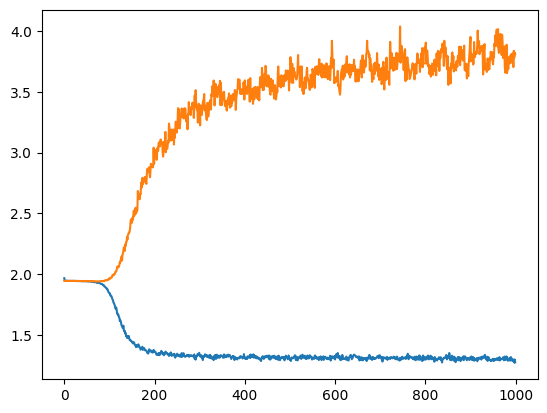

In [43]:
plt.plot(train_loss)
plt.plot(test_loss)

In [44]:
test=[]
train=[]
for i in range(len(train_acc)):
    train.append(train_acc[i].to('cpu'))
    test.append(test_acc[i].to('cpu'))
print(test)
print(train)

[tensor(0.1448), tensor(0.1472), tensor(0.1349), tensor(0.1433), tensor(0.1385), tensor(0.1437), tensor(0.1488), tensor(0.1369), tensor(0.1353), tensor(0.1508), tensor(0.1464), tensor(0.1341), tensor(0.1504), tensor(0.1492), tensor(0.1532), tensor(0.1433), tensor(0.1524), tensor(0.1425), tensor(0.1385), tensor(0.1361), tensor(0.1393), tensor(0.1393), tensor(0.1488), tensor(0.1393), tensor(0.1417), tensor(0.1484), tensor(0.1548), tensor(0.1444), tensor(0.1504), tensor(0.1504), tensor(0.1492), tensor(0.1480), tensor(0.1389), tensor(0.1544), tensor(0.1567), tensor(0.1500), tensor(0.1611), tensor(0.1429), tensor(0.1437), tensor(0.1476), tensor(0.1587), tensor(0.1472), tensor(0.1508), tensor(0.1623), tensor(0.1591), tensor(0.1520), tensor(0.1583), tensor(0.1476), tensor(0.1552), tensor(0.1516), tensor(0.1512), tensor(0.1417), tensor(0.1488), tensor(0.1460), tensor(0.1476), tensor(0.1440), tensor(0.1393), tensor(0.1548), tensor(0.1508), tensor(0.1567), tensor(0.1532), tensor(0.1528), tensor(

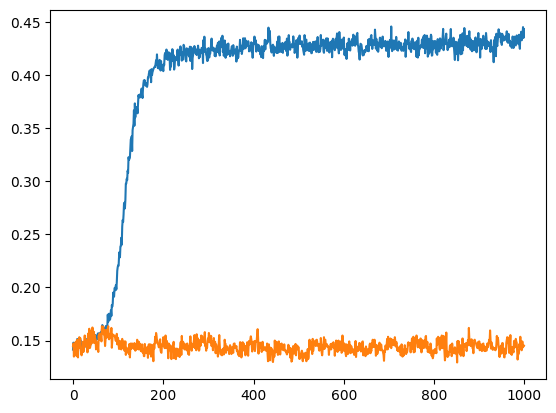

In [45]:
plt.plot(train)
plt.plot(test)